# Element agnostic system

NN model takes (1, 151) input sample and outputs (1, 6) array of 6 h width values. The sphere element structure is predefined beforehand.

Input (1, 151) - absorbed power sampled over visible spectrum (from 400 to 700 nm)

Output (1, 6) - sphere layer deisgn [h1, h2, h3, h4, h5, h6]

NN model consists of 6 layers (5 hidden + 1 ouput)

Batch normalization layers, dropout (60%), and LeakyReLU

Evaluation metrics: RMSE and MAE

K-fold cross validation

Adam optimizer with He-Xavier initial weights

Learning rate array [0.0001, 0.001, 0.01]

Number of neurons per layer array [100, 200, 300, 400, 500, 600]

Early stopping criteria is used

In [705]:
# important libraries import

import pandas as pd
import numpy as np
import torch
from torch import nn
import sys
import statistics as st
import copy
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [706]:
# check GPU memory state

!nvidia-smi

Fri Oct 29 03:38:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   37C    P0    56W / 300W |   2719MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [707]:
# CUDA check

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [708]:
%ls

Data/                     Results_Images/          element_agnostic-Copy1.ipynb
Data_100_500nm/           Results_Images_Element/  element_agnostic.ipynb*
Data_40k/                 Results_atakan/          element_and_h.ipynb
Data_normal_with_6/       Results_element/         element_based.ipynb*
Data_normal_with_6_last/  Untitled.ipynb*          tester/
Data_uniform/             aaa.csv*
Element_based_data/       atakan_data_2000_500/


In [709]:
# dataset import and training flag selection

data_distribution = "Normal"
#data_distribution = "Uniform"

data_normalized_flag = True
includes_source_distance = True
polarization_mode = "TE"

pd_x_train_val = pd.read_csv('./Data_40k/processed/X_train_TE.csv', header=None);
pd_y_train_val = pd.read_csv('./Data_40k/processed/y_train_te.csv', header=None);
#pd_ym_train_val = pd.read_csv('./Data/y_train_tm.csv', header=None);

# train-val dataset

#pd_x_train_val = pd.read_csv('./Data_Normal/X_train.csv', header=None);
#pd_ye_train_val = pd.read_csv('./Data_Normal/y_train_te.csv', header=None);
#pd_ym_train_val = pd.read_csv('./Data_Normal/y_train_tm.csv', header=None);

In [710]:
# from pandas to numpy

X = np.array(pd_x_train_val)
y = np.array(pd_y_train_val)
#ym = np.array(pd_ym_train_val)

In [711]:
# converting to nano-meter scale
# here, the sphere width deisgn as [h1, h2, h3, h4, h5, h6]
# where h1 is the outer layer and h5 is the core, h6 is the distance from source to sphere surface

X = X*(10**9)
print(X)

[[  0.79526087  91.66008719 122.37098878 113.7217228  105.23249327
   83.79057999]
 [115.60977954  93.71220482 112.61695481 104.57266756  90.0948414
    9.10295952]
 [ 96.61275718  78.369437    70.20626215  88.58708814  87.51711317
  173.47423493]
 ...
 [116.01234161  58.41366237  66.43040661 130.81549497  99.84890408
   68.96521344]
 [106.86418707 139.97112771  41.63707624 100.22941216 138.58216753
   86.33639187]
 [  0.94276802 106.46518924 122.82143876  37.91800699 117.0214909
   76.22674726]]


In [712]:
# photonic response sampled on the 151 visible wavelength spectrum (between 400 and 700 nm)
print(X.shape)
print(y.shape)

(8722, 6)
(8722, 151)


In [413]:
for i in range(len(X)):
    if np.isnan(y[i]).any():
        y[i] = 0
        X[i] = 0

In [414]:
# photonic response sampled on the 151 visible wavelength spectrum (between 400 and 700 nm)
print(X.shape)
print(y.shape)

(8722, 6)
(8722, 151)


In [415]:
y=y[~np.all(y == 0, axis=1)]
X=X[~np.all(X == 0, axis=1)]

In [498]:
XX = torch.from_numpy(X[0:10])
print(XX.shape)

XX = torch.unsqueeze(XX, 1)
print(XX.shape)
XX

torch.Size([10, 6])
torch.Size([10, 1, 6])


tensor([[[  0.7953,  91.6601, 122.3710, 113.7217, 105.2325,  83.7906]],

        [[115.6098,  93.7122, 112.6170, 104.5727,  90.0948,   9.1030]],

        [[ 96.6128,  78.3694,  70.2063,  88.5871,  87.5171, 173.4742]],

        [[119.3858,  72.8113,  40.8128,  26.5231, 187.5937, 119.2586]],

        [[ 52.8063,  52.2850,  67.0710, 114.1614, 158.6045,  76.2644]],

        [[144.9311,  58.4786,  78.8062, 116.2525,  60.0699,  77.5851]],

        [[ 89.4571, 109.2669, 121.5004, 116.5643,  75.1487,  68.4566]],

        [[ 98.8566,  79.4276,  75.5930, 143.4696,  72.5629,  29.1820]],

        [[146.0496,  21.7738,  91.7068, 157.7494, 124.8849,  60.4462]],

        [[ 53.0722,  50.4595, 116.1482, 136.1431, 125.6473,  43.9802]]],
       dtype=torch.float64)

In [416]:
print(y.shape)
print(X.shape)

(8722, 151)
(8722, 6)


In [331]:
# standartization/normalization of the dataset if flag is True

if data_normalized_flag:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print("X data")
    print(X)
    
   

X data
[[-2.40138481 -0.21418128  0.6362451   0.42478585  0.19329606 -0.03297668]
 [ 0.51970702 -0.1569186   0.36563874  0.17227415 -0.22658189 -2.0100255 ]
 [ 0.03638795 -0.58504611 -0.81096193 -0.26892396 -0.29808117  2.34103073]
 ...
 [ 0.52994894 -1.14189584 -0.91571557  0.89656981  0.0439697  -0.42541753]
 [ 0.29720312  1.13389919 -1.60355742  0.05240135  1.11832675  0.03441326]
 [-2.39763196  0.19894311  0.64874194 -1.66737829  0.5202913  -0.23319817]]


In [369]:
for i in range(151):
    y_max = np.amax(y[:,i])
    y_min = np.amin(y[:,i])
    y[:,i] = (y[:,i]-y_min)/(y_max-y_min)
print("\nY data")
print(y)


Y data
[[0.61493986 0.61253597 0.61113883 ... 0.28286152 0.27896138 0.27642459]
 [0.29958144 0.29869481 0.29749739 ... 0.21283314 0.20688677 0.20226998]
 [0.21782272 0.21065997 0.20324019 ... 0.04783514 0.04276202 0.03924474]
 ...
 [0.26440293 0.25849007 0.25221702 ... 0.13216763 0.1272297  0.12368138]
 [0.28395917 0.28446246 0.2853983  ... 0.32458221 0.31686477 0.31035209]
 [0.49766355 0.50318388 0.510045   ... 0.27481691 0.27275418 0.27192545]]


# DATA VISUALIZATION

In [333]:
# copy of dataset to make a comparative distribution plot

df1 = pd_x_train_val*(10**9)


In [334]:
df2 = pd_y_train_val

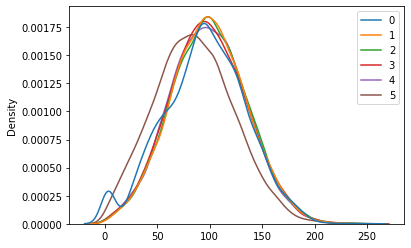

In [335]:
# PDF of X (h width values)

sns.kdeplot(data=df1)

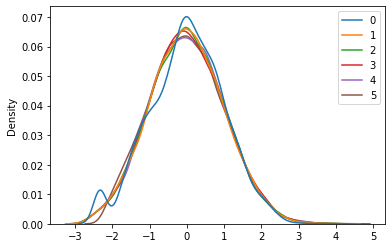

In [336]:
# PDF of standartized X (h width values)

sns.kdeplot(data=X)

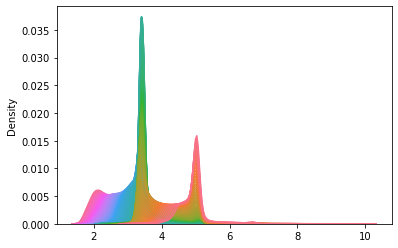

In [337]:
# PDF of y (photonic response)

sns.kdeplot(data=df2.iloc[:,:], legend=False)

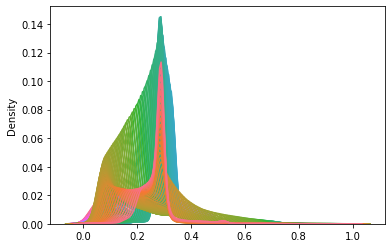

In [338]:
# PDF of normalized y (photonic response)

sns.kdeplot(data=y, legend=False)

# DATA LOADING METHOD

In [713]:
# dataset loader function, for traning and validation loaders

def data_loader(batch_size, x_train, y_train, x_val, y_val):
    
    train_dataset = TensorDataset(y_train, x_train)
    val_dataset = TensorDataset(y_val, x_val)
    
    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size = batch_size, 
                              shuffle = True)
    
    val_loader = DataLoader(dataset = val_dataset, 
                            batch_size = batch_size, 
                            shuffle = True)
    
    return train_loader, val_loader

In [516]:
m = nn.Linear(20, 10, 1000)
input = torch.randn(128, 20)
output = m(input)
print(output.size())
m

torch.Size([128, 10])


Linear(in_features=20, out_features=10, bias=True)

# NN MODEL DEFINITION

In [714]:
# main NN model definition

class NeuralNetwork(nn.Module):
    def __init__(self, layer_size):
        
        super(NeuralNetwork, self).__init__()
        self.fc_layer_1 = nn.Linear(151, layer_size) 
        self.conv_layer_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
        self.conv_layer_2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
        self.conv_layer_3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
        self.conv_layer_4 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)

        self.maxpool_layer = nn.MaxPool1d(kernel_size=3, stride=1)
        
        self.fc_layer_2 = nn.Linear(layer_size-16, 30)
        
        self.fc_layer_3 = nn.Linear(30, 6)
        
        self.relu = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(0.5)
        
        self.batchnorm1 = nn.BatchNorm1d(layer_size)
        self.batchnorm2 = nn.BatchNorm1d(1)
        self.batchnorm3 = nn.BatchNorm1d(30)


    def forward(self, inputs):

        x = self.batchnorm1(self.fc_layer_1(inputs))
        x = self.dropout(self.relu(x))
        
        x = x.unsqueeze(1)
        
        x = self.conv_layer_1(x)        
        x = self.batchnorm2(x)
        x = self.relu(self.dropout(x))        
        x = self.maxpool_layer(x)
        
        x = self.conv_layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(self.dropout(x))
        x = self.maxpool_layer(x)
        
        x = self.conv_layer_3(x)        
        x = self.batchnorm2(x)
        x = self.relu(self.dropout(x))        
        x = self.maxpool_layer(x)
        
        x = self.conv_layer_4(x)
        x = self.batchnorm2(x)
        x = self.relu(self.dropout(x))
        x = self.maxpool_layer(x)
        
        x = torch.squeeze(x,1)
        
        x = self.batchnorm3(self.fc_layer_2(x))
        x = self.relu(self.dropout(x))
        
        x = self.fc_layer_3(x)

        return x
            
            


def make_train_step(model, loss_fn, optimizer, loss_type):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        if loss_type == "loss_m":
            loss = torch.sqrt(loss_fn(yhat.view(-1), y.view(-1)))
        else:
            loss = loss_fn(yhat.view(-1), y.view(-1))
        # Computes gradients
        #loss = loss_fn(yhat.view(-1), y.view(-1))
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    # Returns the function that will be called inside the train loop
    return train_step

In [518]:
aa = torch.randn(2, 2, 10)
k = nn.Conv1d(out_channels=3, kernel_size=3)
print(k.weight)
print(aa)
print(k(aa))

weight = k.weight.data.numpy()
print(weight[2])
plt.imshow(weight[2, ...])

TypeError: __init__() missing 1 required positional argument: 'in_channels'

# WEIGHTS INITIALIZATION

In [715]:
# Xavier weights initialization

def init_weights(m):
    
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


# model complexity calculation
        
def model_complexity(model):
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Total: \t\t', pytorch_total_params/10**6)
    pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    print('Trainable: \t\t', pytorch_train_params/10**6)
    
    return (pytorch_train_params/10**6)

# IDEAL-FLAT RESPONSE AND OPTIMAL DESIGN GENERATION  

In [716]:
# function to gradually feed the already-trained model with ideal flat photonic response
# starting from 1 to 200 threshold, we feed a 1x151 vectors starting from [1, 1, 1, ..., 1] to [200, 200, 200, ..., 200]
# The trained NN model outputs the corresponding optimal design in response to the ideal flat response 

def increase(bestmodel):
    
    bestmodel.eval()
    
    if includes_source_distance:
        expected = torch.ones(1,6)
    else:
        expected = torch.ones(1,5)
        
    threshold = 10
    j = 0
    vals_arr = []
    threshold_arr = []
    
    while threshold < 50:
        vals = expected
        threshold = (1+j)
        j=j+0.25
        
        true_x_np = threshold * np.ones((1,151))
        true_x = torch.from_numpy( true_x_np.reshape(1,151) ).float()
        expected = bestmodel(true_x.to(device)).view(1,-1)
        vals_arr.append(expected.cpu().data.numpy())
        threshold_arr.append(threshold)
    
    vals_arr = np.array(vals_arr)
    vals_arr = vals_arr.reshape(vals_arr.shape[0],-1)
    threshold_arr = np.array(threshold_arr)
    
    print("Ideal response's array shapes:")
    print(vals_arr.shape)
    print(threshold_arr.shape)
    
    return vals_arr, threshold_arr 

# INAPPROPRIATE RESULTS FILTERING

In [717]:
# function to filter out negative samples generated by model so far

def extract_positive(vals_arr, threshold_arr):
    
    val_temp = []
    threshold_temp = []
    counter = 0
    
    main_val_matlab = []
    main_tr_matlab = []
    
    for i, row in enumerate(vals_arr):
        #if ((row < 1).any() == False)
        #(((row[0:5] >= 10).any() == True) and ((row[0:5] <= 100).any() == True)) and
        #and ((row[0]+row[1]+row[2]+row[3]+row[4] < row[5]) == True)
        #and ((row[0:6] > 1200).any() == False)
        if (row < 1).any() == False and (row[0:5] > 600).any() == False:
        #if ((row < 1).any() == False):

            val_temp.append(row)
            threshold_temp.append(threshold_arr[i])
            counter +=1
            
    print(counter)
    val_temp = np.array(val_temp)
    val_temp.shape
    
    threshold_temp = np.array(threshold_temp)
    threshold_temp.shape
    
    return  val_temp, threshold_temp

# MODEL PARAMETERS INITIALIZATION

In [718]:
# function to initialize the optimizer, model instance and other training stuff

def params_init(layer_size, learning_r, loss_main, loss_secondary):

    model = NeuralNetwork(layer_size).to(device)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_r)
    
    train_step_main = make_train_step(model, loss_main, optimizer, "loss_m")
    train_step_secondary = make_train_step(model, loss_secondary, optimizer, "loss_s")
    
    counter = 0
    
    return model, optimizer, train_step_main, train_step_secondary, counter

# MAIN TRAINING-VALIDATION SCRIPT

In [719]:
# the main function to train and validate the model

def train_main(part, train_loader, val_loader, args):
    
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    records = pd.DataFrame(columns=['Part_Num', 'Learning_rate', 'Layer_size', 'best_val(RMSE)',\
                                    'last_val(MAE)', 'stopping epoch', 'counter',\
                                    'positive num', 'all'])
    
    lr_arr = np.array([0.0001, 0.0005, 0.001, 0.01]).reshape(-1,1)
    N_size = np.array([100, 200, 300, 400 ,500 ,600]).reshape(-1,1)
    
    #lr_arr = np.array([0.01, 0.05, 0.1, 0.5]).reshape(-1,1)
    #N_size = np.array([25, 50, 100, 150]).reshape(-1,1)
    
    for i, LR in enumerate(lr_arr):
        for j, LS in enumerate(N_size):
            
            Learning_rate = LR[0]
            Layer_size    = LS[0]
            
            ds = DataStore(part, Learning_rate, Layer_size)
            
            loss_main =  nn.MSELoss()
            #loss_secondary = MARE
            loss_secondary = nn.L1Loss()
            model, optimizer, train_step_main, train_step_secondary, counter = params_init(Layer_size, Learning_rate, \
                                                                                           loss_main, loss_secondary)
            complexity = model_complexity(model)
            
            print("%-10s\n %-15s %-4.6f \n %-15s %-4.2f\n %10s" %("////////////////////////",\
                                                                  "Learning Rate:", Learning_rate,\
                                                                  "Layer Size:",    Layer_size,\
                                                                  "////////////////////////"))
            
            bestmodel, best_val_error_main, best_val_error_secondary, counter, epoch = train_procedure(model, \
                                                                                                       train_step_main, \
                                                                                                       train_step_secondary, \
                                                                                                       loss_main, \
                                                                                                       loss_secondary, \
                                                                                                       train_loader, \
                                                                                                       val_loader, \
                                                                                                       args, \
                                                                                                       part, \
                                                                                                       Layer_size, \
                                                                                                       Learning_rate)
            
            ds.net_saver(bestmodel)
            vals_arr, threshold_arr = increase(bestmodel)
            val_temp, threshold_temp = extract_positive(vals_arr, threshold_arr)
            ds.dimensions_saver(val_temp, threshold_temp)
            #ds.dimensions_saver(vals_arr, threshold_arr)

            new_row = {'Part_Num': part, \
                       'Learning_rate': Learning_rate, \
                       'Layer_size': Layer_size, \
                       'best_val(RMSE)': best_val_error_main, \
                       'last_val(MAE)': best_val_error_secondary, \
                       'stopping epoch': epoch, \
                       'counter': counter, \
                       'positive num':val_temp.shape[0], \
                       'all': vals_arr.shape[0]}
            
            records = records.append(new_row, ignore_index=True)
    
    ds.records_saver(records)
    
    return lr_arr, N_size
    
    

# SECONDARY TRAINING-VALIDATION SCRIPT

In [720]:
# secondary main function to train and validate model

def train_procedure(model, train_step_main, train_step_secondary, loss_main, loss_secondary,
                    train_loader, val_loader, args, part, Layer_size, Learning_rate):
    
    n_epochs = args.epochs
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    counter = 0
    i = 0
    k = 0
    
    tr_losses_main_global = []
    val_losses_main_global = []
    
    tr_losses_secondary_global = []
    val_losses_secondary_global = []
    
    best_val_error_main = 70000
    final_error_secondary = 70000
    
    for epoch in range(0, n_epochs):
        
        tr_losses_main = []
        tr_losses_secondary= []
        
        val_losses_main = []
        val_losses_secondary = []
        
        for x_batch, y_batch in train_loader:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            tr_loss_main = train_step_main(x_batch, y_batch)
            tr_losses_main.append(tr_loss_main)
            
            tr_loss_secondary = train_step_secondary(x_batch, y_batch)
            tr_losses_secondary.append(tr_loss_secondary)
            
        with torch.no_grad():
            model.eval()
            for x_val, y_val in val_loader:
                
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = model(x_val)
                
                val_losses_main_temp = torch.sqrt(loss_main(y_hat, y_val))
                val_losses_secondary_temp = loss_secondary(y_hat, y_val)
                
                val_losses_main.append(val_losses_main_temp.item())
                val_losses_secondary.append(val_losses_secondary_temp.item())
            
            counter += 1
            
            if (st.mean(val_losses_main) < best_val_error_main):
                best_val_error_main = st.mean(val_losses_main)
                final_error_secondary = st.mean(val_losses_secondary)
                bestm = copy.deepcopy(model)
                counter = 1
            
            MSE_TR  = st.mean(tr_losses_main)
            MSE_VL  = st.mean(val_losses_main)
            MARE_TR = st.mean(tr_losses_secondary)
            MARE_VL = st.mean(val_losses_secondary)
            
            if  counter >= 1:
                print("%-5s %-i   %-5s %-i   %-10s %-4.9f   %-10s %-4.9f   %-10s %-4.9f   %-10s %-4.9f \n" % \
                      ("Epochs", epoch+1, "Counter", counter, \
                       "Train(RMSE):", np.round(MSE_TR,7), \
                       "Val(RMSE):", np.round(MSE_VL,7), \
                       "Train(MAE),%:", np.round( MARE_TR,7), \
                       "Val(MAE),%:", np.round(MARE_VL,7)))
            
            tr_losses_main_global.append(MSE_TR)
            val_losses_main_global.append(MSE_VL)
            tr_losses_secondary_global.append(MARE_TR)
            val_losses_secondary_global.append(MARE_VL)
            
            if counter == args.stopping_criterion:
                print('//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////')
                break;
    
    plt.plot(np.arange(1, epoch+2), tr_losses_main_global, color='green', label="RMSE Train")
    plt.plot(np.arange(1, epoch+2), val_losses_main_global, color='red', label="RMSE Val")
    plt.xlabel('Epoch')
    plt.ylabel('RMSE Loss')
    plt.title('Train-Val, Layer Size: ' + str(Layer_size) + ', Learning Rate: ' + str(Learning_rate))
    plt.legend()
    plt.savefig("./Results_Images/Part_" + str(part) + "_lr_" + str(Learning_rate) + "_layer_size_" + str(Layer_size) + ".png")
    plt.show()

    return bestm, best_val_error_main, final_error_secondary, counter, epoch+1

# DATA STORING METHODS

In [721]:
# data store to files

import os
import torch
import pandas as pd

class DataStore():
    def __init__(self, part, Learning_r, Layer_s):
        super().__init__()
        self.part = part
        self.Learning_r = Learning_r
        self.Layer_s = Layer_s
        self.results_dir = 'Results'
        self.part_number = 'Part_Number_' + str(self.part)
        self.folder_name = self.part_number + '_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s)
        self.part_dir = os.path.join(
            self.results_dir, self.part_number)
        self.checkpoint_dir = os.path.join(
            self.part_dir, self.folder_name)
        os.makedirs(self.part_dir, exist_ok = True)
        os.makedirs(self.checkpoint_dir, exist_ok = True)
        
    def net_saver(self, model_to_save):
        model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
        model_path = os.path.join(self.checkpoint_dir, model_name)
        torch.save(model_to_save.state_dict(), model_path)
        print(model_name, 'Was saved successfully \t\t\t[saved]')
        
    def net_loader(self, path = None):
        testm = NN(self.Layer_s).to(device)
        if path is None:
            model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
            path = os.path.join(self.checkpoint_dir, model_name)
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded.\t\t\t [loaded]')
        else:
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded from the path.\t\t\t [loaded from Path]')
        return testm
    
    def records_saver(self, records):
        self.records  = records
        self.name_records =  'Part_Number_' + str(self.part) + '_records.csv'
        self.records.to_csv(os.path.join(self.results_dir, self.name_records),index = True,header = True)
        
    def dimensions_saver(self, d_values, threshold):
        self.vals_matlab = pd.DataFrame(d_values)
        self.threshold_matlab = pd.DataFrame(threshold)
        name_vals = self.part_number  + '_vals_lr_'+ str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        name_threshold = self.part_number  + '_threshold_lr_'+str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        self.vals_matlab.to_csv(os.path.join(self.checkpoint_dir, name_vals), index = False, header = False)
        self.threshold_matlab.to_csv(os.path.join(self.checkpoint_dir, name_threshold), index = False, header = False)
        
def description_saver(lr, ls,
                      data_distribution, data_normalized_flag,
                      includes_source_distance, polarization_mode, args):
    
    f = open("./Results/Description.txt", "w")
    
    array = np.array2string(lr, separator=',')
    f.write("Learning rates: \n")
    f.write(array)
    f.write("\n\n")
    
    array = np.array2string(ls, separator=',')
    f.write("Layer sizes: \n")
    f.write(array)
    f.write("\n\n")
    
    f.write("Data distribution: " + str(data_distribution))
    f.write("\n")
    
    f.write("Data normalized flag: " + str(data_normalized_flag))
    f.write("\n")
    
    f.write("Includes source distance: " + str(includes_source_distance))
    f.write("\n")
    
    f.write("Polarization mode: " + str(polarization_mode))
    f.write("\n")
    
    f.write("Epochs: " + str(args.epochs))
    f.write("\n")
    
    f.write("Stopping criteria: " + str(args.stopping_criterion))
    f.write("\n")
    
    f.write("Batch size: " + str(args.batch_size))
    f.write("\n")
    
    f.write("CV parts: " + str(args.n_splits))
    f.write("\n")
    

# MAIN FUNCTION DEFINITION

In [722]:
# script to initialize K-fold cross validation on dataset provided (the main loop)

from sklearn.model_selection import KFold
import argparse

def main(args):
    
    print(args)
    sys.path.append("/.")
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    kf = KFold(n_splits=args.n_splits, random_state=256, shuffle=True)
    kf.get_n_splits(X)
    device = args.device
    print(kf)
    part = 0
    
    for train_index, test_index in kf.split(X):
        part += 1
        if part in args.parts:
            print('CV part number:\t', part)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = torch.from_numpy(X_train).float().to(device), \
            torch.from_numpy(X_test).float().to(device),\
            torch.from_numpy(y_train).float().to(device),\
            torch.from_numpy(y_test).float().to(device)
            
                        
            train_loader, val_loader = data_loader(args.batch_size, x_train_tensor, \
                                                   y_train_tensor, x_test_tensor, \
                                                   y_test_tensor)
            lr, ls = train_main(part, train_loader, val_loader, args)
            
    description_saver(lr, ls, data_distribution, data_normalized_flag, 
                      includes_source_distance, polarization_mode, args)

In [723]:
X

array([[  0.79526087,  91.66008719, 122.37098878, 113.7217228 ,
        105.23249327,  83.79057999],
       [115.60977954,  93.71220482, 112.61695481, 104.57266756,
         90.0948414 ,   9.10295952],
       [ 96.61275718,  78.369437  ,  70.20626215,  88.58708814,
         87.51711317, 173.47423493],
       ...,
       [116.01234161,  58.41366237,  66.43040661, 130.81549497,
         99.84890408,  68.96521344],
       [106.86418707, 139.97112771,  41.63707624, 100.22941216,
        138.58216753,  86.33639187],
       [  0.94276802, 106.46518924, 122.82143876,  37.91800699,
        117.0214909 ,  76.22674726]])

In [724]:
y

array([[7.35652044, 7.32581807, 7.29592122, ..., 2.88443024, 2.87340273,
        2.86293522],
       [5.10780363, 5.09643244, 5.08190208, ..., 2.57201315, 2.5502935 ,
        2.52869215],
       [4.52480919, 4.47107271, 4.41653324, ..., 1.83590873, 1.81452512,
        1.79387528],
       ...,
       [4.85695731, 4.81083615, 4.76226448, ..., 2.21214068, 2.19319224,
        2.17446336],
       [4.99640639, 4.99533223, 4.99649372, ..., 3.07055845, 3.04332293,
        3.01585939],
       [6.52026178, 6.54903023, 6.58229209, ..., 2.84854086, 2.84557595,
        2.8426559 ]])

In [636]:
modell = NeuralNetwork(100)
modell

NeuralNetwork(
  (fc_layer_1): Linear(in_features=151, out_features=100, bias=True)
  (conv_layer_2): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv_layer_3): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (maxpool_layer_4): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc_layer_5): Linear(in_features=92, out_features=30, bias=True)
  (fc_layer_6): Linear(in_features=30, out_features=6, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(94, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# SCRIPT LAUNCHES HERE...

Namespace(batch_size=256, device='cuda', epochs=1000, n_splits=3, parts=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), seed=17, stopping_criterion=20)
KFold(n_splits=3, random_state=256, shuffle=True)
CV part number:	 1
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.972544100   Val(RMSE): 103.274002700   Train(MAE),%: 96.019109300   Val(MAE),%: 96.271264400 

Epochs 2   Counter 1   Train(RMSE): 102.906813900   Val(RMSE): 103.183655400   Train(MAE),%: 95.956359900   Val(MAE),%: 96.190080600 

Epochs 3   Counter 1   Train(RMSE): 102.838344700   Val(RMSE): 103.181566200   Train(MAE),%: 95.872167200   Val(MAE),%: 96.133216900 

Epochs 4   Counter 1   Train(RMSE): 102.783437300   Val(RMSE): 103.107828100   Train(MAE),%: 95.812818800   Val(MAE),%: 96.115295400 

Epochs 5   Counter 1   Train(RMSE): 102.696175300   Val(RMSE): 103.029652900   Train(MAE),%: 9

Epochs 59   Counter 1   Train(RMSE): 97.083976100   Val(RMSE): 98.014907800   Train(MAE),%: 89.740365100   Val(MAE),%: 90.615025200 

Epochs 60   Counter 1   Train(RMSE): 96.912150800   Val(RMSE): 97.943436900   Train(MAE),%: 89.582634300   Val(MAE),%: 90.570844000 

Epochs 61   Counter 1   Train(RMSE): 96.785209300   Val(RMSE): 97.643106500   Train(MAE),%: 89.418382700   Val(MAE),%: 90.201151500 

Epochs 62   Counter 1   Train(RMSE): 96.585741500   Val(RMSE): 97.608456900   Train(MAE),%: 89.235542600   Val(MAE),%: 90.177395500 

Epochs 63   Counter 1   Train(RMSE): 96.455379000   Val(RMSE): 97.462689100   Train(MAE),%: 89.065606800   Val(MAE),%: 90.014898300 

Epochs 64   Counter 1   Train(RMSE): 96.297221000   Val(RMSE): 97.194797500   Train(MAE),%: 88.905821800   Val(MAE),%: 89.712462100 

Epochs 65   Counter 1   Train(RMSE): 96.164254900   Val(RMSE): 97.094526900   Train(MAE),%: 88.775919700   Val(MAE),%: 89.637031600 

Epochs 66   Counter 1   Train(RMSE): 95.965601700   Val(RMSE):

Epochs 120   Counter 1   Train(RMSE): 84.619328400   Val(RMSE): 84.605857200   Train(MAE),%: 76.414355700   Val(MAE),%: 76.251650500 

Epochs 121   Counter 1   Train(RMSE): 84.348669300   Val(RMSE): 84.187406500   Train(MAE),%: 76.097926600   Val(MAE),%: 75.805542600 

Epochs 122   Counter 1   Train(RMSE): 84.161688400   Val(RMSE): 84.085957800   Train(MAE),%: 75.819570800   Val(MAE),%: 75.738574300 

Epochs 123   Counter 1   Train(RMSE): 83.954412700   Val(RMSE): 84.023150800   Train(MAE),%: 75.585837700   Val(MAE),%: 75.652834600 

Epochs 124   Counter 1   Train(RMSE): 83.761038100   Val(RMSE): 83.564062800   Train(MAE),%: 75.248010400   Val(MAE),%: 75.123969400 

Epochs 125   Counter 1   Train(RMSE): 83.281801000   Val(RMSE): 83.180950200   Train(MAE),%: 75.031502400   Val(MAE),%: 74.730146400 

Epochs 126   Counter 2   Train(RMSE): 83.147049900   Val(RMSE): 83.191917400   Train(MAE),%: 74.655432300   Val(MAE),%: 74.722010900 

Epochs 127   Counter 1   Train(RMSE): 82.906284500   Va

Epochs 181   Counter 1   Train(RMSE): 67.760165700   Val(RMSE): 65.574216800   Train(MAE),%: 58.277599200   Val(MAE),%: 56.185175600 

Epochs 182   Counter 1   Train(RMSE): 67.584533000   Val(RMSE): 65.420635200   Train(MAE),%: 57.954209400   Val(MAE),%: 56.036920200 

Epochs 183   Counter 1   Train(RMSE): 67.207849300   Val(RMSE): 65.126448000   Train(MAE),%: 57.535476400   Val(MAE),%: 55.737256400 

Epochs 184   Counter 1   Train(RMSE): 66.887847200   Val(RMSE): 64.590973200   Train(MAE),%: 57.561513200   Val(MAE),%: 55.182361600 

Epochs 185   Counter 1   Train(RMSE): 66.570780500   Val(RMSE): 64.493024500   Train(MAE),%: 56.990815000   Val(MAE),%: 55.092951500 

Epochs 186   Counter 1   Train(RMSE): 66.463827400   Val(RMSE): 64.056054100   Train(MAE),%: 56.708127100   Val(MAE),%: 54.652709600 

Epochs 187   Counter 1   Train(RMSE): 66.118648000   Val(RMSE): 63.590845400   Train(MAE),%: 56.305736400   Val(MAE),%: 54.159519500 

Epochs 188   Counter 1   Train(RMSE): 65.824156200   Va

Epochs 242   Counter 1   Train(RMSE): 51.214569800   Val(RMSE): 47.726225500   Train(MAE),%: 41.555364500   Val(MAE),%: 38.789425800 

Epochs 243   Counter 1   Train(RMSE): 51.040165800   Val(RMSE): 47.464592900   Train(MAE),%: 41.594438800   Val(MAE),%: 38.539308900 

Epochs 244   Counter 1   Train(RMSE): 50.660502700   Val(RMSE): 47.140465100   Train(MAE),%: 41.542560700   Val(MAE),%: 38.232122400 

Epochs 245   Counter 1   Train(RMSE): 50.563564500   Val(RMSE): 47.131954200   Train(MAE),%: 41.007717000   Val(MAE),%: 38.236502300 

Epochs 246   Counter 1   Train(RMSE): 50.208084600   Val(RMSE): 46.807036400   Train(MAE),%: 40.929769800   Val(MAE),%: 37.949151700 

Epochs 247   Counter 1   Train(RMSE): 50.327787500   Val(RMSE): 46.692394300   Train(MAE),%: 40.881404700   Val(MAE),%: 37.835560800 

Epochs 248   Counter 1   Train(RMSE): 50.088174400   Val(RMSE): 46.398472200   Train(MAE),%: 40.688297100   Val(MAE),%: 37.565246900 

Epochs 249   Counter 1   Train(RMSE): 49.656198400   Va

Epochs 303   Counter 3   Train(RMSE): 43.222410100   Val(RMSE): 38.796558700   Train(MAE),%: 34.675425800   Val(MAE),%: 31.077350100 

Epochs 304   Counter 4   Train(RMSE): 43.160905100   Val(RMSE): 38.791692700   Train(MAE),%: 34.516773900   Val(MAE),%: 31.080414800 

Epochs 305   Counter 1   Train(RMSE): 43.184042700   Val(RMSE): 38.599405000   Train(MAE),%: 34.553197400   Val(MAE),%: 30.930326100 

Epochs 306   Counter 2   Train(RMSE): 43.163518800   Val(RMSE): 38.660534500   Train(MAE),%: 34.338208900   Val(MAE),%: 30.951835500 

Epochs 307   Counter 1   Train(RMSE): 43.312429800   Val(RMSE): 38.432522500   Train(MAE),%: 34.535926700   Val(MAE),%: 30.790178000 

Epochs 308   Counter 2   Train(RMSE): 43.203556100   Val(RMSE): 38.669752400   Train(MAE),%: 34.388051200   Val(MAE),%: 30.975854400 

Epochs 309   Counter 3   Train(RMSE): 43.046832400   Val(RMSE): 38.576770800   Train(MAE),%: 34.125551500   Val(MAE),%: 30.894869300 

Epochs 310   Counter 4   Train(RMSE): 42.838538300   Va

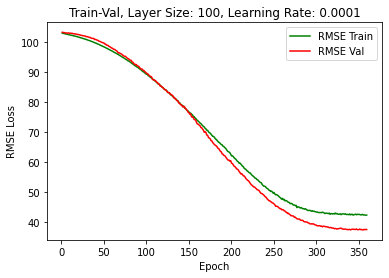

Part_Number_1_model_lr_0.0001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.399614100   Val(RMSE): 102.449336400   Train(MAE),%: 95.427451800   Val(MAE),%: 95.392004600 

Epochs 2   Counter 1   Train(RMSE): 102.321443000   Val(RMSE): 102.331248600   Train(MAE),%: 95.346669400   Val(MAE),%: 95.280425400 

Epochs 3   Counter 1   Train(RMSE): 102.246922400   Val(RMSE): 102.330763500   Train(MAE),%: 95.278998000   Val(MAE),%: 95.226657200 

Epochs 4   Counter 1   Train(RMSE): 102.191106400   Val(RMSE): 102.211010600   Train(MAE),%: 95.212382800   Val(MAE),%: 95.159465200 

Epochs 5   Counter 1   Train(RMSE): 102.109687800   Val(RMSE): 102.082145700   Train(MAE),%: 95.128000000   Val(MAE),%: 94.949137400 

Epochs 6   Counter 1   Train(RMSE): 102.04438150

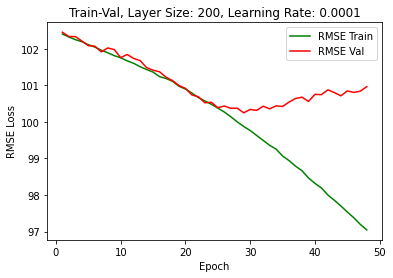

Part_Number_1_model_lr_0.0001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.695054800   Val(RMSE): 102.933069900   Train(MAE),%: 95.746614200   Val(MAE),%: 95.915549000 

Epochs 2   Counter 1   Train(RMSE): 102.630685200   Val(RMSE): 102.792233800   Train(MAE),%: 95.684988600   Val(MAE),%: 95.781601000 

Epochs 3   Counter 1   Train(RMSE): 102.572811300   Val(RMSE): 102.749095300   Train(MAE),%: 95.610511100   Val(MAE),%: 95.677596400 

Epochs 4   Counter 1   Train(RMSE): 102.514720100   Val(RMSE): 102.605588900   Train(MAE),%: 95.549001300   Val(MAE),%: 95.582842500 

Epochs 5   Counter 1   Train(RMSE): 102.421159500   Val(RMSE): 102.428016000   Train(MAE),%: 95.462369200   Val(MAE),%: 95.318819000 

Epochs 6   Counter 1   Train(RMSE): 102.35984670

Epochs 60   Counter 17   Train(RMSE): 95.376958400   Val(RMSE): 94.664615000   Train(MAE),%: 88.190374000   Val(MAE),%: 87.023384100 

Epochs 61   Counter 18   Train(RMSE): 95.190710300   Val(RMSE): 94.522256900   Train(MAE),%: 87.895643800   Val(MAE),%: 86.826453500 

Epochs 62   Counter 19   Train(RMSE): 94.990488100   Val(RMSE): 94.479575500   Train(MAE),%: 87.686593800   Val(MAE),%: 86.808926300 

Epochs 63   Counter 20   Train(RMSE): 94.746163700   Val(RMSE): 94.458178800   Train(MAE),%: 87.460361000   Val(MAE),%: 86.775736500 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


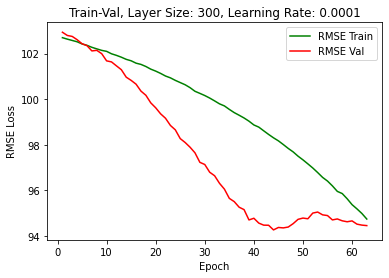

Part_Number_1_model_lr_0.0001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.930662700   Val(RMSE): 102.982745500   Train(MAE),%: 95.973009200   Val(MAE),%: 95.984007500 

Epochs 2   Counter 1   Train(RMSE): 102.852336700   Val(RMSE): 102.780731200   Train(MAE),%: 95.884943400   Val(MAE),%: 95.788073900 

Epochs 3   Counter 1   Train(RMSE): 102.791060100   Val(RMSE): 102.682724600   Train(MAE),%: 95.819454400   Val(MAE),%: 95.634264600 

Epochs 4   Counter 1   Train(RMSE): 102.730310500   Val(RMSE): 102.496021300   Train(MAE),%: 95.769451600   Val(MAE),%: 95.494374600 

Epochs 5   Counter 1   Train(RMSE): 102.646011700   Val(RMSE): 102.283903100   Train(MAE),%: 95.687878200   Val(MAE),%: 95.197433500 

Epochs 6   Counter 1   Train(RMSE): 102.58254540

Epochs 60   Counter 10   Train(RMSE): 96.229969500   Val(RMSE): 94.438906400   Train(MAE),%: 89.009644200   Val(MAE),%: 86.765772500 

Epochs 61   Counter 11   Train(RMSE): 96.076671400   Val(RMSE): 94.503519100   Train(MAE),%: 88.802975200   Val(MAE),%: 86.789167400 

Epochs 62   Counter 12   Train(RMSE): 95.862544800   Val(RMSE): 94.562409700   Train(MAE),%: 88.639834200   Val(MAE),%: 86.874806100 

Epochs 63   Counter 13   Train(RMSE): 95.679143200   Val(RMSE): 94.871978800   Train(MAE),%: 88.394913100   Val(MAE),%: 87.201195400 

Epochs 64   Counter 14   Train(RMSE): 95.536460900   Val(RMSE): 94.939038000   Train(MAE),%: 88.219704700   Val(MAE),%: 87.266365100 

Epochs 65   Counter 15   Train(RMSE): 95.348877300   Val(RMSE): 95.176761600   Train(MAE),%: 88.024383900   Val(MAE),%: 87.552536000 

Epochs 66   Counter 16   Train(RMSE): 95.104723400   Val(RMSE): 95.146001800   Train(MAE),%: 87.759332400   Val(MAE),%: 87.559471100 

Epochs 67   Counter 17   Train(RMSE): 94.988170500   Va

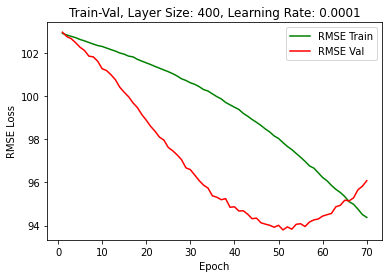

Part_Number_1_model_lr_0.0001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
0
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.547743400   Val(RMSE): 102.669361800   Train(MAE),%: 95.585108900   Val(MAE),%: 95.633533500 

Epochs 2   Counter 1   Train(RMSE): 102.455051300   Val(RMSE): 102.531062400   Train(MAE),%: 95.506822000   Val(MAE),%: 95.499798500 

Epochs 3   Counter 1   Train(RMSE): 102.376715000   Val(RMSE): 102.462820100   Train(MAE),%: 95.418333000   Val(MAE),%: 95.371528000 

Epochs 4   Counter 1   Train(RMSE): 102.300593800   Val(RMSE): 102.312330900   Train(MAE),%: 95.350189200   Val(MAE),%: 95.272019700 

Epochs 5   Counter 1   Train(RMSE): 102.206755300   Val(RMSE): 102.101057100   Train(MAE),%: 95.240353100   Val(MAE),%: 94.975545200 

Epochs 6   Counter 1   Train(RMSE): 102.130604000 

Epochs 60   Counter 1   Train(RMSE): 95.030571600   Val(RMSE): 93.477339400   Train(MAE),%: 87.526931100   Val(MAE),%: 85.818321900 

Epochs 61   Counter 1   Train(RMSE): 94.884695300   Val(RMSE): 93.397838600   Train(MAE),%: 87.334044700   Val(MAE),%: 85.685681700 

Epochs 62   Counter 1   Train(RMSE): 94.644065200   Val(RMSE): 92.993287400   Train(MAE),%: 87.039392200   Val(MAE),%: 85.270112400 

Epochs 63   Counter 1   Train(RMSE): 94.470094400   Val(RMSE): 92.898442600   Train(MAE),%: 86.871325600   Val(MAE),%: 85.160877900 

Epochs 64   Counter 1   Train(RMSE): 94.354990400   Val(RMSE): 92.707464200   Train(MAE),%: 86.711070200   Val(MAE),%: 84.942974700 

Epochs 65   Counter 1   Train(RMSE): 94.146796500   Val(RMSE): 92.398889500   Train(MAE),%: 86.563411500   Val(MAE),%: 84.643854800 

Epochs 66   Counter 1   Train(RMSE): 93.931442600   Val(RMSE): 92.279179900   Train(MAE),%: 86.270367200   Val(MAE),%: 84.552365600 

Epochs 67   Counter 1   Train(RMSE): 93.828844800   Val(RMSE):

Epochs 121   Counter 3   Train(RMSE): 80.693406100   Val(RMSE): 78.851605700   Train(MAE),%: 72.408072100   Val(MAE),%: 70.171176300 

Epochs 122   Counter 1   Train(RMSE): 80.508042700   Val(RMSE): 77.832098600   Train(MAE),%: 72.106670900   Val(MAE),%: 69.133728000 

Epochs 123   Counter 2   Train(RMSE): 80.249015800   Val(RMSE): 77.895416900   Train(MAE),%: 71.849317100   Val(MAE),%: 69.169878600 

Epochs 124   Counter 1   Train(RMSE): 79.995330500   Val(RMSE): 77.598049800   Train(MAE),%: 71.414542200   Val(MAE),%: 68.829382600 

Epochs 125   Counter 1   Train(RMSE): 79.627681600   Val(RMSE): 77.282370200   Train(MAE),%: 71.094726200   Val(MAE),%: 68.507643400 

Epochs 126   Counter 1   Train(RMSE): 79.459716500   Val(RMSE): 76.830677700   Train(MAE),%: 70.789967100   Val(MAE),%: 68.003507600 

Epochs 127   Counter 1   Train(RMSE): 79.133573100   Val(RMSE): 76.477134100   Train(MAE),%: 70.460939800   Val(MAE),%: 67.672313100 

Epochs 128   Counter 1   Train(RMSE): 78.845077200   Va

Epochs 182   Counter 1   Train(RMSE): 63.701070500   Val(RMSE): 55.636156400   Train(MAE),%: 54.056938000   Val(MAE),%: 46.250832900 

Epochs 183   Counter 2   Train(RMSE): 63.640731500   Val(RMSE): 56.327643100   Train(MAE),%: 53.703961700   Val(MAE),%: 46.950516400 

Epochs 184   Counter 1   Train(RMSE): 63.200671200   Val(RMSE): 55.384730000   Train(MAE),%: 53.415355400   Val(MAE),%: 45.995441800 

Epochs 185   Counter 1   Train(RMSE): 62.849373500   Val(RMSE): 54.791237500   Train(MAE),%: 53.012333900   Val(MAE),%: 45.441045400 

Epochs 186   Counter 2   Train(RMSE): 62.668090700   Val(RMSE): 54.932409600   Train(MAE),%: 52.863269000   Val(MAE),%: 45.563786800 

Epochs 187   Counter 1   Train(RMSE): 62.557924400   Val(RMSE): 54.440341600   Train(MAE),%: 52.592702900   Val(MAE),%: 45.066804300 

Epochs 188   Counter 1   Train(RMSE): 62.091143600   Val(RMSE): 53.777186700   Train(MAE),%: 52.221020700   Val(MAE),%: 44.428264600 

Epochs 189   Counter 1   Train(RMSE): 61.889237900   Va

Epochs 243   Counter 1   Train(RMSE): 48.905132600   Val(RMSE): 40.454767900   Train(MAE),%: 39.573086400   Val(MAE),%: 32.418431000 

Epochs 244   Counter 2   Train(RMSE): 48.573260400   Val(RMSE): 40.492641800   Train(MAE),%: 39.286045200   Val(MAE),%: 32.462299700 

Epochs 245   Counter 1   Train(RMSE): 48.535954000   Val(RMSE): 40.114960400   Train(MAE),%: 38.916327900   Val(MAE),%: 32.179693500 

Epochs 246   Counter 2   Train(RMSE): 48.030705500   Val(RMSE): 40.221956900   Train(MAE),%: 38.893448000   Val(MAE),%: 32.270486700 

Epochs 247   Counter 1   Train(RMSE): 48.361043000   Val(RMSE): 40.107349700   Train(MAE),%: 38.694091600   Val(MAE),%: 32.150665800 

Epochs 248   Counter 2   Train(RMSE): 47.737591300   Val(RMSE): 40.122913400   Train(MAE),%: 38.654554800   Val(MAE),%: 32.166057700 

Epochs 249   Counter 1   Train(RMSE): 47.515318500   Val(RMSE): 39.956736600   Train(MAE),%: 38.454734600   Val(MAE),%: 31.968059200 

Epochs 250   Counter 1   Train(RMSE): 47.589087900   Va

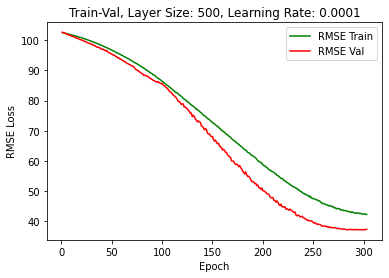

Part_Number_1_model_lr_0.0001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.861767600   Val(RMSE): 102.838999400   Train(MAE),%: 95.903919100   Val(MAE),%: 95.807698600 

Epochs 2   Counter 1   Train(RMSE): 102.783415100   Val(RMSE): 102.686773300   Train(MAE),%: 95.831909800   Val(MAE),%: 95.656644800 

Epochs 3   Counter 1   Train(RMSE): 102.706021800   Val(RMSE): 102.684951100   Train(MAE),%: 95.751399500   Val(MAE),%: 95.599226000 

Epochs 4   Counter 1   Train(RMSE): 102.646399800   Val(RMSE): 102.559179300   Train(MAE),%: 95.682252000   Val(MAE),%: 95.524393100 

Epochs 5   Counter 1   Train(RMSE): 102.555703900   Val(RMSE): 102.393171900   Train(MAE),%: 95.603954500   Val(MAE),%: 95.271036800 

Epochs 6   Counter 1   Train(RMSE): 102.49729020

Epochs 60   Counter 1   Train(RMSE): 96.243187000   Val(RMSE): 95.478632000   Train(MAE),%: 88.850818500   Val(MAE),%: 87.923654600 

Epochs 61   Counter 1   Train(RMSE): 96.073877400   Val(RMSE): 95.391452200   Train(MAE),%: 88.627793000   Val(MAE),%: 87.782334600 

Epochs 62   Counter 1   Train(RMSE): 95.918945000   Val(RMSE): 95.115875900   Train(MAE),%: 88.460693700   Val(MAE),%: 87.502457900 

Epochs 63   Counter 1   Train(RMSE): 95.755743900   Val(RMSE): 95.039599100   Train(MAE),%: 88.292607500   Val(MAE),%: 87.414468100 

Epochs 64   Counter 1   Train(RMSE): 95.604666000   Val(RMSE): 94.892160400   Train(MAE),%: 88.101154800   Val(MAE),%: 87.242737500 

Epochs 65   Counter 1   Train(RMSE): 95.376604800   Val(RMSE): 94.567660600   Train(MAE),%: 87.902107200   Val(MAE),%: 86.924600000 

Epochs 66   Counter 1   Train(RMSE): 95.206428500   Val(RMSE): 94.420624400   Train(MAE),%: 87.712699900   Val(MAE),%: 86.803850800 

Epochs 67   Counter 1   Train(RMSE): 95.112286400   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 83.466560000   Val(RMSE): 82.885339100   Train(MAE),%: 75.026190100   Val(MAE),%: 74.427042600 

Epochs 122   Counter 1   Train(RMSE): 83.243971800   Val(RMSE): 82.628609300   Train(MAE),%: 74.806622700   Val(MAE),%: 74.196809800 

Epochs 123   Counter 1   Train(RMSE): 82.953868400   Val(RMSE): 82.275372200   Train(MAE),%: 74.515015300   Val(MAE),%: 73.801236500 

Epochs 124   Counter 1   Train(RMSE): 82.874282200   Val(RMSE): 82.250509900   Train(MAE),%: 74.147018800   Val(MAE),%: 73.742925600 

Epochs 125   Counter 1   Train(RMSE): 82.516561100   Val(RMSE): 82.237632100   Train(MAE),%: 73.911556400   Val(MAE),%: 73.739172600 

Epochs 126   Counter 1   Train(RMSE): 82.260981000   Val(RMSE): 81.891524600   Train(MAE),%: 73.597115200   Val(MAE),%: 73.349320100 

Epochs 127   Counter 1   Train(RMSE): 81.931364600   Val(RMSE): 81.770437900   Train(MAE),%: 73.407503900   Val(MAE),%: 73.268716800 

Epochs 128   Counter 1   Train(RMSE): 81.737754500   Va

Epochs 182   Counter 1   Train(RMSE): 66.308737000   Val(RMSE): 54.706526800   Train(MAE),%: 56.538157600   Val(MAE),%: 45.321128800 

Epochs 183   Counter 2   Train(RMSE): 66.197070900   Val(RMSE): 55.410644500   Train(MAE),%: 56.366488900   Val(MAE),%: 46.025884600 

Epochs 184   Counter 1   Train(RMSE): 65.627032100   Val(RMSE): 54.169833500   Train(MAE),%: 56.176872900   Val(MAE),%: 44.783136700 

Epochs 185   Counter 1   Train(RMSE): 65.270743700   Val(RMSE): 53.602485000   Train(MAE),%: 55.645061000   Val(MAE),%: 44.252816800 

Epochs 186   Counter 1   Train(RMSE): 65.249802800   Val(RMSE): 52.855947800   Train(MAE),%: 55.616416400   Val(MAE),%: 43.541757900 

Epochs 187   Counter 1   Train(RMSE): 64.955900900   Val(RMSE): 52.596344900   Train(MAE),%: 55.279432500   Val(MAE),%: 43.257024100 

Epochs 188   Counter 1   Train(RMSE): 64.523218900   Val(RMSE): 51.914601300   Train(MAE),%: 54.806304100   Val(MAE),%: 42.617748900 

Epochs 189   Counter 1   Train(RMSE): 64.328743000   Va

Epochs 243   Counter 1   Train(RMSE): 50.458522500   Val(RMSE): 37.875415200   Train(MAE),%: 40.911781500   Val(MAE),%: 30.359238300 

Epochs 244   Counter 2   Train(RMSE): 50.086464300   Val(RMSE): 38.014622400   Train(MAE),%: 40.922525300   Val(MAE),%: 30.490534600 

Epochs 245   Counter 1   Train(RMSE): 49.853131200   Val(RMSE): 37.842301700   Train(MAE),%: 40.408927300   Val(MAE),%: 30.370049200 

Epochs 246   Counter 1   Train(RMSE): 49.591150000   Val(RMSE): 37.790728900   Train(MAE),%: 40.328853900   Val(MAE),%: 30.336675600 

Epochs 247   Counter 1   Train(RMSE): 49.509947200   Val(RMSE): 37.737303700   Train(MAE),%: 40.063135100   Val(MAE),%: 30.268325200 

Epochs 248   Counter 2   Train(RMSE): 49.401314900   Val(RMSE): 37.752922100   Train(MAE),%: 40.076796500   Val(MAE),%: 30.277552300 

Epochs 249   Counter 3   Train(RMSE): 49.044683900   Val(RMSE): 37.823736500   Train(MAE),%: 39.556362600   Val(MAE),%: 30.309363400 

Epochs 250   Counter 1   Train(RMSE): 49.098285500   Va

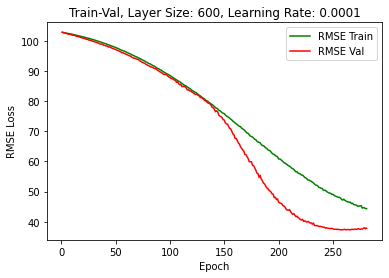

Part_Number_1_model_lr_0.0001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.612958500   Val(RMSE): 101.539849600   Train(MAE),%: 95.631336700   Val(MAE),%: 94.416459400 

Epochs 2   Counter 1   Train(RMSE): 102.287375100   Val(RMSE): 101.137019500   Train(MAE),%: 95.282846500   Val(MAE),%: 94.002349900 

Epochs 3   Counter 1   Train(RMSE): 101.936860800   Val(RMSE): 100.763231300   Train(MAE),%: 94.906705100   Val(MAE),%: 93.547870600 

Epochs 4   Counter 1   Train(RMSE): 101.568258900   Val(RMSE): 100.295266500   Train(MAE),%: 94.518648600   Val(MAE),%: 93.108912800 

Epochs 5   Counter 1   Train(RMSE): 101.128530800   Val(RMSE): 99.780701300   Train(MAE),%: 94.058574200   Val(MAE),%: 92.481372800 

Epochs 6   Counter 1   Train(RMSE): 100.683343000

Epochs 61   Counter 1   Train(RMSE): 42.636972200   Val(RMSE): 41.414171900   Train(MAE),%: 34.012250500   Val(MAE),%: 33.169302600 

Epochs 62   Counter 1   Train(RMSE): 42.381466400   Val(RMSE): 41.364647900   Train(MAE),%: 33.866847000   Val(MAE),%: 33.138951300 

Epochs 63   Counter 1   Train(RMSE): 42.554830300   Val(RMSE): 40.645756100   Train(MAE),%: 33.966376400   Val(MAE),%: 32.534088600 

Epochs 64   Counter 2   Train(RMSE): 42.797161900   Val(RMSE): 40.846491200   Train(MAE),%: 33.999385700   Val(MAE),%: 32.709127300 

Epochs 65   Counter 3   Train(RMSE): 42.325169600   Val(RMSE): 41.170756000   Train(MAE),%: 33.953305300   Val(MAE),%: 32.988676100 

Epochs 66   Counter 4   Train(RMSE): 42.339182000   Val(RMSE): 40.706829100   Train(MAE),%: 33.659235400   Val(MAE),%: 32.621143300 

Epochs 67   Counter 5   Train(RMSE): 42.476886700   Val(RMSE): 40.702309300   Train(MAE),%: 33.887777200   Val(MAE),%: 32.577958400 

Epochs 68   Counter 6   Train(RMSE): 42.338716300   Val(RMSE):

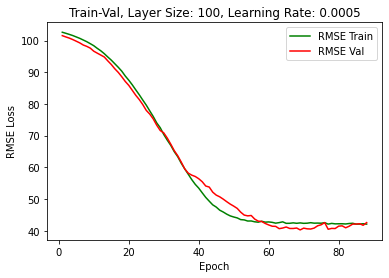

Part_Number_1_model_lr_0.0005_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.969240900   Val(RMSE): 103.004498800   Train(MAE),%: 96.024516900   Val(MAE),%: 95.987496100 

Epochs 2   Counter 1   Train(RMSE): 102.657383100   Val(RMSE): 102.731735200   Train(MAE),%: 95.698547000   Val(MAE),%: 95.710009900 

Epochs 3   Counter 1   Train(RMSE): 102.327305000   Val(RMSE): 102.473955200   Train(MAE),%: 95.344881800   Val(MAE),%: 95.379273700 

Epochs 4   Counter 1   Train(RMSE): 101.997018200   Val(RMSE): 102.030875500   Train(MAE),%: 94.978149400   Val(MAE),%: 94.965537400 

Epochs 5   Counter 1   Train(RMSE): 101.593424300   Val(RMSE): 101.437480300   Train(MAE),%: 94.561973200   Val(MAE),%: 94.254598000 

Epochs 6   Counter 1   Train(RMSE): 101.17143810

Epochs 61   Counter 6   Train(RMSE): 42.241099500   Val(RMSE): 37.166496900   Train(MAE),%: 33.646625200   Val(MAE),%: 29.821251100 

Epochs 62   Counter 7   Train(RMSE): 41.984377000   Val(RMSE): 37.129391700   Train(MAE),%: 33.711437700   Val(MAE),%: 29.761910800 

Epochs 63   Counter 8   Train(RMSE): 42.273443100   Val(RMSE): 37.163369200   Train(MAE),%: 33.569723900   Val(MAE),%: 29.803803600 

Epochs 64   Counter 9   Train(RMSE): 42.130860200   Val(RMSE): 37.266811400   Train(MAE),%: 33.562964100   Val(MAE),%: 29.920327700 

Epochs 65   Counter 10   Train(RMSE): 42.136029900   Val(RMSE): 37.106848100   Train(MAE),%: 33.507919600   Val(MAE),%: 29.799936500 

Epochs 66   Counter 1   Train(RMSE): 41.947260200   Val(RMSE): 37.025685000   Train(MAE),%: 33.467329100   Val(MAE),%: 29.737880500 

Epochs 67   Counter 1   Train(RMSE): 42.130298600   Val(RMSE): 37.002587600   Train(MAE),%: 33.594194800   Val(MAE),%: 29.694237200 

Epochs 68   Counter 2   Train(RMSE): 42.000386900   Val(RMSE)

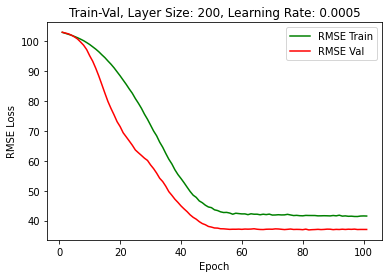

Part_Number_1_model_lr_0.0005_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.906532000   Val(RMSE): 102.995265300   Train(MAE),%: 95.949841700   Val(MAE),%: 95.985540400 

Epochs 2   Counter 1   Train(RMSE): 102.570137400   Val(RMSE): 102.615346300   Train(MAE),%: 95.606419800   Val(MAE),%: 95.597344700 

Epochs 3   Counter 1   Train(RMSE): 102.243173000   Val(RMSE): 102.297690100   Train(MAE),%: 95.238131600   Val(MAE),%: 95.197440500 

Epochs 4   Counter 1   Train(RMSE): 101.913429900   Val(RMSE): 101.974486000   Train(MAE),%: 94.905162300   Val(MAE),%: 94.910181000 

Epochs 5   Counter 1   Train(RMSE): 101.535293600   Val(RMSE): 101.660405500   Train(MAE),%: 94.512687000   Val(MAE),%: 94.499177900 

Epochs 6   Counter 1   Train(RMSE): 101.12990930

Epochs 60   Counter 18   Train(RMSE): 43.035490600   Val(RMSE): 48.311502100   Train(MAE),%: 34.347130500   Val(MAE),%: 39.514877000 

Epochs 61   Counter 19   Train(RMSE): 43.177233700   Val(RMSE): 46.945196800   Train(MAE),%: 34.320077600   Val(MAE),%: 38.275619200 

Epochs 62   Counter 20   Train(RMSE): 42.917075600   Val(RMSE): 49.316103900   Train(MAE),%: 34.365287600   Val(MAE),%: 40.438433000 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


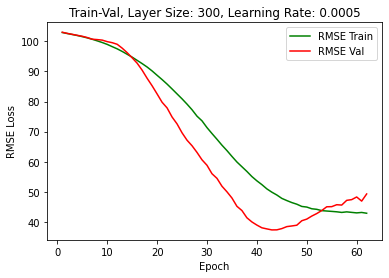

Part_Number_1_model_lr_0.0005_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.337210900   Val(RMSE): 102.639694800   Train(MAE),%: 95.333226400   Val(MAE),%: 95.562814700 

Epochs 2   Counter 1   Train(RMSE): 101.989969700   Val(RMSE): 102.294944800   Train(MAE),%: 94.969973700   Val(MAE),%: 95.200058600 

Epochs 3   Counter 1   Train(RMSE): 101.633488900   Val(RMSE): 102.094080000   Train(MAE),%: 94.574154400   Val(MAE),%: 94.932763400 

Epochs 4   Counter 1   Train(RMSE): 101.244801100   Val(RMSE): 101.713927000   Train(MAE),%: 94.167556100   Val(MAE),%: 94.586050700 

Epochs 5   Counter 1   Train(RMSE): 100.782284600   Val(RMSE): 101.342959700   Train(MAE),%: 93.685412900   Val(MAE),%: 94.112292600 

Epochs 6   Counter 1   Train(RMSE): 100.29865860

Epochs 60   Counter 14   Train(RMSE): 43.640739300   Val(RMSE): 44.834292400   Train(MAE),%: 35.131570200   Val(MAE),%: 36.402696300 

Epochs 61   Counter 15   Train(RMSE): 43.727645700   Val(RMSE): 46.739570300   Train(MAE),%: 34.830630600   Val(MAE),%: 38.123861300 

Epochs 62   Counter 16   Train(RMSE): 43.325662200   Val(RMSE): 47.786496200   Train(MAE),%: 34.740797500   Val(MAE),%: 39.072640400 

Epochs 63   Counter 17   Train(RMSE): 43.603375300   Val(RMSE): 47.834060700   Train(MAE),%: 34.805693100   Val(MAE),%: 39.141540500 

Epochs 64   Counter 18   Train(RMSE): 43.669500900   Val(RMSE): 45.043354000   Train(MAE),%: 35.043102800   Val(MAE),%: 36.589610700 

Epochs 65   Counter 19   Train(RMSE): 43.675468800   Val(RMSE): 47.896457700   Train(MAE),%: 34.985946500   Val(MAE),%: 39.192067800 

Epochs 66   Counter 20   Train(RMSE): 43.550854600   Val(RMSE): 45.145553600   Train(MAE),%: 34.873578100   Val(MAE),%: 36.701587000 

//////////////////////////////////The End /////////////

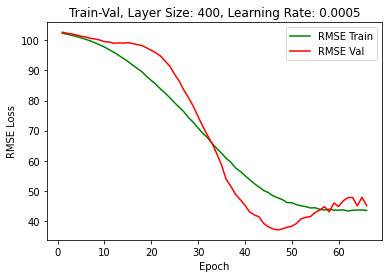

Part_Number_1_model_lr_0.0005_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.815464200   Val(RMSE): 102.897603400   Train(MAE),%: 95.882809200   Val(MAE),%: 95.868761100 

Epochs 2   Counter 1   Train(RMSE): 102.489206400   Val(RMSE): 102.774263400   Train(MAE),%: 95.544079000   Val(MAE),%: 95.751159000 

Epochs 3   Counter 1   Train(RMSE): 102.152886800   Val(RMSE): 102.697071700   Train(MAE),%: 95.188208500   Val(MAE),%: 95.613587100 

Epochs 4   Counter 1   Train(RMSE): 101.798742500   Val(RMSE): 102.526758200   Train(MAE),%: 94.808792100   Val(MAE),%: 95.492089000 

Epochs 5   Counter 1   Train(RMSE): 101.369613000   Val(RMSE): 102.288201000   Train(MAE),%: 94.355886400   Val(MAE),%: 95.162314100 

Epochs 6   Counter 1   Train(RMSE): 100.93454110

Epochs 61   Counter 1   Train(RMSE): 42.424089500   Val(RMSE): 38.205166200   Train(MAE),%: 33.849588600   Val(MAE),%: 30.596534400 

Epochs 62   Counter 2   Train(RMSE): 42.231894600   Val(RMSE): 38.237974500   Train(MAE),%: 33.811487600   Val(MAE),%: 30.610592200 

Epochs 63   Counter 1   Train(RMSE): 42.143032600   Val(RMSE): 38.135541300   Train(MAE),%: 33.599637400   Val(MAE),%: 30.528182700 

Epochs 64   Counter 1   Train(RMSE): 42.328846300   Val(RMSE): 37.933618500   Train(MAE),%: 33.801039800   Val(MAE),%: 30.389569100 

Epochs 65   Counter 2   Train(RMSE): 42.071912400   Val(RMSE): 38.043875400   Train(MAE),%: 33.670635800   Val(MAE),%: 30.505795200 

Epochs 66   Counter 3   Train(RMSE): 42.083799100   Val(RMSE): 37.971104000   Train(MAE),%: 33.631959300   Val(MAE),%: 30.440269000 

Epochs 67   Counter 1   Train(RMSE): 42.095148300   Val(RMSE): 37.673692400   Train(MAE),%: 33.620265000   Val(MAE),%: 30.176176700 

Epochs 68   Counter 1   Train(RMSE): 41.899362800   Val(RMSE):

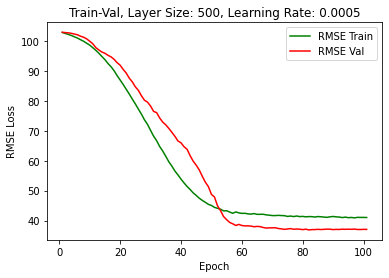

Part_Number_1_model_lr_0.0005_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.905522200   Val(RMSE): 102.745728200   Train(MAE),%: 95.945740100   Val(MAE),%: 95.696681300 

Epochs 2   Counter 1   Train(RMSE): 102.580645000   Val(RMSE): 102.515410100   Train(MAE),%: 95.604226500   Val(MAE),%: 95.462747600 

Epochs 3   Counter 1   Train(RMSE): 102.246757800   Val(RMSE): 102.365442300   Train(MAE),%: 95.252824500   Val(MAE),%: 95.246491800 

Epochs 4   Counter 1   Train(RMSE): 101.896174600   Val(RMSE): 102.083933500   Train(MAE),%: 94.897906800   Val(MAE),%: 95.004539500 

Epochs 5   Counter 1   Train(RMSE): 101.489194100   Val(RMSE): 101.567196500   Train(MAE),%: 94.488837500   Val(MAE),%: 94.378378600 

Epochs 6   Counter 1   Train(RMSE): 101.05501390

Epochs 61   Counter 6   Train(RMSE): 43.521640600   Val(RMSE): 37.334318500   Train(MAE),%: 34.685089300   Val(MAE),%: 29.964189500 

Epochs 62   Counter 7   Train(RMSE): 43.727054800   Val(RMSE): 37.252839700   Train(MAE),%: 34.790947300   Val(MAE),%: 29.854378700 

Epochs 63   Counter 8   Train(RMSE): 43.497693900   Val(RMSE): 37.306626300   Train(MAE),%: 34.888417100   Val(MAE),%: 29.918226100 

Epochs 64   Counter 9   Train(RMSE): 43.537220500   Val(RMSE): 37.463064500   Train(MAE),%: 34.605907800   Val(MAE),%: 30.077493800 

Epochs 65   Counter 10   Train(RMSE): 43.408945800   Val(RMSE): 37.359098400   Train(MAE),%: 34.679524500   Val(MAE),%: 30.002758000 

Epochs 66   Counter 1   Train(RMSE): 43.161685100   Val(RMSE): 37.067275700   Train(MAE),%: 34.499088500   Val(MAE),%: 29.755188100 

Epochs 67   Counter 1   Train(RMSE): 43.347829200   Val(RMSE): 37.047228500   Train(MAE),%: 34.757301700   Val(MAE),%: 29.709666300 

Epochs 68   Counter 2   Train(RMSE): 43.457891900   Val(RMSE)

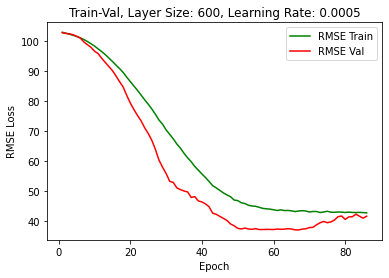

Part_Number_1_model_lr_0.0005_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.666525500   Val(RMSE): 102.583419800   Train(MAE),%: 95.680449800   Val(MAE),%: 95.518712400 

Epochs 2   Counter 1   Train(RMSE): 102.054576400   Val(RMSE): 101.489557900   Train(MAE),%: 95.019867300   Val(MAE),%: 94.343099600 

Epochs 3   Counter 1   Train(RMSE): 101.185810300   Val(RMSE): 99.055944400   Train(MAE),%: 94.074402900   Val(MAE),%: 91.644928000 

Epochs 4   Counter 1   Train(RMSE): 100.044490000   Val(RMSE): 96.962439900   Train(MAE),%: 92.847892800   Val(MAE),%: 89.451091800 

Epochs 5   Counter 1   Train(RMSE): 98.685361800   Val(RMSE): 95.826833700   Train(MAE),%: 91.349001300   Val(MAE),%: 88.174174000 

Epochs 6   Counter 1   Train(RMSE): 97.016534200   V

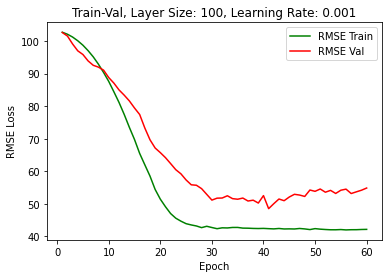

Part_Number_1_model_lr_0.001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.719824700   Val(RMSE): 102.886386900   Train(MAE),%: 95.747644200   Val(MAE),%: 95.858750000 

Epochs 2   Counter 1   Train(RMSE): 102.023406300   Val(RMSE): 102.636242500   Train(MAE),%: 95.023092500   Val(MAE),%: 95.605424900 

Epochs 3   Counter 1   Train(RMSE): 101.214380000   Val(RMSE): 102.336434700   Train(MAE),%: 94.165055000   Val(MAE),%: 95.228876700 

Epochs 4   Counter 1   Train(RMSE): 100.246172000   Val(RMSE): 101.864072800   Train(MAE),%: 93.175958400   Val(MAE),%: 94.785355300 

Epochs 5   Counter 1   Train(RMSE): 99.053694000   Val(RMSE): 101.040904400   Train(MAE),%: 91.963221300   Val(MAE),%: 93.830466600 

Epochs 6   Counter 1   Train(RMSE): 97.576251800  

Epochs 61   Counter 12   Train(RMSE): 40.878853700   Val(RMSE): 56.807001100   Train(MAE),%: 32.886397200   Val(MAE),%: 47.341468800 

Epochs 62   Counter 13   Train(RMSE): 40.789494400   Val(RMSE): 57.447202000   Train(MAE),%: 32.619070100   Val(MAE),%: 47.992119800 

Epochs 63   Counter 14   Train(RMSE): 40.774026100   Val(RMSE): 50.434144000   Train(MAE),%: 32.553955700   Val(MAE),%: 41.198159900 

Epochs 64   Counter 15   Train(RMSE): 40.838359000   Val(RMSE): 55.138772000   Train(MAE),%: 32.610895800   Val(MAE),%: 45.720835400 

Epochs 65   Counter 16   Train(RMSE): 40.815549400   Val(RMSE): 53.839927400   Train(MAE),%: 32.640095800   Val(MAE),%: 44.465710000 

Epochs 66   Counter 17   Train(RMSE): 40.664169300   Val(RMSE): 52.876936300   Train(MAE),%: 32.391194100   Val(MAE),%: 43.554262500 

Epochs 67   Counter 18   Train(RMSE): 40.770769400   Val(RMSE): 47.133863100   Train(MAE),%: 32.594017100   Val(MAE),%: 38.193393100 

Epochs 68   Counter 19   Train(RMSE): 40.775009200   Va

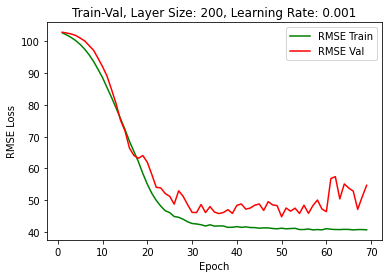

Part_Number_1_model_lr_0.001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.715454800   Val(RMSE): 102.626158400   Train(MAE),%: 95.737765400   Val(MAE),%: 95.590238600 

Epochs 2   Counter 1   Train(RMSE): 102.050442200   Val(RMSE): 101.017917000   Train(MAE),%: 95.053243600   Val(MAE),%: 93.903467200 

Epochs 3   Counter 1   Train(RMSE): 101.237015100   Val(RMSE): 97.913316100   Train(MAE),%: 94.160522100   Val(MAE),%: 90.532227200 

Epochs 4   Counter 1   Train(RMSE): 100.230316800   Val(RMSE): 95.210899400   Train(MAE),%: 93.069891900   Val(MAE),%: 87.695472700 

Epochs 5   Counter 1   Train(RMSE): 98.957300600   Val(RMSE): 92.984183600   Train(MAE),%: 91.741369800   Val(MAE),%: 85.241667400 

Epochs 6   Counter 1   Train(RMSE): 97.522311700   Va

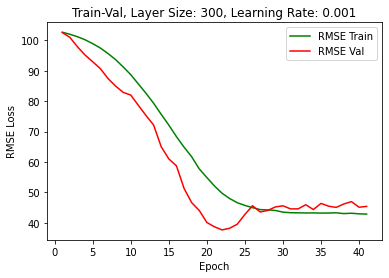

Part_Number_1_model_lr_0.001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.144641000   Val(RMSE): 101.116425200   Train(MAE),%: 95.117178900   Val(MAE),%: 94.008921900 

Epochs 2   Counter 1   Train(RMSE): 101.396067400   Val(RMSE): 97.729052900   Train(MAE),%: 94.338490700   Val(MAE),%: 90.421382300 

Epochs 3   Counter 1   Train(RMSE): 100.478960500   Val(RMSE): 94.022262600   Train(MAE),%: 93.363045700   Val(MAE),%: 86.394177100 

Epochs 4   Counter 1   Train(RMSE): 99.360193000   Val(RMSE): 89.897712700   Train(MAE),%: 92.159367100   Val(MAE),%: 82.039612500 

Epochs 5   Counter 1   Train(RMSE): 97.893732500   Val(RMSE): 85.453416200   Train(MAE),%: 90.622208000   Val(MAE),%: 77.214467400 

Epochs 6   Counter 1   Train(RMSE): 96.139336300   Val(

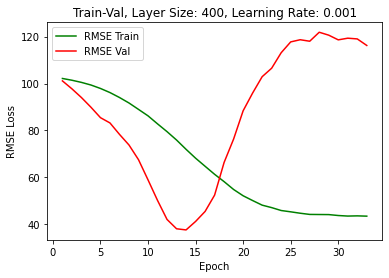

Part_Number_1_model_lr_0.001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.663896600   Val(RMSE): 102.583881400   Train(MAE),%: 95.679385300   Val(MAE),%: 95.516634000 

Epochs 2   Counter 1   Train(RMSE): 101.991961900   Val(RMSE): 102.010843300   Train(MAE),%: 94.958657000   Val(MAE),%: 94.917078000 

Epochs 3   Counter 1   Train(RMSE): 101.202679500   Val(RMSE): 101.335349400   Train(MAE),%: 94.108208000   Val(MAE),%: 94.140710200 

Epochs 4   Counter 1   Train(RMSE): 100.229307100   Val(RMSE): 99.672868700   Train(MAE),%: 93.064121100   Val(MAE),%: 92.412141800 

Epochs 5   Counter 1   Train(RMSE): 98.976369100   Val(RMSE): 98.370641100   Train(MAE),%: 91.725569400   Val(MAE),%: 90.938743600 

Epochs 6   Counter 1   Train(RMSE): 97.484121900   V

Epochs 61   Counter 15   Train(RMSE): 42.406982100   Val(RMSE): 38.269458800   Train(MAE),%: 33.964233100   Val(MAE),%: 30.803741100 

Epochs 62   Counter 16   Train(RMSE): 42.205360100   Val(RMSE): 37.945964200   Train(MAE),%: 33.696364200   Val(MAE),%: 30.490631400 

Epochs 63   Counter 17   Train(RMSE): 42.146302900   Val(RMSE): 38.149012900   Train(MAE),%: 33.818967400   Val(MAE),%: 30.679676100 

Epochs 64   Counter 18   Train(RMSE): 42.248718800   Val(RMSE): 37.977011400   Train(MAE),%: 33.655270800   Val(MAE),%: 30.552281200 

Epochs 65   Counter 19   Train(RMSE): 42.115290800   Val(RMSE): 38.237660700   Train(MAE),%: 33.833691000   Val(MAE),%: 30.772654500 

Epochs 66   Counter 20   Train(RMSE): 42.213245200   Val(RMSE): 37.626342800   Train(MAE),%: 33.704823400   Val(MAE),%: 30.274304200 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


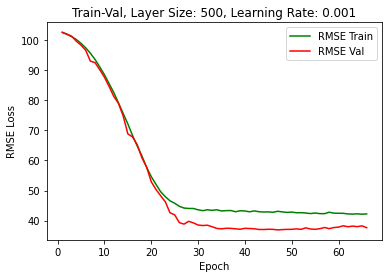

Part_Number_1_model_lr_0.001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.661309000   Val(RMSE): 102.022042000   Train(MAE),%: 95.694174700   Val(MAE),%: 94.929544400 

Epochs 2   Counter 1   Train(RMSE): 101.924372100   Val(RMSE): 100.639913600   Train(MAE),%: 94.944187300   Val(MAE),%: 93.444466300 

Epochs 3   Counter 1   Train(RMSE): 101.084724100   Val(RMSE): 98.820667300   Train(MAE),%: 94.048041600   Val(MAE),%: 91.448978400 

Epochs 4   Counter 1   Train(RMSE): 100.056023300   Val(RMSE): 97.038862200   Train(MAE),%: 92.945698000   Val(MAE),%: 89.610265100 

Epochs 5   Counter 1   Train(RMSE): 98.737248600   Val(RMSE): 95.469011300   Train(MAE),%: 91.533847600   Val(MAE),%: 87.864105900 

Epochs 6   Counter 1   Train(RMSE): 97.217113300   Va

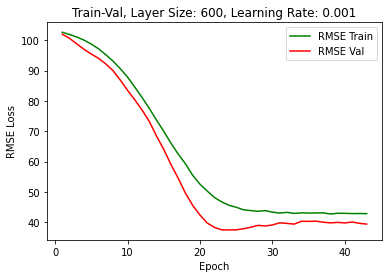

Part_Number_1_model_lr_0.001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 99.301698400   Val(RMSE): 91.583581300   Train(MAE),%: 91.936596400   Val(MAE),%: 83.628451000 

Epochs 2   Counter 1   Train(RMSE): 80.103359100   Val(RMSE): 51.790161500   Train(MAE),%: 70.812286000   Val(MAE),%: 42.507715500 

Epochs 3   Counter 1   Train(RMSE): 49.321415400   Val(RMSE): 37.820604600   Train(MAE),%: 39.836055100   Val(MAE),%: 30.356480100 

Epochs 4   Counter 1   Train(RMSE): 43.047385000   Val(RMSE): 37.052359300   Train(MAE),%: 34.659367300   Val(MAE),%: 29.734018600 

Epochs 5   Counter 2   Train(RMSE): 42.739760400   Val(RMSE): 37.293684300   Train(MAE),%: 34.166694100   Val(MAE),%: 29.931972200 

Epochs 6   Counter 3   Train(RMSE): 42.398576000   Val(RMSE

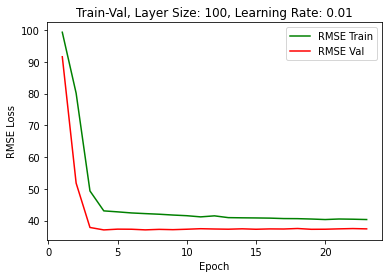

Part_Number_1_model_lr_0.01_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.564284300   Val(RMSE): 89.805164300   Train(MAE),%: 91.089057600   Val(MAE),%: 81.858888000 

Epochs 2   Counter 1   Train(RMSE): 77.941143400   Val(RMSE): 55.974958700   Train(MAE),%: 68.347797700   Val(MAE),%: 46.600697200 

Epochs 3   Counter 1   Train(RMSE): 49.171723700   Val(RMSE): 37.238308600   Train(MAE),%: 39.659149500   Val(MAE),%: 29.869158400 

Epochs 4   Counter 1   Train(RMSE): 43.990050300   Val(RMSE): 36.968826600   Train(MAE),%: 35.224585500   Val(MAE),%: 29.672287500 

Epochs 5   Counter 2   Train(RMSE): 43.518123600   Val(RMSE): 37.125879600   Train(MAE),%: 34.845432300   Val(MAE),%: 29.792941400 

Epochs 6   Counter 3   Train(RMSE): 42.987448000   Val(RMSE)

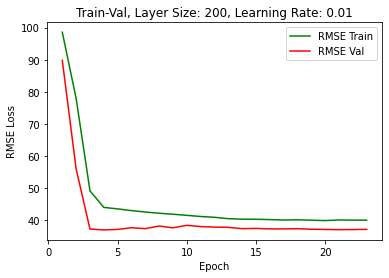

Part_Number_1_model_lr_0.01_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.487487100   Val(RMSE): 93.348896700   Train(MAE),%: 90.996938300   Val(MAE),%: 85.644517300 

Epochs 2   Counter 1   Train(RMSE): 77.194677100   Val(RMSE): 47.205143600   Train(MAE),%: 67.627015000   Val(MAE),%: 38.297521000 

Epochs 3   Counter 1   Train(RMSE): 48.539002100   Val(RMSE): 41.789439200   Train(MAE),%: 38.744184200   Val(MAE),%: 33.649327900 

Epochs 4   Counter 1   Train(RMSE): 43.810120100   Val(RMSE): 38.878960900   Train(MAE),%: 35.155486200   Val(MAE),%: 31.243561300 

Epochs 5   Counter 2   Train(RMSE): 43.305148100   Val(RMSE): 40.168296200   Train(MAE),%: 34.685468400   Val(MAE),%: 32.301919800 

Epochs 6   Counter 1   Train(RMSE): 42.516479000   Val(RMSE)

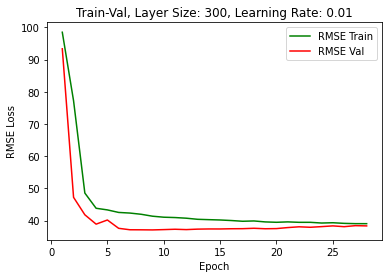

Part_Number_1_model_lr_0.01_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.970473600   Val(RMSE): 83.995947500   Train(MAE),%: 91.526614300   Val(MAE),%: 75.642860400 

Epochs 2   Counter 1   Train(RMSE): 78.367672600   Val(RMSE): 38.243825300   Train(MAE),%: 68.726014000   Val(MAE),%: 30.635594500 

Epochs 3   Counter 2   Train(RMSE): 48.834279400   Val(RMSE): 69.868584300   Train(MAE),%: 39.091814800   Val(MAE),%: 61.005876900 

Epochs 4   Counter 3   Train(RMSE): 43.570754800   Val(RMSE): 60.606264400   Train(MAE),%: 35.069162900   Val(MAE),%: 51.481159500 

Epochs 5   Counter 4   Train(RMSE): 43.210039400   Val(RMSE): 50.510764400   Train(MAE),%: 34.398178400   Val(MAE),%: 41.603310300 

Epochs 6   Counter 5   Train(RMSE): 42.822934000   Val(RMSE)

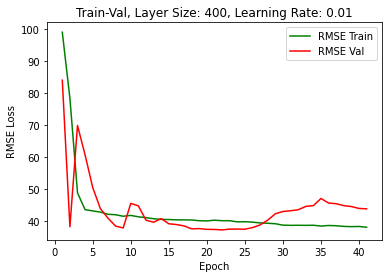

Part_Number_1_model_lr_0.01_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
119
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 97.771558300   Val(RMSE): 92.658357600   Train(MAE),%: 90.164040300   Val(MAE),%: 84.902163800 

Epochs 2   Counter 1   Train(RMSE): 75.875212600   Val(RMSE): 61.888529800   Train(MAE),%: 66.277019200   Val(MAE),%: 52.487159700 

Epochs 3   Counter 1   Train(RMSE): 48.522297900   Val(RMSE): 38.946185400   Train(MAE),%: 38.863578000   Val(MAE),%: 31.195767700 

Epochs 4   Counter 2   Train(RMSE): 44.195522300   Val(RMSE): 39.821687700   Train(MAE),%: 35.317223800   Val(MAE),%: 31.925055500 

Epochs 5   Counter 3   Train(RMSE): 43.580589000   Val(RMSE): 39.322751400   Train(MAE),%: 34.948260400   Val(MAE),%: 31.504902000 

Epochs 6   Counter 4   Train(RMSE): 43.077384500   Val(RMSE)

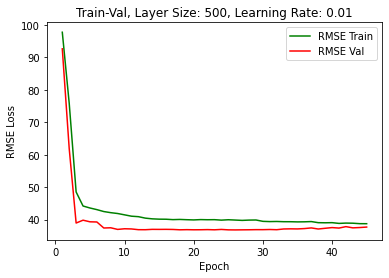

Part_Number_1_model_lr_0.01_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 97.973743300   Val(RMSE): 92.920643500   Train(MAE),%: 90.395552600   Val(MAE),%: 85.141764300 

Epochs 2   Counter 1   Train(RMSE): 75.946983500   Val(RMSE): 65.324444500   Train(MAE),%: 66.226251000   Val(MAE),%: 55.953990300 

Epochs 3   Counter 1   Train(RMSE): 48.054041500   Val(RMSE): 40.641836500   Train(MAE),%: 38.557264400   Val(MAE),%: 32.452176300 

Epochs 4   Counter 2   Train(RMSE): 43.384398900   Val(RMSE): 40.928541200   Train(MAE),%: 34.590141000   Val(MAE),%: 32.635166600 

Epochs 5   Counter 1   Train(RMSE): 42.744633200   Val(RMSE): 38.796712200   Train(MAE),%: 34.173140200   Val(MAE),%: 30.981862900 

Epochs 6   Counter 1   Train(RMSE): 42.235405800   Val(RMSE)

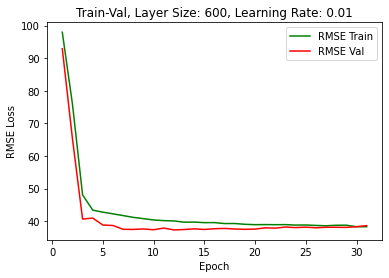

Part_Number_1_model_lr_0.01_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
CV part number:	 2
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.921846800   Val(RMSE): 103.354162200   Train(MAE),%: 95.930132000   Val(MAE),%: 96.427417100 

Epochs 2   Counter 1   Train(RMSE): 102.847059800   Val(RMSE): 103.300993600   Train(MAE),%: 95.855632900   Val(MAE),%: 96.349628400 

Epochs 3   Counter 1   Train(RMSE): 102.790460700   Val(RMSE): 103.203461300   Train(MAE),%: 95.776394100   Val(MAE),%: 96.274419100 

Epochs 4   Counter 2   Train(RMSE): 102.749497800   Val(RMSE): 103.228602100   Train(MAE),%: 95.724363200   Val(MAE),%: 96.279677700 

Epochs 5   Counter 3   Train(RMSE): 102.679889200   Val(RMSE): 103.210196800   Train(MAE),%: 95.673600900   Val(MAE),%: 96.248809800 

Epochs 6   Counter 1   Train(RM

Epochs 60   Counter 2   Train(RMSE): 96.866959300   Val(RMSE): 97.926064800   Train(MAE),%: 89.502499800   Val(MAE),%: 90.637404100 

Epochs 61   Counter 1   Train(RMSE): 96.751212100   Val(RMSE): 97.420876800   Train(MAE),%: 89.321098700   Val(MAE),%: 90.072893100 

Epochs 62   Counter 1   Train(RMSE): 96.571571400   Val(RMSE): 97.369928400   Train(MAE),%: 89.183962600   Val(MAE),%: 90.079453200 

Epochs 63   Counter 1   Train(RMSE): 96.434244600   Val(RMSE): 97.324155800   Train(MAE),%: 88.999358500   Val(MAE),%: 90.001030000 

Epochs 64   Counter 1   Train(RMSE): 96.321733200   Val(RMSE): 96.982188500   Train(MAE),%: 88.788913900   Val(MAE),%: 89.645305000 

Epochs 65   Counter 1   Train(RMSE): 96.138106300   Val(RMSE): 96.738717400   Train(MAE),%: 88.697695900   Val(MAE),%: 89.382465400 

Epochs 66   Counter 1   Train(RMSE): 95.953830900   Val(RMSE): 96.383397400   Train(MAE),%: 88.402629400   Val(MAE),%: 89.019936900 

Epochs 67   Counter 1   Train(RMSE): 95.793273600   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 84.231903100   Val(RMSE): 81.105205500   Train(MAE),%: 76.024224300   Val(MAE),%: 72.629979500 

Epochs 122   Counter 1   Train(RMSE): 84.002933000   Val(RMSE): 80.804861100   Train(MAE),%: 75.667877200   Val(MAE),%: 72.272779500 

Epochs 123   Counter 1   Train(RMSE): 83.722548400   Val(RMSE): 80.507219300   Train(MAE),%: 75.403561500   Val(MAE),%: 72.025856700 

Epochs 124   Counter 2   Train(RMSE): 83.603790900   Val(RMSE): 80.515422200   Train(MAE),%: 75.110146600   Val(MAE),%: 72.023482000 

Epochs 125   Counter 1   Train(RMSE): 83.098846800   Val(RMSE): 80.053780900   Train(MAE),%: 74.875703900   Val(MAE),%: 71.553276100 

Epochs 126   Counter 1   Train(RMSE): 82.973830500   Val(RMSE): 79.334166800   Train(MAE),%: 74.461632800   Val(MAE),%: 70.740631100 

Epochs 127   Counter 1   Train(RMSE): 82.693071800   Val(RMSE): 79.126191500   Train(MAE),%: 74.292272200   Val(MAE),%: 70.542005500 

Epochs 128   Counter 1   Train(RMSE): 82.528568100   Va

Epochs 182   Counter 1   Train(RMSE): 67.420813900   Val(RMSE): 61.079867400   Train(MAE),%: 57.740428300   Val(MAE),%: 51.720708500 

Epochs 183   Counter 1   Train(RMSE): 66.935986400   Val(RMSE): 60.983399700   Train(MAE),%: 57.158393000   Val(MAE),%: 51.571576800 

Epochs 184   Counter 1   Train(RMSE): 66.786196500   Val(RMSE): 60.382339800   Train(MAE),%: 57.154827300   Val(MAE),%: 50.974260000 

Epochs 185   Counter 1   Train(RMSE): 66.335714900   Val(RMSE): 60.253430400   Train(MAE),%: 56.817725600   Val(MAE),%: 50.798920900 

Epochs 186   Counter 1   Train(RMSE): 66.219623400   Val(RMSE): 60.023250900   Train(MAE),%: 56.274287700   Val(MAE),%: 50.594385100 

Epochs 187   Counter 1   Train(RMSE): 65.845508100   Val(RMSE): 59.762514400   Train(MAE),%: 56.142278800   Val(MAE),%: 50.328900700 

Epochs 188   Counter 1   Train(RMSE): 65.474503700   Val(RMSE): 59.267153400   Train(MAE),%: 55.672968500   Val(MAE),%: 49.874991100 

Epochs 189   Counter 1   Train(RMSE): 65.299481400   Va

Epochs 243   Counter 1   Train(RMSE): 50.912717600   Val(RMSE): 44.668538700   Train(MAE),%: 41.414264500   Val(MAE),%: 35.985315300 

Epochs 244   Counter 1   Train(RMSE): 50.534584400   Val(RMSE): 44.317259800   Train(MAE),%: 40.993527500   Val(MAE),%: 35.669841400 

Epochs 245   Counter 1   Train(RMSE): 50.161101600   Val(RMSE): 44.095620200   Train(MAE),%: 40.785559400   Val(MAE),%: 35.459702500 

Epochs 246   Counter 1   Train(RMSE): 50.023570000   Val(RMSE): 44.056291900   Train(MAE),%: 40.562709600   Val(MAE),%: 35.436974200 

Epochs 247   Counter 2   Train(RMSE): 49.904578700   Val(RMSE): 44.076973000   Train(MAE),%: 40.656651500   Val(MAE),%: 35.454678900 

Epochs 248   Counter 1   Train(RMSE): 49.910919400   Val(RMSE): 43.459322000   Train(MAE),%: 40.413758300   Val(MAE),%: 34.930346800 

Epochs 249   Counter 1   Train(RMSE): 49.420671700   Val(RMSE): 43.428994200   Train(MAE),%: 40.086495400   Val(MAE),%: 34.921099000 

Epochs 250   Counter 1   Train(RMSE): 49.516280800   Va

Epochs 304   Counter 1   Train(RMSE): 43.045129200   Val(RMSE): 37.405022000   Train(MAE),%: 34.395502200   Val(MAE),%: 29.924058900 

Epochs 305   Counter 2   Train(RMSE): 42.923842200   Val(RMSE): 37.475472500   Train(MAE),%: 34.406969700   Val(MAE),%: 29.975271100 

Epochs 306   Counter 3   Train(RMSE): 43.097433500   Val(RMSE): 37.494767200   Train(MAE),%: 34.446812500   Val(MAE),%: 29.992919400 

Epochs 307   Counter 4   Train(RMSE): 43.169385200   Val(RMSE): 37.467086800   Train(MAE),%: 34.272359300   Val(MAE),%: 29.969262800 

Epochs 308   Counter 1   Train(RMSE): 42.950928400   Val(RMSE): 37.393917700   Train(MAE),%: 34.476120300   Val(MAE),%: 29.931822000 

Epochs 309   Counter 2   Train(RMSE): 43.010109900   Val(RMSE): 37.414171200   Train(MAE),%: 34.256291300   Val(MAE),%: 29.960741000 

Epochs 310   Counter 3   Train(RMSE): 42.792297000   Val(RMSE): 37.408454600   Train(MAE),%: 34.503951000   Val(MAE),%: 29.932284200 

Epochs 311   Counter 1   Train(RMSE): 42.769757300   Va

Epochs 365   Counter 19   Train(RMSE): 42.326465900   Val(RMSE): 36.945988300   Train(MAE),%: 33.885195900   Val(MAE),%: 29.615356100 

Epochs 366   Counter 20   Train(RMSE): 42.372593100   Val(RMSE): 36.914435400   Train(MAE),%: 33.622072600   Val(MAE),%: 29.574377200 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


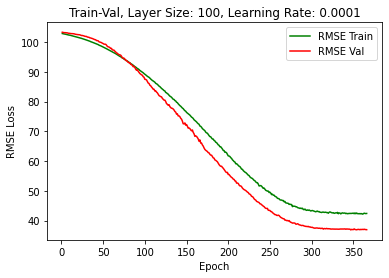

Part_Number_2_model_lr_0.0001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.779653800   Val(RMSE): 102.848552100   Train(MAE),%: 95.775546200   Val(MAE),%: 95.895497600 

Epochs 2   Counter 1   Train(RMSE): 102.698491300   Val(RMSE): 102.799308800   Train(MAE),%: 95.680947700   Val(MAE),%: 95.822478000 

Epochs 3   Counter 1   Train(RMSE): 102.624676200   Val(RMSE): 102.689415600   Train(MAE),%: 95.615398600   Val(MAE),%: 95.734916100 

Epochs 4   Counter 2   Train(RMSE): 102.576768000   Val(RMSE): 102.695158600   Train(MAE),%: 95.556982600   Val(MAE),%: 95.718860600 

Epochs 5   Counter 1   Train(RMSE): 102.501747800   Val(RMSE): 102.665090600   Train(MAE),%: 95.478564100   Val(MAE),%: 95.675212900 

Epochs 6   Counter 1   Train(RMSE): 102.43834980

Epochs 60   Counter 1   Train(RMSE): 96.931871500   Val(RMSE): 93.670332600   Train(MAE),%: 89.554439700   Val(MAE),%: 86.097220700 

Epochs 61   Counter 1   Train(RMSE): 96.763488800   Val(RMSE): 93.257871600   Train(MAE),%: 89.371015100   Val(MAE),%: 85.633341500 

Epochs 62   Counter 1   Train(RMSE): 96.612841100   Val(RMSE): 93.093527500   Train(MAE),%: 89.181310200   Val(MAE),%: 85.519066500 

Epochs 63   Counter 1   Train(RMSE): 96.431901700   Val(RMSE): 92.706099200   Train(MAE),%: 89.022344200   Val(MAE),%: 85.075405100 

Epochs 64   Counter 1   Train(RMSE): 96.333455000   Val(RMSE): 92.384218200   Train(MAE),%: 88.837368200   Val(MAE),%: 84.738292700 

Epochs 65   Counter 1   Train(RMSE): 96.121306000   Val(RMSE): 91.989219700   Train(MAE),%: 88.725892800   Val(MAE),%: 84.311395600 

Epochs 66   Counter 1   Train(RMSE): 95.969238300   Val(RMSE): 91.676406200   Train(MAE),%: 88.515400400   Val(MAE),%: 83.997233700 

Epochs 67   Counter 1   Train(RMSE): 95.846522100   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 84.641761800   Val(RMSE): 73.155981700   Train(MAE),%: 76.308508800   Val(MAE),%: 64.185622500 

Epochs 122   Counter 1   Train(RMSE): 84.387716900   Val(RMSE): 72.940203300   Train(MAE),%: 76.120312600   Val(MAE),%: 63.914816200 

Epochs 123   Counter 1   Train(RMSE): 84.126456600   Val(RMSE): 72.458094900   Train(MAE),%: 75.799527000   Val(MAE),%: 63.479204200 

Epochs 124   Counter 1   Train(RMSE): 83.976671300   Val(RMSE): 72.297002200   Train(MAE),%: 75.505822200   Val(MAE),%: 63.295098000 

Epochs 125   Counter 1   Train(RMSE): 83.610044400   Val(RMSE): 71.979272200   Train(MAE),%: 75.228311000   Val(MAE),%: 62.977278700 

Epochs 126   Counter 1   Train(RMSE): 83.407778200   Val(RMSE): 71.737621900   Train(MAE),%: 74.873750100   Val(MAE),%: 62.692361200 

Epochs 127   Counter 1   Train(RMSE): 83.074076800   Val(RMSE): 71.571788200   Train(MAE),%: 74.581634500   Val(MAE),%: 62.526651400 

Epochs 128   Counter 1   Train(RMSE): 82.941732300   Va

Epochs 182   Counter 1   Train(RMSE): 67.400113000   Val(RMSE): 58.771479000   Train(MAE),%: 57.936539700   Val(MAE),%: 49.386047000 

Epochs 183   Counter 1   Train(RMSE): 67.244683600   Val(RMSE): 58.545604100   Train(MAE),%: 57.553033100   Val(MAE),%: 49.098114600 

Epochs 184   Counter 1   Train(RMSE): 66.897714000   Val(RMSE): 58.208858500   Train(MAE),%: 57.233746900   Val(MAE),%: 48.778588000 

Epochs 185   Counter 1   Train(RMSE): 66.588722900   Val(RMSE): 58.136635100   Train(MAE),%: 56.896726900   Val(MAE),%: 48.669307100 

Epochs 186   Counter 1   Train(RMSE): 66.366299200   Val(RMSE): 57.786681500   Train(MAE),%: 56.602149500   Val(MAE),%: 48.338530500 

Epochs 187   Counter 1   Train(RMSE): 66.017128300   Val(RMSE): 57.711074800   Train(MAE),%: 56.335253500   Val(MAE),%: 48.267448400 

Epochs 188   Counter 1   Train(RMSE): 65.699815800   Val(RMSE): 57.219403300   Train(MAE),%: 55.825600500   Val(MAE),%: 47.819181400 

Epochs 189   Counter 1   Train(RMSE): 65.475719600   Va

Epochs 243   Counter 1   Train(RMSE): 50.491204100   Val(RMSE): 45.501172400   Train(MAE),%: 41.062019300   Val(MAE),%: 36.734863900 

Epochs 244   Counter 1   Train(RMSE): 50.260627100   Val(RMSE): 45.309753700   Train(MAE),%: 40.830328900   Val(MAE),%: 36.557376500 

Epochs 245   Counter 1   Train(RMSE): 49.964268200   Val(RMSE): 45.154334400   Train(MAE),%: 40.508736500   Val(MAE),%: 36.416738200 

Epochs 246   Counter 1   Train(RMSE): 49.634089300   Val(RMSE): 44.809138600   Train(MAE),%: 40.382718000   Val(MAE),%: 36.123154600 

Epochs 247   Counter 1   Train(RMSE): 49.593027200   Val(RMSE): 44.775621400   Train(MAE),%: 40.319655900   Val(MAE),%: 36.083133400 

Epochs 248   Counter 1   Train(RMSE): 49.594034300   Val(RMSE): 44.426730800   Train(MAE),%: 40.225392500   Val(MAE),%: 35.793290100 

Epochs 249   Counter 1   Train(RMSE): 49.150466800   Val(RMSE): 44.193162000   Train(MAE),%: 39.849307200   Val(MAE),%: 35.603475600 

Epochs 250   Counter 2   Train(RMSE): 49.067943200   Va

Epochs 304   Counter 1   Train(RMSE): 42.566192000   Val(RMSE): 38.091873800   Train(MAE),%: 34.015581700   Val(MAE),%: 30.470982200 

Epochs 305   Counter 2   Train(RMSE): 42.577361400   Val(RMSE): 38.277660400   Train(MAE),%: 34.074912700   Val(MAE),%: 30.617730300 

Epochs 306   Counter 3   Train(RMSE): 42.546338600   Val(RMSE): 38.163307800   Train(MAE),%: 34.008843000   Val(MAE),%: 30.533666300 

Epochs 307   Counter 4   Train(RMSE): 42.505285000   Val(RMSE): 38.137791600   Train(MAE),%: 33.824500000   Val(MAE),%: 30.501920200 

Epochs 308   Counter 1   Train(RMSE): 42.380498100   Val(RMSE): 38.070389700   Train(MAE),%: 34.066453200   Val(MAE),%: 30.472506500 

Epochs 309   Counter 1   Train(RMSE): 42.398560900   Val(RMSE): 37.971277200   Train(MAE),%: 33.895521900   Val(MAE),%: 30.388904900 

Epochs 310   Counter 1   Train(RMSE): 42.232465200   Val(RMSE): 37.969454100   Train(MAE),%: 34.036044600   Val(MAE),%: 30.389247700 

Epochs 311   Counter 1   Train(RMSE): 42.253242700   Va

Epochs 365   Counter 19   Train(RMSE): 41.641998500   Val(RMSE): 37.144012100   Train(MAE),%: 33.443161300   Val(MAE),%: 29.756797200 

Epochs 366   Counter 20   Train(RMSE): 41.872075300   Val(RMSE): 37.140247300   Train(MAE),%: 33.244652600   Val(MAE),%: 29.733923300 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


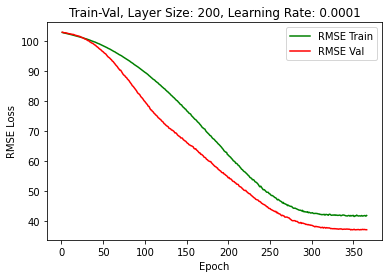

Part_Number_2_model_lr_0.0001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.784493500   Val(RMSE): 103.022275900   Train(MAE),%: 95.773272600   Val(MAE),%: 96.071300500 

Epochs 2   Counter 1   Train(RMSE): 102.698192400   Val(RMSE): 102.979215000   Train(MAE),%: 95.687873800   Val(MAE),%: 96.004948300 

Epochs 3   Counter 1   Train(RMSE): 102.625621600   Val(RMSE): 102.902343800   Train(MAE),%: 95.610386100   Val(MAE),%: 95.951561000 

Epochs 4   Counter 2   Train(RMSE): 102.570973900   Val(RMSE): 102.949531600   Train(MAE),%: 95.536596500   Val(MAE),%: 95.980856600 

Epochs 5   Counter 3   Train(RMSE): 102.502689200   Val(RMSE): 102.918195700   Train(MAE),%: 95.489114800   Val(MAE),%: 95.936318100 

Epochs 6   Counter 1   Train(RMSE): 102.44079820

Epochs 60   Counter 1   Train(RMSE): 96.654646200   Val(RMSE): 98.199043300   Train(MAE),%: 89.427548000   Val(MAE),%: 90.933489500 

Epochs 61   Counter 1   Train(RMSE): 96.504068500   Val(RMSE): 97.640323600   Train(MAE),%: 89.205226400   Val(MAE),%: 90.315869600 

Epochs 62   Counter 1   Train(RMSE): 96.339016100   Val(RMSE): 97.615825000   Train(MAE),%: 89.026682300   Val(MAE),%: 90.347396900 

Epochs 63   Counter 1   Train(RMSE): 96.102741100   Val(RMSE): 97.532686200   Train(MAE),%: 88.821020700   Val(MAE),%: 90.229514400 

Epochs 64   Counter 1   Train(RMSE): 95.968777500   Val(RMSE): 97.319663400   Train(MAE),%: 88.633415900   Val(MAE),%: 90.007984200 

Epochs 65   Counter 1   Train(RMSE): 95.748221400   Val(RMSE): 97.049628600   Train(MAE),%: 88.465686300   Val(MAE),%: 89.717306100 

Epochs 66   Counter 1   Train(RMSE): 95.542655600   Val(RMSE): 96.690087000   Train(MAE),%: 88.207268800   Val(MAE),%: 89.351306300 

Epochs 67   Counter 1   Train(RMSE): 95.376052500   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 82.951117500   Val(RMSE): 76.566492100   Train(MAE),%: 74.447889200   Val(MAE),%: 67.799732200 

Epochs 122   Counter 1   Train(RMSE): 82.628559900   Val(RMSE): 76.134563400   Train(MAE),%: 74.144157700   Val(MAE),%: 67.301358500 

Epochs 123   Counter 1   Train(RMSE): 82.480684700   Val(RMSE): 75.666054400   Train(MAE),%: 73.957766000   Val(MAE),%: 66.877883300 

Epochs 124   Counter 1   Train(RMSE): 82.316847800   Val(RMSE): 75.586661000   Train(MAE),%: 73.498924600   Val(MAE),%: 66.780378300 

Epochs 125   Counter 1   Train(RMSE): 81.884447500   Val(RMSE): 75.067965200   Train(MAE),%: 73.212348900   Val(MAE),%: 66.245595900 

Epochs 126   Counter 1   Train(RMSE): 81.775593300   Val(RMSE): 74.774590800   Train(MAE),%: 72.894874600   Val(MAE),%: 65.902123800 

Epochs 127   Counter 1   Train(RMSE): 81.443544100   Val(RMSE): 74.103845000   Train(MAE),%: 72.721149300   Val(MAE),%: 65.205483100 

Epochs 128   Counter 1   Train(RMSE): 81.269600600   Va

Epochs 182   Counter 1   Train(RMSE): 67.038795500   Val(RMSE): 52.531124400   Train(MAE),%: 56.930458700   Val(MAE),%: 43.258613000 

Epochs 183   Counter 2   Train(RMSE): 66.872413300   Val(RMSE): 52.852870000   Train(MAE),%: 56.522124600   Val(MAE),%: 43.508157100 

Epochs 184   Counter 1   Train(RMSE): 66.555175100   Val(RMSE): 51.911431000   Train(MAE),%: 56.475030700   Val(MAE),%: 42.639784500 

Epochs 185   Counter 1   Train(RMSE): 66.284041000   Val(RMSE): 51.754803700   Train(MAE),%: 56.148427700   Val(MAE),%: 42.460143400 

Epochs 186   Counter 1   Train(RMSE): 66.088948500   Val(RMSE): 51.464851100   Train(MAE),%: 55.817250000   Val(MAE),%: 42.180625000 

Epochs 187   Counter 1   Train(RMSE): 65.846915200   Val(RMSE): 51.146548300   Train(MAE),%: 55.613163300   Val(MAE),%: 41.900396000 

Epochs 188   Counter 1   Train(RMSE): 65.433874000   Val(RMSE): 50.672499000   Train(MAE),%: 55.171974300   Val(MAE),%: 41.470102900 

Epochs 189   Counter 2   Train(RMSE): 65.329198800   Va

Epochs 243   Counter 1   Train(RMSE): 53.181951100   Val(RMSE): 38.390357700   Train(MAE),%: 42.925435800   Val(MAE),%: 30.725727600 

Epochs 244   Counter 1   Train(RMSE): 52.742197100   Val(RMSE): 38.278582600   Train(MAE),%: 42.811094400   Val(MAE),%: 30.648447000 

Epochs 245   Counter 1   Train(RMSE): 52.505496500   Val(RMSE): 38.185071000   Train(MAE),%: 42.627965300   Val(MAE),%: 30.555402100 

Epochs 246   Counter 2   Train(RMSE): 52.460298800   Val(RMSE): 38.214469300   Train(MAE),%: 42.424085500   Val(MAE),%: 30.562718100 

Epochs 247   Counter 3   Train(RMSE): 52.542717600   Val(RMSE): 38.199171400   Train(MAE),%: 42.125342800   Val(MAE),%: 30.596105700 

Epochs 248   Counter 1   Train(RMSE): 52.279395200   Val(RMSE): 38.015357700   Train(MAE),%: 42.093459900   Val(MAE),%: 30.444243600 

Epochs 249   Counter 1   Train(RMSE): 51.857771000   Val(RMSE): 37.930515600   Train(MAE),%: 41.874805900   Val(MAE),%: 30.345062700 

Epochs 250   Counter 1   Train(RMSE): 51.975970400   Va

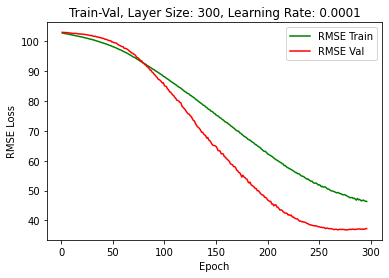

Part_Number_2_model_lr_0.0001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.681616100   Val(RMSE): 102.738596600   Train(MAE),%: 95.657034500   Val(MAE),%: 95.768055600 

Epochs 2   Counter 1   Train(RMSE): 102.594037600   Val(RMSE): 102.645032900   Train(MAE),%: 95.575046000   Val(MAE),%: 95.647686600 

Epochs 3   Counter 1   Train(RMSE): 102.535444200   Val(RMSE): 102.528488800   Train(MAE),%: 95.505937700   Val(MAE),%: 95.551951100 

Epochs 4   Counter 1   Train(RMSE): 102.482700800   Val(RMSE): 102.511217100   Train(MAE),%: 95.451932800   Val(MAE),%: 95.512096400 

Epochs 5   Counter 1   Train(RMSE): 102.417605900   Val(RMSE): 102.423645700   Train(MAE),%: 95.385940600   Val(MAE),%: 95.405957500 

Epochs 6   Counter 1   Train(RMSE): 102.33366990

Epochs 60   Counter 2   Train(RMSE): 95.493864000   Val(RMSE): 92.826491000   Train(MAE),%: 88.151868700   Val(MAE),%: 85.138931900 

Epochs 61   Counter 1   Train(RMSE): 95.362875900   Val(RMSE): 92.675860700   Train(MAE),%: 87.956621600   Val(MAE),%: 84.954467100 

Epochs 62   Counter 1   Train(RMSE): 95.166656500   Val(RMSE): 92.507975300   Train(MAE),%: 87.765076700   Val(MAE),%: 84.837608300 

Epochs 63   Counter 1   Train(RMSE): 94.936552300   Val(RMSE): 92.477042500   Train(MAE),%: 87.580758500   Val(MAE),%: 84.778354600 

Epochs 64   Counter 1   Train(RMSE): 94.821385300   Val(RMSE): 92.177837400   Train(MAE),%: 87.369527700   Val(MAE),%: 84.465175600 

Epochs 65   Counter 1   Train(RMSE): 94.637405700   Val(RMSE): 92.040096900   Train(MAE),%: 87.213960100   Val(MAE),%: 84.319773400 

Epochs 66   Counter 1   Train(RMSE): 94.402797500   Val(RMSE): 91.883621900   Train(MAE),%: 86.914335200   Val(MAE),%: 84.167075500 

Epochs 67   Counter 2   Train(RMSE): 94.251672500   Val(RMSE):

Epochs 121   Counter 16   Train(RMSE): 82.283375600   Val(RMSE): 88.934731800   Train(MAE),%: 73.641991300   Val(MAE),%: 81.015573500 

Epochs 122   Counter 17   Train(RMSE): 82.016090700   Val(RMSE): 88.811730700   Train(MAE),%: 73.374177400   Val(MAE),%: 80.848372100 

Epochs 123   Counter 18   Train(RMSE): 81.767037100   Val(RMSE): 88.561337200   Train(MAE),%: 73.096441500   Val(MAE),%: 80.643743500 

Epochs 124   Counter 19   Train(RMSE): 81.647216800   Val(RMSE): 89.381730400   Train(MAE),%: 72.701798500   Val(MAE),%: 81.512605700 

Epochs 125   Counter 20   Train(RMSE): 81.246755500   Val(RMSE): 88.791648200   Train(MAE),%: 72.365988000   Val(MAE),%: 80.896453900 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


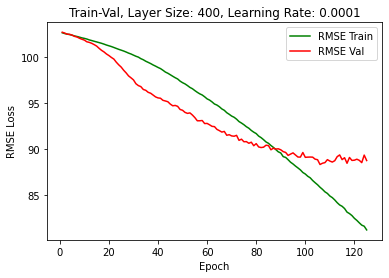

Part_Number_2_model_lr_0.0001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.355153600   Val(RMSE): 102.631931300   Train(MAE),%: 95.311867100   Val(MAE),%: 95.650699000 

Epochs 2   Counter 1   Train(RMSE): 102.267459000   Val(RMSE): 102.558848100   Train(MAE),%: 95.216268800   Val(MAE),%: 95.549573300 

Epochs 3   Counter 1   Train(RMSE): 102.205392300   Val(RMSE): 102.421420400   Train(MAE),%: 95.141696800   Val(MAE),%: 95.432460800 

Epochs 4   Counter 2   Train(RMSE): 102.137698000   Val(RMSE): 102.430619600   Train(MAE),%: 95.078992800   Val(MAE),%: 95.418668100 

Epochs 5   Counter 1   Train(RMSE): 102.085467100   Val(RMSE): 102.358652100   Train(MAE),%: 95.017080200   Val(MAE),%: 95.328116100 

Epochs 6   Counter 1   Train(RMSE): 102.00828490

Epochs 60   Counter 1   Train(RMSE): 95.447762200   Val(RMSE): 88.521413200   Train(MAE),%: 88.102782200   Val(MAE),%: 80.517575600 

Epochs 61   Counter 1   Train(RMSE): 95.288763300   Val(RMSE): 88.049430200   Train(MAE),%: 87.857491500   Val(MAE),%: 79.978936500 

Epochs 62   Counter 1   Train(RMSE): 95.074369000   Val(RMSE): 87.821825000   Train(MAE),%: 87.641060200   Val(MAE),%: 79.809700000 

Epochs 63   Counter 1   Train(RMSE): 94.804327900   Val(RMSE): 87.323336900   Train(MAE),%: 87.405731200   Val(MAE),%: 79.239849100 

Epochs 64   Counter 1   Train(RMSE): 94.643674800   Val(RMSE): 87.099402100   Train(MAE),%: 87.199907400   Val(MAE),%: 79.024246900 

Epochs 65   Counter 1   Train(RMSE): 94.412151800   Val(RMSE): 86.624727200   Train(MAE),%: 86.986293600   Val(MAE),%: 78.505051900 

Epochs 66   Counter 1   Train(RMSE): 94.144116300   Val(RMSE): 86.267322500   Train(MAE),%: 86.726215200   Val(MAE),%: 78.149245600 

Epochs 67   Counter 1   Train(RMSE): 93.980009700   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 80.678407400   Val(RMSE): 69.158488600   Train(MAE),%: 71.983720200   Val(MAE),%: 59.976891800 

Epochs 122   Counter 1   Train(RMSE): 80.371574700   Val(RMSE): 68.888358400   Train(MAE),%: 71.703297800   Val(MAE),%: 59.647127800 

Epochs 123   Counter 1   Train(RMSE): 80.202460900   Val(RMSE): 68.064397200   Train(MAE),%: 71.480225900   Val(MAE),%: 58.859634100 

Epochs 124   Counter 2   Train(RMSE): 80.009568900   Val(RMSE): 68.154822000   Train(MAE),%: 71.074624400   Val(MAE),%: 58.940924600 

Epochs 125   Counter 1   Train(RMSE): 79.580936300   Val(RMSE): 67.414440800   Train(MAE),%: 70.700732700   Val(MAE),%: 58.192811000 

Epochs 126   Counter 1   Train(RMSE): 79.477783200   Val(RMSE): 67.291577700   Train(MAE),%: 70.375444800   Val(MAE),%: 58.031583800 

Epochs 127   Counter 1   Train(RMSE): 79.160591100   Val(RMSE): 66.826880100   Train(MAE),%: 70.202766400   Val(MAE),%: 57.562539700 

Epochs 128   Counter 1   Train(RMSE): 78.970052600   Va

Epochs 182   Counter 1   Train(RMSE): 64.799946800   Val(RMSE): 48.723654400   Train(MAE),%: 54.544236200   Val(MAE),%: 39.666637700 

Epochs 183   Counter 1   Train(RMSE): 64.581946700   Val(RMSE): 48.216592200   Train(MAE),%: 54.147959700   Val(MAE),%: 39.141798300 

Epochs 184   Counter 1   Train(RMSE): 64.279217400   Val(RMSE): 48.178769700   Train(MAE),%: 53.906839600   Val(MAE),%: 39.149271300 

Epochs 185   Counter 1   Train(RMSE): 63.934371100   Val(RMSE): 47.890356400   Train(MAE),%: 53.715701700   Val(MAE),%: 38.859728500 

Epochs 186   Counter 1   Train(RMSE): 63.856100700   Val(RMSE): 47.313935000   Train(MAE),%: 53.486107900   Val(MAE),%: 38.321770000 

Epochs 187   Counter 2   Train(RMSE): 63.712160200   Val(RMSE): 47.329268100   Train(MAE),%: 53.133177100   Val(MAE),%: 38.365415900 

Epochs 188   Counter 1   Train(RMSE): 63.207553700   Val(RMSE): 46.763564100   Train(MAE),%: 52.889062600   Val(MAE),%: 37.850643500 

Epochs 189   Counter 2   Train(RMSE): 63.142992300   Va

Epochs 243   Counter 1   Train(RMSE): 51.810664000   Val(RMSE): 37.188854200   Train(MAE),%: 41.578044900   Val(MAE),%: 29.772357600 

Epochs 244   Counter 2   Train(RMSE): 51.503260600   Val(RMSE): 37.242436400   Train(MAE),%: 41.358033600   Val(MAE),%: 29.832476100 

Epochs 245   Counter 1   Train(RMSE): 51.401349800   Val(RMSE): 37.135433500   Train(MAE),%: 41.365292400   Val(MAE),%: 29.737161200 

Epochs 246   Counter 2   Train(RMSE): 51.148912300   Val(RMSE): 37.142725900   Train(MAE),%: 41.085588400   Val(MAE),%: 29.734293000 

Epochs 247   Counter 3   Train(RMSE): 51.028417700   Val(RMSE): 37.289223700   Train(MAE),%: 40.849742200   Val(MAE),%: 29.887924000 

Epochs 248   Counter 1   Train(RMSE): 51.018823900   Val(RMSE): 37.119772900   Train(MAE),%: 40.982191300   Val(MAE),%: 29.749472600 

Epochs 249   Counter 1   Train(RMSE): 50.545376000   Val(RMSE): 37.048432700   Train(MAE),%: 40.571496100   Val(MAE),%: 29.653178700 

Epochs 250   Counter 2   Train(RMSE): 50.805027200   Va

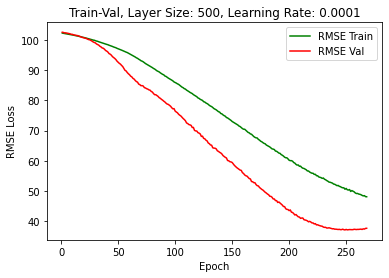

Part_Number_2_model_lr_0.0001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.557347800   Val(RMSE): 102.984516800   Train(MAE),%: 95.550506600   Val(MAE),%: 96.035238300 

Epochs 2   Counter 1   Train(RMSE): 102.480345000   Val(RMSE): 102.931318300   Train(MAE),%: 95.465824300   Val(MAE),%: 95.957062400 

Epochs 3   Counter 1   Train(RMSE): 102.409757500   Val(RMSE): 102.843285200   Train(MAE),%: 95.395189400   Val(MAE),%: 95.891866700 

Epochs 4   Counter 2   Train(RMSE): 102.353184900   Val(RMSE): 102.864824900   Train(MAE),%: 95.333578400   Val(MAE),%: 95.892698900 

Epochs 5   Counter 1   Train(RMSE): 102.291803400   Val(RMSE): 102.829009400   Train(MAE),%: 95.274835700   Val(MAE),%: 95.842038500 

Epochs 6   Counter 1   Train(RMSE): 102.21739100

Epochs 60   Counter 1   Train(RMSE): 95.991669000   Val(RMSE): 95.719867700   Train(MAE),%: 88.771349700   Val(MAE),%: 88.271679600 

Epochs 61   Counter 1   Train(RMSE): 95.878082300   Val(RMSE): 95.117329900   Train(MAE),%: 88.551876600   Val(MAE),%: 87.604431800 

Epochs 62   Counter 1   Train(RMSE): 95.671181700   Val(RMSE): 94.895788200   Train(MAE),%: 88.373288700   Val(MAE),%: 87.430456200 

Epochs 63   Counter 1   Train(RMSE): 95.493097400   Val(RMSE): 94.527879700   Train(MAE),%: 88.189273000   Val(MAE),%: 87.007520700 

Epochs 64   Counter 1   Train(RMSE): 95.368300700   Val(RMSE): 93.917760200   Train(MAE),%: 88.011529700   Val(MAE),%: 86.365784300 

Epochs 65   Counter 1   Train(RMSE): 95.180007900   Val(RMSE): 93.438474000   Train(MAE),%: 87.827458600   Val(MAE),%: 85.851982100 

Epochs 66   Counter 1   Train(RMSE): 94.950401000   Val(RMSE): 93.025404600   Train(MAE),%: 87.607737000   Val(MAE),%: 85.427822100 

Epochs 67   Counter 1   Train(RMSE): 94.816850400   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 81.546212900   Val(RMSE): 69.796489700   Train(MAE),%: 73.002662000   Val(MAE),%: 60.682861000 

Epochs 122   Counter 1   Train(RMSE): 81.371466900   Val(RMSE): 69.322046900   Train(MAE),%: 72.731956500   Val(MAE),%: 60.142486600 

Epochs 123   Counter 1   Train(RMSE): 81.093274000   Val(RMSE): 68.514840400   Train(MAE),%: 72.471794100   Val(MAE),%: 59.371471400 

Epochs 124   Counter 2   Train(RMSE): 80.971725500   Val(RMSE): 68.539819700   Train(MAE),%: 72.127705800   Val(MAE),%: 59.383592300 

Epochs 125   Counter 1   Train(RMSE): 80.497551000   Val(RMSE): 67.921643600   Train(MAE),%: 71.728111600   Val(MAE),%: 58.757970200 

Epochs 126   Counter 1   Train(RMSE): 80.300572900   Val(RMSE): 67.528066600   Train(MAE),%: 71.323769600   Val(MAE),%: 58.318999900 

Epochs 127   Counter 1   Train(RMSE): 80.105846900   Val(RMSE): 67.088682200   Train(MAE),%: 71.189705600   Val(MAE),%: 57.869656200 

Epochs 128   Counter 1   Train(RMSE): 79.853657900   Va

Epochs 182   Counter 1   Train(RMSE): 65.388411500   Val(RMSE): 49.250946400   Train(MAE),%: 54.989249700   Val(MAE),%: 40.158382100 

Epochs 183   Counter 1   Train(RMSE): 65.036510000   Val(RMSE): 48.974235900   Train(MAE),%: 54.941294500   Val(MAE),%: 39.852704700 

Epochs 184   Counter 1   Train(RMSE): 64.688528600   Val(RMSE): 48.748671200   Train(MAE),%: 54.490551200   Val(MAE),%: 39.681085300 

Epochs 185   Counter 1   Train(RMSE): 64.480744600   Val(RMSE): 48.317186000   Train(MAE),%: 54.204261300   Val(MAE),%: 39.258033400 

Epochs 186   Counter 1   Train(RMSE): 64.314511500   Val(RMSE): 47.915136000   Train(MAE),%: 53.914743500   Val(MAE),%: 38.872212100 

Epochs 187   Counter 2   Train(RMSE): 64.105120300   Val(RMSE): 48.014037500   Train(MAE),%: 53.758684700   Val(MAE),%: 38.993206000 

Epochs 188   Counter 1   Train(RMSE): 63.752420300   Val(RMSE): 47.683095900   Train(MAE),%: 53.363922600   Val(MAE),%: 38.691172000 

Epochs 189   Counter 1   Train(RMSE): 63.521197300   Va

Epochs 243   Counter 1   Train(RMSE): 51.214670400   Val(RMSE): 38.474498400   Train(MAE),%: 41.438545600   Val(MAE),%: 30.771402200 

Epochs 244   Counter 1   Train(RMSE): 51.046818400   Val(RMSE): 38.384455700   Train(MAE),%: 41.161640200   Val(MAE),%: 30.714348600 

Epochs 245   Counter 1   Train(RMSE): 50.795425700   Val(RMSE): 38.233968700   Train(MAE),%: 40.867845300   Val(MAE),%: 30.574660800 

Epochs 246   Counter 2   Train(RMSE): 50.677312800   Val(RMSE): 38.386170400   Train(MAE),%: 40.725797700   Val(MAE),%: 30.683013600 

Epochs 247   Counter 3   Train(RMSE): 50.350978500   Val(RMSE): 38.409945200   Train(MAE),%: 40.700190500   Val(MAE),%: 30.745036400 

Epochs 248   Counter 1   Train(RMSE): 50.561727800   Val(RMSE): 38.158881200   Train(MAE),%: 40.780105300   Val(MAE),%: 30.537656800 

Epochs 249   Counter 1   Train(RMSE): 50.050671800   Val(RMSE): 38.142545400   Train(MAE),%: 40.316138600   Val(MAE),%: 30.495535500 

Epochs 250   Counter 1   Train(RMSE): 50.019997800   Va

Epochs 304   Counter 12   Train(RMSE): 44.470368900   Val(RMSE): 36.856642100   Train(MAE),%: 35.313144200   Val(MAE),%: 29.586286400 

Epochs 305   Counter 13   Train(RMSE): 44.452865600   Val(RMSE): 36.929622000   Train(MAE),%: 35.341824400   Val(MAE),%: 29.594113300 

Epochs 306   Counter 14   Train(RMSE): 44.370950600   Val(RMSE): 36.904864300   Train(MAE),%: 35.576433300   Val(MAE),%: 29.600353100 

Epochs 307   Counter 15   Train(RMSE): 44.374622300   Val(RMSE): 36.933473600   Train(MAE),%: 35.253780400   Val(MAE),%: 29.613277400 

Epochs 308   Counter 16   Train(RMSE): 44.336971300   Val(RMSE): 37.013225200   Train(MAE),%: 35.504197500   Val(MAE),%: 29.712129800 

Epochs 309   Counter 17   Train(RMSE): 44.281515000   Val(RMSE): 36.992348400   Train(MAE),%: 35.323850700   Val(MAE),%: 29.714755900 

Epochs 310   Counter 18   Train(RMSE): 43.958194900   Val(RMSE): 37.044580100   Train(MAE),%: 35.364145900   Val(MAE),%: 29.723594300 

Epochs 311   Counter 19   Train(RMSE): 44.108384

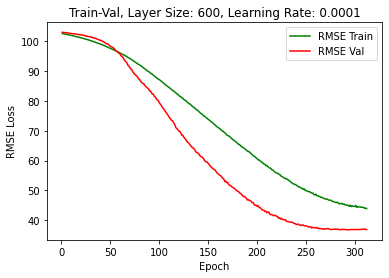

Part_Number_2_model_lr_0.0001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.443386900   Val(RMSE): 102.838035600   Train(MAE),%: 95.422036500   Val(MAE),%: 95.877742100 

Epochs 2   Counter 1   Train(RMSE): 102.102295900   Val(RMSE): 102.605569800   Train(MAE),%: 95.046269600   Val(MAE),%: 95.610403100 

Epochs 3   Counter 1   Train(RMSE): 101.742264100   Val(RMSE): 102.306079900   Train(MAE),%: 94.668073600   Val(MAE),%: 95.321502700 

Epochs 4   Counter 1   Train(RMSE): 101.341825400   Val(RMSE): 102.027261700   Train(MAE),%: 94.253219600   Val(MAE),%: 95.000565200 

Epochs 5   Counter 1   Train(RMSE): 100.904880000   Val(RMSE): 101.638183000   Train(MAE),%: 93.780380600   Val(MAE),%: 94.575038900 

Epochs 6   Counter 1   Train(RMSE): 100.40519050

Epochs 61   Counter 3   Train(RMSE): 41.984150800   Val(RMSE): 43.234242100   Train(MAE),%: 33.543466800   Val(MAE),%: 34.669315300 

Epochs 62   Counter 4   Train(RMSE): 41.825461300   Val(RMSE): 43.345660800   Train(MAE),%: 33.480438100   Val(MAE),%: 34.785474100 

Epochs 63   Counter 5   Train(RMSE): 41.895264800   Val(RMSE): 43.632115000   Train(MAE),%: 33.214858000   Val(MAE),%: 35.040116600 

Epochs 64   Counter 6   Train(RMSE): 41.963415600   Val(RMSE): 43.654429400   Train(MAE),%: 33.384002100   Val(MAE),%: 35.051854500 

Epochs 65   Counter 7   Train(RMSE): 41.957099900   Val(RMSE): 43.631185800   Train(MAE),%: 33.416631900   Val(MAE),%: 35.036548000 

Epochs 66   Counter 8   Train(RMSE): 41.732914100   Val(RMSE): 43.022246000   Train(MAE),%: 33.397571300   Val(MAE),%: 34.515238800 

Epochs 67   Counter 9   Train(RMSE): 41.922060900   Val(RMSE): 42.899967200   Train(MAE),%: 33.460125100   Val(MAE),%: 34.415881500 

Epochs 68   Counter 1   Train(RMSE): 41.689613700   Val(RMSE):

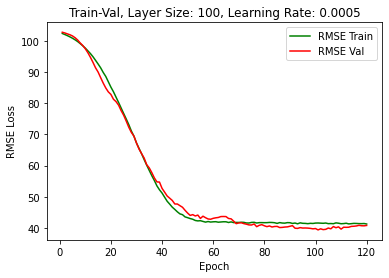

Part_Number_2_model_lr_0.0005_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.688608600   Val(RMSE): 102.773504300   Train(MAE),%: 95.681809800   Val(MAE),%: 95.807796500 

Epochs 2   Counter 1   Train(RMSE): 102.352090600   Val(RMSE): 102.581024800   Train(MAE),%: 95.314576500   Val(MAE),%: 95.581778200 

Epochs 3   Counter 1   Train(RMSE): 102.010107000   Val(RMSE): 102.318338400   Train(MAE),%: 94.942876100   Val(MAE),%: 95.330125800 

Epochs 4   Counter 1   Train(RMSE): 101.625817300   Val(RMSE): 101.897114400   Train(MAE),%: 94.543184000   Val(MAE),%: 94.856685600 

Epochs 5   Counter 1   Train(RMSE): 101.206511800   Val(RMSE): 101.362531700   Train(MAE),%: 94.109278100   Val(MAE),%: 94.270772300 

Epochs 6   Counter 1   Train(RMSE): 100.73289030

Epochs 60   Counter 15   Train(RMSE): 43.829128100   Val(RMSE): 39.217891100   Train(MAE),%: 35.013794800   Val(MAE),%: 31.533562300 

Epochs 61   Counter 16   Train(RMSE): 43.725260400   Val(RMSE): 39.298455200   Train(MAE),%: 34.877074400   Val(MAE),%: 31.624530200 

Epochs 62   Counter 17   Train(RMSE): 43.647602100   Val(RMSE): 39.357133200   Train(MAE),%: 34.844060600   Val(MAE),%: 31.666949900 

Epochs 63   Counter 18   Train(RMSE): 43.775248000   Val(RMSE): 38.803314200   Train(MAE),%: 34.843362200   Val(MAE),%: 31.166282200 

Epochs 64   Counter 19   Train(RMSE): 43.693237600   Val(RMSE): 39.635687200   Train(MAE),%: 34.769560300   Val(MAE),%: 31.902182700 

Epochs 65   Counter 20   Train(RMSE): 43.552665400   Val(RMSE): 39.655028000   Train(MAE),%: 34.896688200   Val(MAE),%: 31.943344100 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


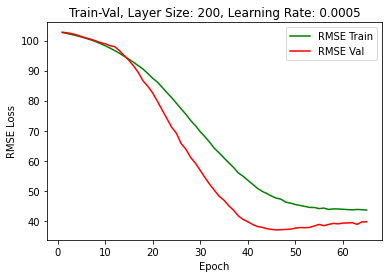

Part_Number_2_model_lr_0.0005_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.546140300   Val(RMSE): 102.992609700   Train(MAE),%: 95.515872500   Val(MAE),%: 96.038946200 

Epochs 2   Counter 1   Train(RMSE): 102.189710900   Val(RMSE): 102.906695000   Train(MAE),%: 95.146198100   Val(MAE),%: 95.925295500 

Epochs 3   Counter 1   Train(RMSE): 101.816699500   Val(RMSE): 102.798827500   Train(MAE),%: 94.755100700   Val(MAE),%: 95.841189700 

Epochs 4   Counter 1   Train(RMSE): 101.401058000   Val(RMSE): 102.742635100   Train(MAE),%: 94.312864600   Val(MAE),%: 95.759725600 

Epochs 5   Counter 1   Train(RMSE): 100.942736400   Val(RMSE): 102.558003100   Train(MAE),%: 93.841373900   Val(MAE),%: 95.552433000 

Epochs 6   Counter 1   Train(RMSE): 100.40486810

Epochs 60   Counter 20   Train(RMSE): 44.681608300   Val(RMSE): 67.336975100   Train(MAE),%: 35.764394800   Val(MAE),%: 58.303662300 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


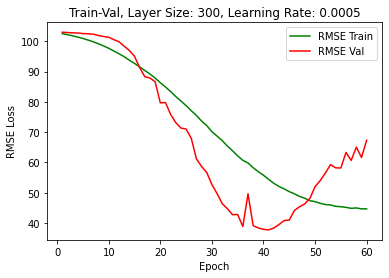

Part_Number_2_model_lr_0.0005_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.836508000   Val(RMSE): 102.637641300   Train(MAE),%: 95.830379000   Val(MAE),%: 95.660771100 

Epochs 2   Counter 1   Train(RMSE): 102.483791200   Val(RMSE): 102.295273500   Train(MAE),%: 95.467149500   Val(MAE),%: 95.275020600 

Epochs 3   Counter 1   Train(RMSE): 102.143274700   Val(RMSE): 101.785620400   Train(MAE),%: 95.106732200   Val(MAE),%: 94.761811600 

Epochs 4   Counter 1   Train(RMSE): 101.791656500   Val(RMSE): 101.440151200   Train(MAE),%: 94.725265800   Val(MAE),%: 94.369965900 

Epochs 5   Counter 1   Train(RMSE): 101.397061900   Val(RMSE): 100.821434700   Train(MAE),%: 94.292901700   Val(MAE),%: 93.696998600 

Epochs 6   Counter 1   Train(RMSE): 100.94395310

Epochs 61   Counter 13   Train(RMSE): 43.230436900   Val(RMSE): 39.048299800   Train(MAE),%: 34.390171500   Val(MAE),%: 31.400914700 

Epochs 62   Counter 14   Train(RMSE): 43.072958400   Val(RMSE): 38.840815900   Train(MAE),%: 34.372905100   Val(MAE),%: 31.225386600 

Epochs 63   Counter 15   Train(RMSE): 42.988284100   Val(RMSE): 38.774838800   Train(MAE),%: 34.424059200   Val(MAE),%: 31.128520500 

Epochs 64   Counter 16   Train(RMSE): 43.271728300   Val(RMSE): 38.705159200   Train(MAE),%: 34.394775400   Val(MAE),%: 31.110067800 

Epochs 65   Counter 17   Train(RMSE): 43.029008800   Val(RMSE): 38.726718300   Train(MAE),%: 34.687833700   Val(MAE),%: 31.153715300 

Epochs 66   Counter 18   Train(RMSE): 42.891823100   Val(RMSE): 39.396892900   Train(MAE),%: 34.354257700   Val(MAE),%: 31.701375200 

Epochs 67   Counter 19   Train(RMSE): 43.186152400   Val(RMSE): 38.825269100   Train(MAE),%: 34.464291400   Val(MAE),%: 31.206598900 

Epochs 68   Counter 20   Train(RMSE): 43.038765300   Va

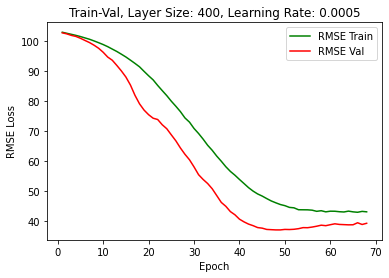

Part_Number_2_model_lr_0.0005_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.639480600   Val(RMSE): 102.462598800   Train(MAE),%: 95.609386900   Val(MAE),%: 95.440958000 

Epochs 2   Counter 1   Train(RMSE): 102.309512300   Val(RMSE): 101.747219700   Train(MAE),%: 95.257210800   Val(MAE),%: 94.632019700 

Epochs 3   Counter 1   Train(RMSE): 101.948084300   Val(RMSE): 100.411175400   Train(MAE),%: 94.872975900   Val(MAE),%: 93.204497700 

Epochs 4   Counter 1   Train(RMSE): 101.522478500   Val(RMSE): 99.008426700   Train(MAE),%: 94.425218000   Val(MAE),%: 91.669467900 

Epochs 5   Counter 1   Train(RMSE): 101.039026300   Val(RMSE): 98.008714000   Train(MAE),%: 93.911136100   Val(MAE),%: 90.570351900 

Epochs 6   Counter 1   Train(RMSE): 100.537324300 

Epochs 61   Counter 20   Train(RMSE): 43.328406500   Val(RMSE): 49.355937000   Train(MAE),%: 34.655091300   Val(MAE),%: 40.453635500 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


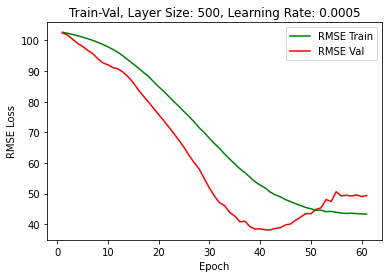

Part_Number_2_model_lr_0.0005_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.877171100   Val(RMSE): 102.955623600   Train(MAE),%: 95.869755600   Val(MAE),%: 95.991437900 

Epochs 2   Counter 1   Train(RMSE): 102.541585200   Val(RMSE): 102.700648600   Train(MAE),%: 95.514529000   Val(MAE),%: 95.698540400 

Epochs 3   Counter 1   Train(RMSE): 102.199019700   Val(RMSE): 102.311672800   Train(MAE),%: 95.149261800   Val(MAE),%: 95.313691500 

Epochs 4   Counter 1   Train(RMSE): 101.860806000   Val(RMSE): 102.048241300   Train(MAE),%: 94.786247900   Val(MAE),%: 95.012624700 

Epochs 5   Counter 1   Train(RMSE): 101.474316800   Val(RMSE): 101.606114700   Train(MAE),%: 94.379629700   Val(MAE),%: 94.529535300 

Epochs 6   Counter 1   Train(RMSE): 101.02965940

Epochs 61   Counter 1   Train(RMSE): 43.967613400   Val(RMSE): 60.800930300   Train(MAE),%: 35.069899500   Val(MAE),%: 51.343980800 

Epochs 62   Counter 1   Train(RMSE): 43.639002600   Val(RMSE): 60.481837900   Train(MAE),%: 35.046586200   Val(MAE),%: 51.070710800 

Epochs 63   Counter 2   Train(RMSE): 43.685344000   Val(RMSE): 61.130932200   Train(MAE),%: 34.925289500   Val(MAE),%: 51.709760000 

Epochs 64   Counter 3   Train(RMSE): 43.760376500   Val(RMSE): 63.683491400   Train(MAE),%: 35.036216700   Val(MAE),%: 54.302948600 

Epochs 65   Counter 4   Train(RMSE): 43.646421200   Val(RMSE): 63.319902700   Train(MAE),%: 35.119527700   Val(MAE),%: 53.928285900 

Epochs 66   Counter 5   Train(RMSE): 43.618469700   Val(RMSE): 62.418435100   Train(MAE),%: 34.924573500   Val(MAE),%: 53.033424400 

Epochs 67   Counter 6   Train(RMSE): 43.787578600   Val(RMSE): 63.446673700   Train(MAE),%: 34.921456400   Val(MAE),%: 54.058204300 

Epochs 68   Counter 7   Train(RMSE): 43.568066500   Val(RMSE):

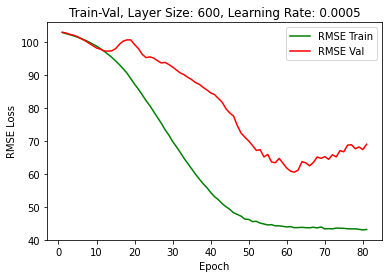

Part_Number_2_model_lr_0.0005_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.280841700   Val(RMSE): 102.100281400   Train(MAE),%: 95.220250700   Val(MAE),%: 95.075630800 

Epochs 2   Counter 1   Train(RMSE): 101.505828900   Val(RMSE): 100.864138900   Train(MAE),%: 94.424318400   Val(MAE),%: 93.725656500 

Epochs 3   Counter 1   Train(RMSE): 100.581850800   Val(RMSE): 99.342186000   Train(MAE),%: 93.412879300   Val(MAE),%: 92.120520900 

Epochs 4   Counter 1   Train(RMSE): 99.387762000   Val(RMSE): 97.521438600   Train(MAE),%: 92.089906100   Val(MAE),%: 90.154799800 

Epochs 5   Counter 1   Train(RMSE): 97.765560600   Val(RMSE): 96.074967700   Train(MAE),%: 90.444244400   Val(MAE),%: 88.592821800 

Epochs 6   Counter 1   Train(RMSE): 95.952127500   Va

Epochs 61   Counter 2   Train(RMSE): 41.504922600   Val(RMSE): 37.504476900   Train(MAE),%: 33.115480000   Val(MAE),%: 30.013619600 

Epochs 62   Counter 1   Train(RMSE): 41.245342400   Val(RMSE): 37.297902400   Train(MAE),%: 32.975837200   Val(MAE),%: 29.841833600 

Epochs 63   Counter 2   Train(RMSE): 41.257472800   Val(RMSE): 37.433226300   Train(MAE),%: 32.852464800   Val(MAE),%: 29.931664500 

Epochs 64   Counter 1   Train(RMSE): 41.297652200   Val(RMSE): 37.218376200   Train(MAE),%: 32.912789200   Val(MAE),%: 29.781967300 

Epochs 65   Counter 2   Train(RMSE): 41.104335300   Val(RMSE): 37.265741700   Train(MAE),%: 33.011208700   Val(MAE),%: 29.836227900 

Epochs 66   Counter 1   Train(RMSE): 41.128887000   Val(RMSE): 37.102585500   Train(MAE),%: 32.812014400   Val(MAE),%: 29.692476100 

Epochs 67   Counter 2   Train(RMSE): 41.148249400   Val(RMSE): 37.251507400   Train(MAE),%: 32.764072600   Val(MAE),%: 29.817846900 

Epochs 68   Counter 3   Train(RMSE): 40.879591900   Val(RMSE):

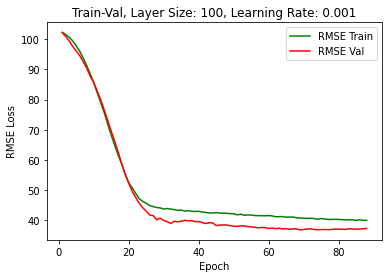

Part_Number_2_model_lr_0.001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.782461700   Val(RMSE): 102.875985500   Train(MAE),%: 95.766684800   Val(MAE),%: 95.922192900 

Epochs 2   Counter 1   Train(RMSE): 102.134630000   Val(RMSE): 102.252424900   Train(MAE),%: 95.086373700   Val(MAE),%: 95.228433600 

Epochs 3   Counter 1   Train(RMSE): 101.395468700   Val(RMSE): 101.053785300   Train(MAE),%: 94.297715600   Val(MAE),%: 93.972751600 

Epochs 4   Counter 1   Train(RMSE): 100.494157200   Val(RMSE): 98.887694000   Train(MAE),%: 93.339899800   Val(MAE),%: 91.641012200 

Epochs 5   Counter 1   Train(RMSE): 99.318017000   Val(RMSE): 95.401521700   Train(MAE),%: 92.076611100   Val(MAE),%: 87.909697200 

Epochs 6   Counter 1   Train(RMSE): 97.873440600   V

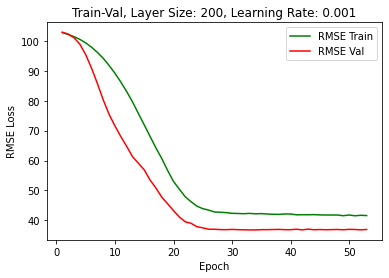

Part_Number_2_model_lr_0.001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.524342400   Val(RMSE): 102.431843400   Train(MAE),%: 95.509539100   Val(MAE),%: 95.422089300 

Epochs 2   Counter 1   Train(RMSE): 101.805129300   Val(RMSE): 100.783049900   Train(MAE),%: 94.739282400   Val(MAE),%: 93.609045000 

Epochs 3   Counter 1   Train(RMSE): 100.974618700   Val(RMSE): 98.891317400   Train(MAE),%: 93.821479100   Val(MAE),%: 91.611893300 

Epochs 4   Counter 1   Train(RMSE): 99.980835300   Val(RMSE): 96.855659500   Train(MAE),%: 92.787633500   Val(MAE),%: 89.418359100 

Epochs 5   Counter 1   Train(RMSE): 98.785588500   Val(RMSE): 95.186352400   Train(MAE),%: 91.498396200   Val(MAE),%: 87.618101800 

Epochs 6   Counter 1   Train(RMSE): 97.393002400   Val

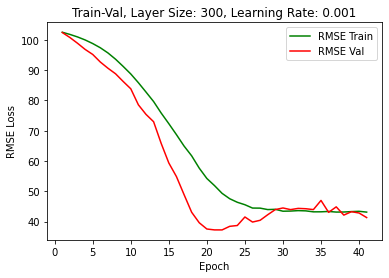

Part_Number_2_model_lr_0.001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.098441400   Val(RMSE): 101.296271000   Train(MAE),%: 95.038858200   Val(MAE),%: 94.251087200 

Epochs 2   Counter 1   Train(RMSE): 101.341920300   Val(RMSE): 98.985114400   Train(MAE),%: 94.242359700   Val(MAE),%: 91.755117400 

Epochs 3   Counter 1   Train(RMSE): 100.454942100   Val(RMSE): 95.860956200   Train(MAE),%: 93.273154900   Val(MAE),%: 88.423275000 

Epochs 4   Counter 1   Train(RMSE): 99.332259100   Val(RMSE): 91.738355600   Train(MAE),%: 92.087914500   Val(MAE),%: 83.944438300 

Epochs 5   Counter 1   Train(RMSE): 97.920416500   Val(RMSE): 88.093308800   Train(MAE),%: 90.560075500   Val(MAE),%: 80.023216900 

Epochs 6   Counter 1   Train(RMSE): 96.215326400   Val(

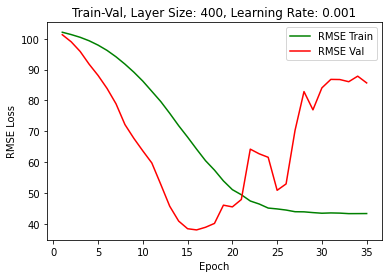

Part_Number_2_model_lr_0.001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.669623700   Val(RMSE): 101.234564500   Train(MAE),%: 95.679850000   Val(MAE),%: 94.195357600 

Epochs 2   Counter 1   Train(RMSE): 101.956131300   Val(RMSE): 99.341552100   Train(MAE),%: 94.931497700   Val(MAE),%: 92.138212800 

Epochs 3   Counter 1   Train(RMSE): 101.185069900   Val(RMSE): 96.724131300   Train(MAE),%: 94.123828700   Val(MAE),%: 89.346809400 

Epochs 4   Counter 1   Train(RMSE): 100.263791000   Val(RMSE): 93.324157100   Train(MAE),%: 93.180932400   Val(MAE),%: 85.655459700 

Epochs 5   Counter 1   Train(RMSE): 99.148821600   Val(RMSE): 89.346929600   Train(MAE),%: 91.965151600   Val(MAE),%: 81.353328700 

Epochs 6   Counter 1   Train(RMSE): 97.671291200   Val

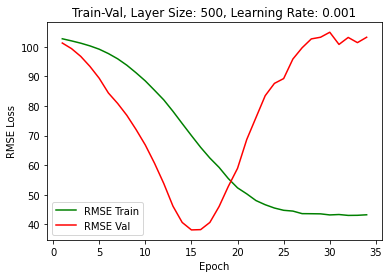

Part_Number_2_model_lr_0.001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.481859600   Val(RMSE): 102.647132200   Train(MAE),%: 95.482831500   Val(MAE),%: 95.666165700 

Epochs 2   Counter 1   Train(RMSE): 101.717054300   Val(RMSE): 102.003380500   Train(MAE),%: 94.661226000   Val(MAE),%: 94.956063600 

Epochs 3   Counter 1   Train(RMSE): 100.853927300   Val(RMSE): 101.419870400   Train(MAE),%: 93.701109500   Val(MAE),%: 94.358551700 

Epochs 4   Counter 1   Train(RMSE): 99.839050000   Val(RMSE): 100.846907300   Train(MAE),%: 92.616679600   Val(MAE),%: 93.721679700 

Epochs 5   Counter 1   Train(RMSE): 98.637148600   Val(RMSE): 100.117781300   Train(MAE),%: 91.352683700   Val(MAE),%: 92.926514900 

Epochs 6   Counter 1   Train(RMSE): 97.178025300   

Epochs 61   Counter 16   Train(RMSE): 40.177713800   Val(RMSE): 38.343662900   Train(MAE),%: 31.958545100   Val(MAE),%: 30.627106800 

Epochs 62   Counter 17   Train(RMSE): 39.915860100   Val(RMSE): 37.830308300   Train(MAE),%: 31.864073500   Val(MAE),%: 30.220734100 

Epochs 63   Counter 18   Train(RMSE): 39.874628600   Val(RMSE): 37.950882900   Train(MAE),%: 31.516253400   Val(MAE),%: 30.290693800 

Epochs 64   Counter 19   Train(RMSE): 40.117535100   Val(RMSE): 38.100492800   Train(MAE),%: 31.773805100   Val(MAE),%: 30.415680100 

Epochs 65   Counter 20   Train(RMSE): 40.050648700   Val(RMSE): 38.303793300   Train(MAE),%: 31.655721200   Val(MAE),%: 30.592502400 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


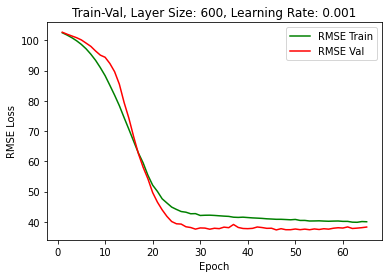

Part_Number_2_model_lr_0.001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.227200400   Val(RMSE): 84.392421100   Train(MAE),%: 90.603861900   Val(MAE),%: 76.068744700 

Epochs 2   Counter 1   Train(RMSE): 77.345820600   Val(RMSE): 49.679980300   Train(MAE),%: 67.582187500   Val(MAE),%: 40.488582000 

Epochs 3   Counter 1   Train(RMSE): 48.840038800   Val(RMSE): 37.726065000   Train(MAE),%: 39.045550500   Val(MAE),%: 30.286400600 

Epochs 4   Counter 1   Train(RMSE): 43.749025400   Val(RMSE): 37.399484300   Train(MAE),%: 35.138600200   Val(MAE),%: 30.033011300 

Epochs 5   Counter 2   Train(RMSE): 43.615108700   Val(RMSE): 37.598472900   Train(MAE),%: 35.017407600   Val(MAE),%: 30.202850500 

Epochs 6   Counter 1   Train(RMSE): 43.327318400   Val(RMSE

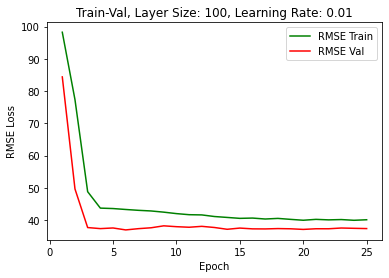

Part_Number_2_model_lr_0.01_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.042120600   Val(RMSE): 92.211787500   Train(MAE),%: 90.441157800   Val(MAE),%: 84.495522200 

Epochs 2   Counter 1   Train(RMSE): 75.978247300   Val(RMSE): 60.342293400   Train(MAE),%: 66.085306700   Val(MAE),%: 50.831182200 

Epochs 3   Counter 1   Train(RMSE): 47.520805700   Val(RMSE): 37.813661900   Train(MAE),%: 38.106261900   Val(MAE),%: 30.361411900 

Epochs 4   Counter 1   Train(RMSE): 43.560497400   Val(RMSE): 37.328321500   Train(MAE),%: 34.546922800   Val(MAE),%: 29.965426800 

Epochs 5   Counter 1   Train(RMSE): 42.897594300   Val(RMSE): 37.257977200   Train(MAE),%: 34.177597400   Val(MAE),%: 29.907659400 

Epochs 6   Counter 1   Train(RMSE): 42.296126500   Val(RMSE)

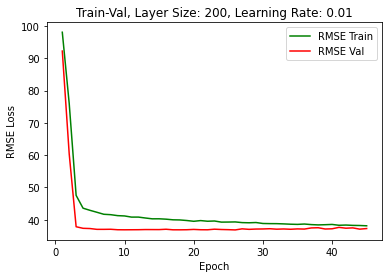

Part_Number_2_model_lr_0.01_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.085799800   Val(RMSE): 90.053725600   Train(MAE),%: 90.516370400   Val(MAE),%: 82.180215800 

Epochs 2   Counter 1   Train(RMSE): 77.290177200   Val(RMSE): 53.131878500   Train(MAE),%: 67.626242300   Val(MAE),%: 43.732056600 

Epochs 3   Counter 1   Train(RMSE): 48.854309600   Val(RMSE): 37.054739600   Train(MAE),%: 39.615536200   Val(MAE),%: 29.690276500 

Epochs 4   Counter 2   Train(RMSE): 43.895973700   Val(RMSE): 37.458059300   Train(MAE),%: 35.207735800   Val(MAE),%: 30.071341400 

Epochs 5   Counter 3   Train(RMSE): 43.486075400   Val(RMSE): 38.267529200   Train(MAE),%: 34.915191800   Val(MAE),%: 30.756848300 

Epochs 6   Counter 4   Train(RMSE): 43.369383400   Val(RMSE)

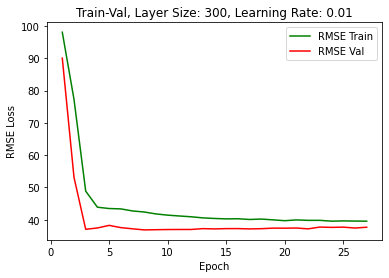

Part_Number_2_model_lr_0.01_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 99.154247800   Val(RMSE): 94.036158200   Train(MAE),%: 91.678914900   Val(MAE),%: 86.464504900 

Epochs 2   Counter 1   Train(RMSE): 79.617083800   Val(RMSE): 48.945150100   Train(MAE),%: 70.154311000   Val(MAE),%: 39.780322400 

Epochs 3   Counter 1   Train(RMSE): 50.019390600   Val(RMSE): 37.051058100   Train(MAE),%: 40.243729000   Val(MAE),%: 29.643100300 

Epochs 4   Counter 2   Train(RMSE): 44.008734200   Val(RMSE): 39.799946500   Train(MAE),%: 35.135515800   Val(MAE),%: 32.020621500 

Epochs 5   Counter 3   Train(RMSE): 43.644714700   Val(RMSE): 37.793126100   Train(MAE),%: 35.000772100   Val(MAE),%: 30.342789000 

Epochs 6   Counter 4   Train(RMSE): 43.231908400   Val(RMSE)

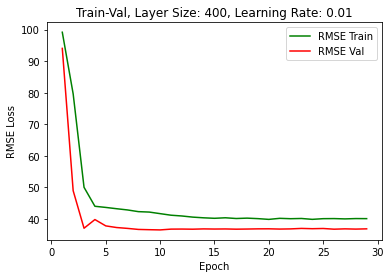

Part_Number_2_model_lr_0.01_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.406239700   Val(RMSE): 89.152333600   Train(MAE),%: 90.834295900   Val(MAE),%: 81.233415000 

Epochs 2   Counter 1   Train(RMSE): 77.719239800   Val(RMSE): 40.625772200   Train(MAE),%: 68.165934000   Val(MAE),%: 32.512736300 

Epochs 3   Counter 1   Train(RMSE): 49.120985800   Val(RMSE): 37.860807700   Train(MAE),%: 39.295400400   Val(MAE),%: 30.403292300 

Epochs 4   Counter 1   Train(RMSE): 43.729909300   Val(RMSE): 36.986043300   Train(MAE),%: 35.148675700   Val(MAE),%: 29.662035600 

Epochs 5   Counter 2   Train(RMSE): 43.445497600   Val(RMSE): 37.278910600   Train(MAE),%: 34.829683100   Val(MAE),%: 29.926773700 

Epochs 6   Counter 1   Train(RMSE): 43.141009800   Val(RMSE)

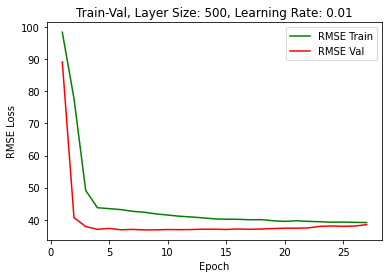

Part_Number_2_model_lr_0.01_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.876633000   Val(RMSE): 85.074680300   Train(MAE),%: 91.410926200   Val(MAE),%: 76.834971700 

Epochs 2   Counter 1   Train(RMSE): 77.665405900   Val(RMSE): 50.101455100   Train(MAE),%: 68.029675700   Val(MAE),%: 40.851607600 

Epochs 3   Counter 1   Train(RMSE): 48.714008700   Val(RMSE): 38.298806500   Train(MAE),%: 38.856215100   Val(MAE),%: 30.761063400 

Epochs 4   Counter 1   Train(RMSE): 43.725312300   Val(RMSE): 38.085086200   Train(MAE),%: 34.977497800   Val(MAE),%: 30.599207400 

Epochs 5   Counter 2   Train(RMSE): 43.171111400   Val(RMSE): 38.136201500   Train(MAE),%: 34.637861200   Val(MAE),%: 30.639982900 

Epochs 6   Counter 1   Train(RMSE): 42.721291600   Val(RMSE)

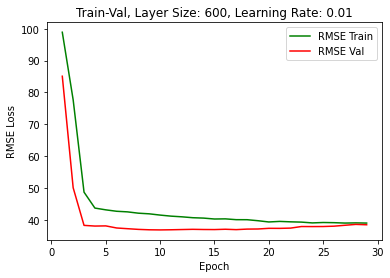

Part_Number_2_model_lr_0.01_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
CV part number:	 3
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 103.060593300   Val(RMSE): 103.123585400   Train(MAE),%: 96.080842400   Val(MAE),%: 96.171064400 

Epochs 2   Counter 1   Train(RMSE): 103.001423700   Val(RMSE): 103.002272900   Train(MAE),%: 96.020887000   Val(MAE),%: 96.074071200 

Epochs 3   Counter 1   Train(RMSE): 102.949655900   Val(RMSE): 102.994545000   Train(MAE),%: 95.948728100   Val(MAE),%: 96.033879000 

Epochs 4   Counter 1   Train(RMSE): 102.892666700   Val(RMSE): 102.892486600   Train(MAE),%: 95.881674100   Val(MAE),%: 95.917076700 

Epochs 5   Counter 2   Train(RMSE): 102.835566000   Val(RMSE): 102.924556700   Train(MAE),%: 95.819949600   Val(MAE),%: 95.978621800 

Epochs 6   Counter 1   Train(RM

Epochs 60   Counter 1   Train(RMSE): 97.020400300   Val(RMSE): 97.855407100   Train(MAE),%: 89.651141300   Val(MAE),%: 90.595792800 

Epochs 61   Counter 1   Train(RMSE): 96.854121700   Val(RMSE): 97.613782900   Train(MAE),%: 89.458551800   Val(MAE),%: 90.303137500 

Epochs 62   Counter 1   Train(RMSE): 96.681672800   Val(RMSE): 97.539262800   Train(MAE),%: 89.294097600   Val(MAE),%: 90.227047000 

Epochs 63   Counter 1   Train(RMSE): 96.529417300   Val(RMSE): 97.483849200   Train(MAE),%: 89.117189500   Val(MAE),%: 90.166298500 

Epochs 64   Counter 1   Train(RMSE): 96.413489600   Val(RMSE): 97.167977700   Train(MAE),%: 88.949092400   Val(MAE),%: 89.865669900 

Epochs 65   Counter 1   Train(RMSE): 96.246249300   Val(RMSE): 96.955706300   Train(MAE),%: 88.853084400   Val(MAE),%: 89.615151100 

Epochs 66   Counter 1   Train(RMSE): 96.077129200   Val(RMSE): 96.903841700   Train(MAE),%: 88.594749500   Val(MAE),%: 89.539512600 

Epochs 67   Counter 1   Train(RMSE): 95.934983600   Val(RMSE):

Epochs 121   Counter 3   Train(RMSE): 84.455418500   Val(RMSE): 84.532305400   Train(MAE),%: 76.166102200   Val(MAE),%: 76.302536000 

Epochs 122   Counter 4   Train(RMSE): 84.250268000   Val(RMSE): 84.518764500   Train(MAE),%: 75.986390800   Val(MAE),%: 76.213050800 

Epochs 123   Counter 1   Train(RMSE): 84.021212400   Val(RMSE): 83.810731900   Train(MAE),%: 75.615716000   Val(MAE),%: 75.503359500 

Epochs 124   Counter 1   Train(RMSE): 83.860776200   Val(RMSE): 83.666269300   Train(MAE),%: 75.369581500   Val(MAE),%: 75.371057500 

Epochs 125   Counter 1   Train(RMSE): 83.411528900   Val(RMSE): 83.206509300   Train(MAE),%: 75.096207000   Val(MAE),%: 74.913011600 

Epochs 126   Counter 1   Train(RMSE): 83.323137400   Val(RMSE): 82.928167300   Train(MAE),%: 74.773001000   Val(MAE),%: 74.583702100 

Epochs 127   Counter 1   Train(RMSE): 83.024063100   Val(RMSE): 82.250284800   Train(MAE),%: 74.496909100   Val(MAE),%: 73.806617700 

Epochs 128   Counter 1   Train(RMSE): 82.814197700   Va

Epochs 182   Counter 2   Train(RMSE): 67.770532400   Val(RMSE): 65.929389300   Train(MAE),%: 58.096897100   Val(MAE),%: 56.654389100 

Epochs 183   Counter 3   Train(RMSE): 67.402891400   Val(RMSE): 65.738787300   Train(MAE),%: 57.702112600   Val(MAE),%: 56.524763100 

Epochs 184   Counter 1   Train(RMSE): 67.070629300   Val(RMSE): 65.207290600   Train(MAE),%: 57.635556900   Val(MAE),%: 55.966525700 

Epochs 185   Counter 1   Train(RMSE): 66.843882000   Val(RMSE): 64.521355300   Train(MAE),%: 57.086796800   Val(MAE),%: 55.228215900 

Epochs 186   Counter 1   Train(RMSE): 66.716741100   Val(RMSE): 64.410108200   Train(MAE),%: 56.720252000   Val(MAE),%: 55.108884500 

Epochs 187   Counter 1   Train(RMSE): 66.376721300   Val(RMSE): 64.093674000   Train(MAE),%: 56.735516400   Val(MAE),%: 54.843506800 

Epochs 188   Counter 1   Train(RMSE): 66.009962300   Val(RMSE): 63.507767400   Train(MAE),%: 56.190991600   Val(MAE),%: 54.200330100 

Epochs 189   Counter 1   Train(RMSE): 65.652230600   Va

Epochs 243   Counter 1   Train(RMSE): 51.131900000   Val(RMSE): 46.540027900   Train(MAE),%: 41.553716600   Val(MAE),%: 37.797093400 

Epochs 244   Counter 1   Train(RMSE): 50.695814900   Val(RMSE): 46.365636800   Train(MAE),%: 41.306620700   Val(MAE),%: 37.645955700 

Epochs 245   Counter 1   Train(RMSE): 50.335238700   Val(RMSE): 46.206030800   Train(MAE),%: 41.095602300   Val(MAE),%: 37.481862100 

Epochs 246   Counter 1   Train(RMSE): 50.457986700   Val(RMSE): 45.980505300   Train(MAE),%: 40.779780700   Val(MAE),%: 37.311838200 

Epochs 247   Counter 1   Train(RMSE): 50.462355200   Val(RMSE): 45.854624100   Train(MAE),%: 40.888648800   Val(MAE),%: 37.188949600 

Epochs 248   Counter 1   Train(RMSE): 49.980061900   Val(RMSE): 45.485955900   Train(MAE),%: 40.715611800   Val(MAE),%: 36.811819100 

Epochs 249   Counter 1   Train(RMSE): 49.762586500   Val(RMSE): 45.330740900   Train(MAE),%: 40.278316200   Val(MAE),%: 36.680425600 

Epochs 250   Counter 1   Train(RMSE): 49.942130400   Va

Epochs 304   Counter 2   Train(RMSE): 43.327090900   Val(RMSE): 38.286354100   Train(MAE),%: 34.626604700   Val(MAE),%: 30.667224600 

Epochs 305   Counter 1   Train(RMSE): 43.180221100   Val(RMSE): 37.931760500   Train(MAE),%: 34.554911600   Val(MAE),%: 30.352779400 

Epochs 306   Counter 2   Train(RMSE): 43.262562600   Val(RMSE): 38.129533100   Train(MAE),%: 34.544675200   Val(MAE),%: 30.552141700 

Epochs 307   Counter 3   Train(RMSE): 43.400019300   Val(RMSE): 38.032264400   Train(MAE),%: 34.583331900   Val(MAE),%: 30.427086200 

Epochs 308   Counter 1   Train(RMSE): 42.994753800   Val(RMSE): 37.915211000   Train(MAE),%: 34.511988400   Val(MAE),%: 30.343784500 

Epochs 309   Counter 1   Train(RMSE): 43.223987900   Val(RMSE): 37.849486700   Train(MAE),%: 34.465923000   Val(MAE),%: 30.264320500 

Epochs 310   Counter 1   Train(RMSE): 43.158578000   Val(RMSE): 37.833260500   Train(MAE),%: 34.577868100   Val(MAE),%: 30.238536000 

Epochs 311   Counter 2   Train(RMSE): 43.079166700   Va

Epochs 365   Counter 11   Train(RMSE): 42.523696900   Val(RMSE): 37.311846400   Train(MAE),%: 34.070194200   Val(MAE),%: 29.860650400 

Epochs 366   Counter 12   Train(RMSE): 42.255484700   Val(RMSE): 37.283761300   Train(MAE),%: 33.899077900   Val(MAE),%: 29.848301900 

Epochs 367   Counter 13   Train(RMSE): 42.409733500   Val(RMSE): 37.287019700   Train(MAE),%: 33.846822000   Val(MAE),%: 29.838440300 

Epochs 368   Counter 14   Train(RMSE): 42.266535100   Val(RMSE): 37.247514400   Train(MAE),%: 33.877608400   Val(MAE),%: 29.815244700 

Epochs 369   Counter 15   Train(RMSE): 42.562859100   Val(RMSE): 37.228296900   Train(MAE),%: 33.886631500   Val(MAE),%: 29.778360800 

Epochs 370   Counter 16   Train(RMSE): 42.366707700   Val(RMSE): 37.281751000   Train(MAE),%: 33.922375400   Val(MAE),%: 29.794693900 

Epochs 371   Counter 17   Train(RMSE): 42.311718700   Val(RMSE): 37.310754100   Train(MAE),%: 33.981828800   Val(MAE),%: 29.836897900 

Epochs 372   Counter 18   Train(RMSE): 42.183342

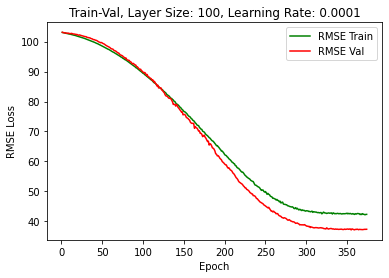

Part_Number_3_model_lr_0.0001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.867027000   Val(RMSE): 102.807633700   Train(MAE),%: 95.863759600   Val(MAE),%: 95.833917600 

Epochs 2   Counter 1   Train(RMSE): 102.815325900   Val(RMSE): 102.731699000   Train(MAE),%: 95.811486000   Val(MAE),%: 95.784816700 

Epochs 3   Counter 2   Train(RMSE): 102.771253800   Val(RMSE): 102.737707800   Train(MAE),%: 95.756035500   Val(MAE),%: 95.759473200 

Epochs 4   Counter 1   Train(RMSE): 102.695947100   Val(RMSE): 102.660404800   Train(MAE),%: 95.685178700   Val(MAE),%: 95.669050200 

Epochs 5   Counter 2   Train(RMSE): 102.631372200   Val(RMSE): 102.694808300   Train(MAE),%: 95.611663800   Val(MAE),%: 95.733615200 

Epochs 6   Counter 1   Train(RMSE): 102.55584350

Epochs 60   Counter 1   Train(RMSE): 96.564190700   Val(RMSE): 99.208814600   Train(MAE),%: 89.071079800   Val(MAE),%: 92.026272500 

Epochs 61   Counter 1   Train(RMSE): 96.362349800   Val(RMSE): 99.051754600   Train(MAE),%: 88.884380800   Val(MAE),%: 91.831083900 

Epochs 62   Counter 1   Train(RMSE): 96.204227600   Val(RMSE): 99.049385700   Train(MAE),%: 88.670727600   Val(MAE),%: 91.827470100 

Epochs 63   Counter 2   Train(RMSE): 96.051405500   Val(RMSE): 99.072476100   Train(MAE),%: 88.558769900   Val(MAE),%: 91.855892200 

Epochs 64   Counter 1   Train(RMSE): 95.906563100   Val(RMSE): 98.711863800   Train(MAE),%: 88.390858900   Val(MAE),%: 91.503944400 

Epochs 65   Counter 1   Train(RMSE): 95.762054100   Val(RMSE): 98.648595800   Train(MAE),%: 88.182894800   Val(MAE),%: 91.411486300 

Epochs 66   Counter 1   Train(RMSE): 95.553589900   Val(RMSE): 98.603447000   Train(MAE),%: 87.987479200   Val(MAE),%: 91.347493500 

Epochs 67   Counter 1   Train(RMSE): 95.387302600   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 84.339586700   Val(RMSE): 89.504709200   Train(MAE),%: 75.913252100   Val(MAE),%: 81.679484000 

Epochs 122   Counter 2   Train(RMSE): 83.971067300   Val(RMSE): 89.510051700   Train(MAE),%: 75.466457900   Val(MAE),%: 81.618269600 

Epochs 123   Counter 1   Train(RMSE): 83.833526300   Val(RMSE): 89.420272800   Train(MAE),%: 75.426894100   Val(MAE),%: 81.576549500 

Epochs 124   Counter 1   Train(RMSE): 83.582745400   Val(RMSE): 88.979236600   Train(MAE),%: 74.951136700   Val(MAE),%: 81.118029300 

Epochs 125   Counter 1   Train(RMSE): 83.260313900   Val(RMSE): 88.796865500   Train(MAE),%: 74.694623500   Val(MAE),%: 80.956806800 

Epochs 126   Counter 1   Train(RMSE): 83.127964200   Val(RMSE): 88.503205000   Train(MAE),%: 74.355985900   Val(MAE),%: 80.611561500 

Epochs 127   Counter 1   Train(RMSE): 82.815053500   Val(RMSE): 88.392628400   Train(MAE),%: 74.176597600   Val(MAE),%: 80.436815900 

Epochs 128   Counter 1   Train(RMSE): 82.669192100   Va

Epochs 182   Counter 1   Train(RMSE): 68.432332900   Val(RMSE): 76.402431500   Train(MAE),%: 58.605332400   Val(MAE),%: 67.660882900 

Epochs 183   Counter 1   Train(RMSE): 68.244740700   Val(RMSE): 76.028847400   Train(MAE),%: 58.303837500   Val(MAE),%: 67.322635700 

Epochs 184   Counter 1   Train(RMSE): 67.863443100   Val(RMSE): 75.913640300   Train(MAE),%: 58.241740000   Val(MAE),%: 67.191148100 

Epochs 185   Counter 1   Train(RMSE): 67.651228200   Val(RMSE): 75.651562400   Train(MAE),%: 57.705455900   Val(MAE),%: 66.873474100 

Epochs 186   Counter 1   Train(RMSE): 67.371357500   Val(RMSE): 75.380142800   Train(MAE),%: 57.558923600   Val(MAE),%: 66.587394700 

Epochs 187   Counter 1   Train(RMSE): 67.176469600   Val(RMSE): 75.062607400   Train(MAE),%: 57.275396100   Val(MAE),%: 66.308137300 

Epochs 188   Counter 1   Train(RMSE): 66.798743200   Val(RMSE): 74.838622400   Train(MAE),%: 56.760323900   Val(MAE),%: 66.033448500 

Epochs 189   Counter 1   Train(RMSE): 66.554636700   Va

Epochs 243   Counter 1   Train(RMSE): 52.768061300   Val(RMSE): 60.470096600   Train(MAE),%: 42.885938200   Val(MAE),%: 51.146255800 

Epochs 244   Counter 1   Train(RMSE): 52.169105200   Val(RMSE): 60.290070200   Train(MAE),%: 42.701754700   Val(MAE),%: 50.975991200 

Epochs 245   Counter 1   Train(RMSE): 52.186937600   Val(RMSE): 60.038611700   Train(MAE),%: 42.338056100   Val(MAE),%: 50.718118700 

Epochs 246   Counter 1   Train(RMSE): 51.870101600   Val(RMSE): 59.626236900   Train(MAE),%: 42.106966400   Val(MAE),%: 50.318273500 

Epochs 247   Counter 2   Train(RMSE): 51.853534400   Val(RMSE): 59.648251200   Train(MAE),%: 42.236907000   Val(MAE),%: 50.340819000 

Epochs 248   Counter 1   Train(RMSE): 51.736371900   Val(RMSE): 59.256237000   Train(MAE),%: 41.917222600   Val(MAE),%: 49.923895800 

Epochs 249   Counter 1   Train(RMSE): 51.249084300   Val(RMSE): 59.154537200   Train(MAE),%: 41.690911500   Val(MAE),%: 49.788595800 

Epochs 250   Counter 1   Train(RMSE): 51.206155400   Va

Epochs 304   Counter 1   Train(RMSE): 44.271323200   Val(RMSE): 48.217550600   Train(MAE),%: 35.388161200   Val(MAE),%: 39.318515800 

Epochs 305   Counter 1   Train(RMSE): 44.367292500   Val(RMSE): 47.917637800   Train(MAE),%: 35.386530800   Val(MAE),%: 39.083013900 

Epochs 306   Counter 2   Train(RMSE): 44.058541000   Val(RMSE): 48.092740400   Train(MAE),%: 35.419865200   Val(MAE),%: 39.193992600 

Epochs 307   Counter 1   Train(RMSE): 44.209137600   Val(RMSE): 47.771749200   Train(MAE),%: 35.426589300   Val(MAE),%: 38.887977900 

Epochs 308   Counter 1   Train(RMSE): 44.046490500   Val(RMSE): 47.662265800   Train(MAE),%: 35.546949500   Val(MAE),%: 38.821652400 

Epochs 309   Counter 1   Train(RMSE): 44.099116000   Val(RMSE): 47.362898200   Train(MAE),%: 35.237137300   Val(MAE),%: 38.511927300 

Epochs 310   Counter 1   Train(RMSE): 44.173042600   Val(RMSE): 47.195053700   Train(MAE),%: 35.419211000   Val(MAE),%: 38.343411400 

Epochs 311   Counter 1   Train(RMSE): 44.084580600   Va

Epochs 365   Counter 2   Train(RMSE): 43.159514100   Val(RMSE): 43.670668600   Train(MAE),%: 34.702434400   Val(MAE),%: 35.183200200 

Epochs 366   Counter 3   Train(RMSE): 43.373067100   Val(RMSE): 43.474596000   Train(MAE),%: 34.472302800   Val(MAE),%: 35.099422800 

Epochs 367   Counter 4   Train(RMSE): 43.214801100   Val(RMSE): 43.383735000   Train(MAE),%: 34.559460000   Val(MAE),%: 34.964927700 

Epochs 368   Counter 1   Train(RMSE): 43.157094200   Val(RMSE): 43.158233000   Train(MAE),%: 34.558288700   Val(MAE),%: 34.794081700 

Epochs 369   Counter 2   Train(RMSE): 43.314785800   Val(RMSE): 43.247418100   Train(MAE),%: 34.476722100   Val(MAE),%: 34.877326600 

Epochs 370   Counter 3   Train(RMSE): 43.041277500   Val(RMSE): 43.457995100   Train(MAE),%: 34.583927700   Val(MAE),%: 35.010585500 

Epochs 371   Counter 1   Train(RMSE): 43.231298500   Val(RMSE): 43.059812500   Train(MAE),%: 34.259781700   Val(MAE),%: 34.690864600 

Epochs 372   Counter 2   Train(RMSE): 43.231808200   Va

Epochs 426   Counter 1   Train(RMSE): 42.804695800   Val(RMSE): 41.239858600   Train(MAE),%: 34.370013500   Val(MAE),%: 33.135825200 

Epochs 427   Counter 2   Train(RMSE): 42.975708700   Val(RMSE): 41.501791000   Train(MAE),%: 34.385317100   Val(MAE),%: 33.371388800 

Epochs 428   Counter 3   Train(RMSE): 42.835712600   Val(RMSE): 41.609218000   Train(MAE),%: 34.163418800   Val(MAE),%: 33.441752100 

Epochs 429   Counter 4   Train(RMSE): 42.779012900   Val(RMSE): 41.666189800   Train(MAE),%: 34.233789400   Val(MAE),%: 33.520411200 

Epochs 430   Counter 5   Train(RMSE): 42.648934600   Val(RMSE): 41.463574100   Train(MAE),%: 34.340165200   Val(MAE),%: 33.341051700 

Epochs 431   Counter 6   Train(RMSE): 42.777924700   Val(RMSE): 41.255961700   Train(MAE),%: 34.254916100   Val(MAE),%: 33.175407400 

Epochs 432   Counter 7   Train(RMSE): 43.062390000   Val(RMSE): 41.429494900   Train(MAE),%: 34.181062600   Val(MAE),%: 33.291008900 

Epochs 433   Counter 8   Train(RMSE): 42.750004600   Va

Epochs 487   Counter 4   Train(RMSE): 42.380835500   Val(RMSE): 40.002612100   Train(MAE),%: 34.002126100   Val(MAE),%: 32.116266900 

Epochs 488   Counter 5   Train(RMSE): 42.617369900   Val(RMSE): 40.053164800   Train(MAE),%: 34.063085000   Val(MAE),%: 32.162963200 

Epochs 489   Counter 6   Train(RMSE): 42.541195600   Val(RMSE): 40.001815800   Train(MAE),%: 33.936577700   Val(MAE),%: 32.127808900 

Epochs 490   Counter 7   Train(RMSE): 42.437427400   Val(RMSE): 39.974444100   Train(MAE),%: 33.996074800   Val(MAE),%: 32.068035900 

Epochs 491   Counter 1   Train(RMSE): 42.417166500   Val(RMSE): 39.908525800   Train(MAE),%: 33.967549000   Val(MAE),%: 32.016012800 

Epochs 492   Counter 1   Train(RMSE): 42.499590300   Val(RMSE): 39.822117500   Train(MAE),%: 33.935523700   Val(MAE),%: 31.964351700 

Epochs 493   Counter 2   Train(RMSE): 42.324188700   Val(RMSE): 39.841230100   Train(MAE),%: 33.830922300   Val(MAE),%: 31.990031900 

Epochs 494   Counter 1   Train(RMSE): 42.347165500   Va

Epochs 548   Counter 1   Train(RMSE): 42.153043500   Val(RMSE): 38.808412600   Train(MAE),%: 33.588344900   Val(MAE),%: 31.106714100 

Epochs 549   Counter 1   Train(RMSE): 42.115385000   Val(RMSE): 38.782848700   Train(MAE),%: 33.561644800   Val(MAE),%: 31.083682400 

Epochs 550   Counter 1   Train(RMSE): 41.962343000   Val(RMSE): 38.777695000   Train(MAE),%: 33.805100300   Val(MAE),%: 31.081292800 

Epochs 551   Counter 1   Train(RMSE): 41.817114500   Val(RMSE): 38.655799200   Train(MAE),%: 33.604486700   Val(MAE),%: 31.025159700 

Epochs 552   Counter 2   Train(RMSE): 42.152940200   Val(RMSE): 38.800130500   Train(MAE),%: 33.544395100   Val(MAE),%: 31.130074000 

Epochs 553   Counter 3   Train(RMSE): 42.167249600   Val(RMSE): 38.820018100   Train(MAE),%: 33.627284300   Val(MAE),%: 31.123622300 

Epochs 554   Counter 1   Train(RMSE): 41.938804500   Val(RMSE): 38.645489400   Train(MAE),%: 33.633041100   Val(MAE),%: 30.972018700 

Epochs 555   Counter 2   Train(RMSE): 42.116536000   Va

Epochs 609   Counter 3   Train(RMSE): 41.717330100   Val(RMSE): 38.151743900   Train(MAE),%: 33.377755500   Val(MAE),%: 30.621481300 

Epochs 610   Counter 4   Train(RMSE): 41.585882600   Val(RMSE): 37.961441000   Train(MAE),%: 33.310882100   Val(MAE),%: 30.411178000 

Epochs 611   Counter 1   Train(RMSE): 41.614466000   Val(RMSE): 37.956311500   Train(MAE),%: 33.305962800   Val(MAE),%: 30.388018100 

Epochs 612   Counter 1   Train(RMSE): 41.587965600   Val(RMSE): 37.884760900   Train(MAE),%: 33.237387900   Val(MAE),%: 30.330576700 

Epochs 613   Counter 2   Train(RMSE): 41.734816300   Val(RMSE): 38.082185100   Train(MAE),%: 33.480305700   Val(MAE),%: 30.536360400 

Epochs 614   Counter 3   Train(RMSE): 41.828262500   Val(RMSE): 37.917518900   Train(MAE),%: 33.274841400   Val(MAE),%: 30.373378600 

Epochs 615   Counter 4   Train(RMSE): 41.588735300   Val(RMSE): 37.899743100   Train(MAE),%: 33.177979000   Val(MAE),%: 30.364633700 

Epochs 616   Counter 5   Train(RMSE): 41.488054400   Va

Epochs 670   Counter 2   Train(RMSE): 41.128571400   Val(RMSE): 37.542831100   Train(MAE),%: 33.017218400   Val(MAE),%: 30.087913400 

Epochs 671   Counter 3   Train(RMSE): 41.182482200   Val(RMSE): 37.446931200   Train(MAE),%: 33.116060500   Val(MAE),%: 29.988829900 

Epochs 672   Counter 4   Train(RMSE): 41.213413200   Val(RMSE): 37.538449900   Train(MAE),%: 32.872504500   Val(MAE),%: 30.088105700 

Epochs 673   Counter 5   Train(RMSE): 41.133107100   Val(RMSE): 37.498510400   Train(MAE),%: 32.851277600   Val(MAE),%: 30.036975400 

Epochs 674   Counter 6   Train(RMSE): 41.336576700   Val(RMSE): 37.480900800   Train(MAE),%: 32.994202800   Val(MAE),%: 30.019563000 

Epochs 675   Counter 1   Train(RMSE): 41.216339900   Val(RMSE): 37.396582600   Train(MAE),%: 32.956802900   Val(MAE),%: 29.957227500 

Epochs 676   Counter 2   Train(RMSE): 41.183662900   Val(RMSE): 37.503999700   Train(MAE),%: 33.006071900   Val(MAE),%: 30.058534500 

Epochs 677   Counter 1   Train(RMSE): 41.061673200   Va

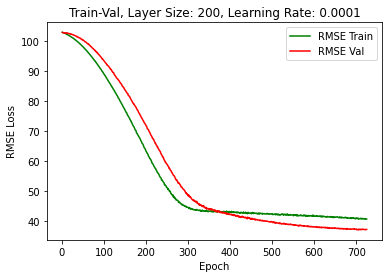

Part_Number_3_model_lr_0.0001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.918876000   Val(RMSE): 102.539591500   Train(MAE),%: 95.898506200   Val(MAE),%: 95.537851300 

Epochs 2   Counter 1   Train(RMSE): 102.850286400   Val(RMSE): 102.395868900   Train(MAE),%: 95.850998300   Val(MAE),%: 95.414667100 

Epochs 3   Counter 1   Train(RMSE): 102.785959300   Val(RMSE): 102.327822400   Train(MAE),%: 95.783901000   Val(MAE),%: 95.309932100 

Epochs 4   Counter 1   Train(RMSE): 102.729049400   Val(RMSE): 102.171726900   Train(MAE),%: 95.711564100   Val(MAE),%: 95.133597100 

Epochs 5   Counter 1   Train(RMSE): 102.660249500   Val(RMSE): 102.157200500   Train(MAE),%: 95.637335700   Val(MAE),%: 95.146796500 

Epochs 6   Counter 1   Train(RMSE): 102.58038300

Epochs 60   Counter 1   Train(RMSE): 96.151953000   Val(RMSE): 95.192653000   Train(MAE),%: 88.831943700   Val(MAE),%: 87.645367300 

Epochs 61   Counter 1   Train(RMSE): 95.965149600   Val(RMSE): 94.968705500   Train(MAE),%: 88.639043100   Val(MAE),%: 87.376181300 

Epochs 62   Counter 1   Train(RMSE): 95.789906400   Val(RMSE): 94.804319400   Train(MAE),%: 88.426739900   Val(MAE),%: 87.201562900 

Epochs 63   Counter 1   Train(RMSE): 95.550312500   Val(RMSE): 94.690381400   Train(MAE),%: 88.237361700   Val(MAE),%: 87.080205300 

Epochs 64   Counter 1   Train(RMSE): 95.441591300   Val(RMSE): 94.412127800   Train(MAE),%: 87.989983300   Val(MAE),%: 86.814318300 

Epochs 65   Counter 1   Train(RMSE): 95.209903900   Val(RMSE): 94.249026000   Train(MAE),%: 87.889653400   Val(MAE),%: 86.609633800 

Epochs 66   Counter 1   Train(RMSE): 95.038812400   Val(RMSE): 94.104494100   Train(MAE),%: 87.598777100   Val(MAE),%: 86.444419900 

Epochs 67   Counter 1   Train(RMSE): 94.897104700   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 82.839145200   Val(RMSE): 81.721292500   Train(MAE),%: 74.345476900   Val(MAE),%: 73.215035800 

Epochs 122   Counter 1   Train(RMSE): 82.375712500   Val(RMSE): 81.651027000   Train(MAE),%: 74.040441400   Val(MAE),%: 73.063818600 

Epochs 123   Counter 1   Train(RMSE): 82.291951700   Val(RMSE): 81.454175900   Train(MAE),%: 73.758754900   Val(MAE),%: 72.904051500 

Epochs 124   Counter 1   Train(RMSE): 82.151677000   Val(RMSE): 81.042364100   Train(MAE),%: 73.464518000   Val(MAE),%: 72.485078800 

Epochs 125   Counter 1   Train(RMSE): 81.786918000   Val(RMSE): 80.970165900   Train(MAE),%: 73.179692100   Val(MAE),%: 72.437712400 

Epochs 126   Counter 1   Train(RMSE): 81.549027200   Val(RMSE): 80.716432600   Train(MAE),%: 72.871250300   Val(MAE),%: 72.140572200 

Epochs 127   Counter 1   Train(RMSE): 81.228645000   Val(RMSE): 80.248693500   Train(MAE),%: 72.637817400   Val(MAE),%: 71.595045100 

Epochs 128   Counter 1   Train(RMSE): 81.049983100   Va

Epochs 182   Counter 1   Train(RMSE): 66.738171100   Val(RMSE): 67.206750900   Train(MAE),%: 56.838778100   Val(MAE),%: 57.880083400 

Epochs 183   Counter 1   Train(RMSE): 66.370765400   Val(RMSE): 67.086285300   Train(MAE),%: 56.489494800   Val(MAE),%: 57.835575400 

Epochs 184   Counter 1   Train(RMSE): 66.208377700   Val(RMSE): 66.408597900   Train(MAE),%: 56.286439300   Val(MAE),%: 57.118680000 

Epochs 185   Counter 1   Train(RMSE): 65.856453300   Val(RMSE): 66.289917600   Train(MAE),%: 55.812254000   Val(MAE),%: 56.961576100 

Epochs 186   Counter 2   Train(RMSE): 65.726399000   Val(RMSE): 66.364632900   Train(MAE),%: 55.584069300   Val(MAE),%: 57.038998600 

Epochs 187   Counter 1   Train(RMSE): 65.484554500   Val(RMSE): 65.710692700   Train(MAE),%: 55.493176300   Val(MAE),%: 56.413932200 

Epochs 188   Counter 1   Train(RMSE): 64.993820500   Val(RMSE): 65.136940000   Train(MAE),%: 54.892704300   Val(MAE),%: 55.780491500 

Epochs 189   Counter 2   Train(RMSE): 64.944668800   Va

Epochs 243   Counter 3   Train(RMSE): 52.514334000   Val(RMSE): 50.716369600   Train(MAE),%: 42.458790300   Val(MAE),%: 41.575255700 

Epochs 244   Counter 1   Train(RMSE): 52.115481700   Val(RMSE): 50.139238700   Train(MAE),%: 42.506785000   Val(MAE),%: 41.042792000 

Epochs 245   Counter 1   Train(RMSE): 51.777633200   Val(RMSE): 50.065841000   Train(MAE),%: 42.152761200   Val(MAE),%: 40.959963800 

Epochs 246   Counter 1   Train(RMSE): 51.625702900   Val(RMSE): 49.444529500   Train(MAE),%: 42.097314800   Val(MAE),%: 40.413647300 

Epochs 247   Counter 1   Train(RMSE): 51.772540200   Val(RMSE): 49.315886200   Train(MAE),%: 41.837204800   Val(MAE),%: 40.289122900 

Epochs 248   Counter 1   Train(RMSE): 51.586930600   Val(RMSE): 48.923305800   Train(MAE),%: 41.825343300   Val(MAE),%: 39.883468000 

Epochs 249   Counter 2   Train(RMSE): 51.252249800   Val(RMSE): 48.978645300   Train(MAE),%: 41.648972700   Val(MAE),%: 39.944559400 

Epochs 250   Counter 1   Train(RMSE): 51.392049700   Va

Epochs 304   Counter 1   Train(RMSE): 45.706441300   Val(RMSE): 39.955520600   Train(MAE),%: 36.368311700   Val(MAE),%: 32.117192000 

Epochs 305   Counter 2   Train(RMSE): 45.472483900   Val(RMSE): 40.488213900   Train(MAE),%: 36.503016900   Val(MAE),%: 32.554653300 

Epochs 306   Counter 3   Train(RMSE): 45.498163600   Val(RMSE): 40.138435700   Train(MAE),%: 36.451761500   Val(MAE),%: 32.274937300 

Epochs 307   Counter 1   Train(RMSE): 45.277109400   Val(RMSE): 39.597518900   Train(MAE),%: 36.283129700   Val(MAE),%: 31.778418200 

Epochs 308   Counter 2   Train(RMSE): 45.375300200   Val(RMSE): 39.834874800   Train(MAE),%: 36.300177500   Val(MAE),%: 31.998785000 

Epochs 309   Counter 1   Train(RMSE): 45.184533500   Val(RMSE): 39.319267600   Train(MAE),%: 36.168705300   Val(MAE),%: 31.547505900 

Epochs 310   Counter 2   Train(RMSE): 45.286267800   Val(RMSE): 39.693781200   Train(MAE),%: 36.277894700   Val(MAE),%: 31.838769400 

Epochs 311   Counter 3   Train(RMSE): 45.242686400   Va

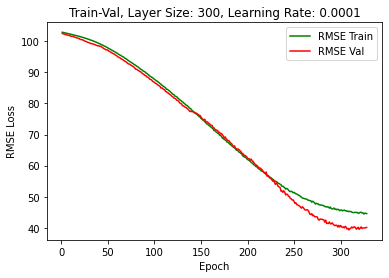

Part_Number_3_model_lr_0.0001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.694993700   Val(RMSE): 102.704761500   Train(MAE),%: 95.692711500   Val(MAE),%: 95.729349800 

Epochs 2   Counter 1   Train(RMSE): 102.641713700   Val(RMSE): 102.577590900   Train(MAE),%: 95.635227700   Val(MAE),%: 95.624605200 

Epochs 3   Counter 1   Train(RMSE): 102.581941400   Val(RMSE): 102.553257000   Train(MAE),%: 95.580150400   Val(MAE),%: 95.566946700 

Epochs 4   Counter 1   Train(RMSE): 102.510733600   Val(RMSE): 102.437403400   Train(MAE),%: 95.504522900   Val(MAE),%: 95.433211000 

Epochs 5   Counter 1   Train(RMSE): 102.448802500   Val(RMSE): 102.435889600   Train(MAE),%: 95.430890300   Val(MAE),%: 95.459183400 

Epochs 6   Counter 1   Train(RMSE): 102.34747580

Epochs 60   Counter 1   Train(RMSE): 95.298155400   Val(RMSE): 91.216450400   Train(MAE),%: 87.989458800   Val(MAE),%: 83.548805900 

Epochs 61   Counter 1   Train(RMSE): 95.092946900   Val(RMSE): 90.987943600   Train(MAE),%: 87.757915000   Val(MAE),%: 83.265879900 

Epochs 62   Counter 1   Train(RMSE): 94.874649400   Val(RMSE): 90.665874500   Train(MAE),%: 87.552808300   Val(MAE),%: 82.925167700 

Epochs 63   Counter 1   Train(RMSE): 94.673013800   Val(RMSE): 90.553003900   Train(MAE),%: 87.358539100   Val(MAE),%: 82.801418900 

Epochs 64   Counter 1   Train(RMSE): 94.541047100   Val(RMSE): 90.067102400   Train(MAE),%: 87.103891800   Val(MAE),%: 82.321771000 

Epochs 65   Counter 1   Train(RMSE): 94.335840300   Val(RMSE): 89.820256600   Train(MAE),%: 87.000647800   Val(MAE),%: 82.031276100 

Epochs 66   Counter 1   Train(RMSE): 94.125085900   Val(RMSE): 89.629321400   Train(MAE),%: 86.692931100   Val(MAE),%: 81.808906600 

Epochs 67   Counter 1   Train(RMSE): 94.016587000   Val(RMSE):

Epochs 121   Counter 1   Train(RMSE): 81.825958900   Val(RMSE): 71.775269200   Train(MAE),%: 73.033678100   Val(MAE),%: 62.833833100 

Epochs 122   Counter 1   Train(RMSE): 81.542342500   Val(RMSE): 71.304562900   Train(MAE),%: 72.829603400   Val(MAE),%: 62.249313400 

Epochs 123   Counter 1   Train(RMSE): 81.339128200   Val(RMSE): 71.212391500   Train(MAE),%: 72.497491900   Val(MAE),%: 62.200348500 

Epochs 124   Counter 1   Train(RMSE): 81.210412400   Val(RMSE): 70.706494600   Train(MAE),%: 72.154985500   Val(MAE),%: 61.696644100 

Epochs 125   Counter 1   Train(RMSE): 80.861179500   Val(RMSE): 70.455077500   Train(MAE),%: 71.904096200   Val(MAE),%: 61.469522500 

Epochs 126   Counter 1   Train(RMSE): 80.645866100   Val(RMSE): 69.759792300   Train(MAE),%: 71.616128700   Val(MAE),%: 60.706530300 

Epochs 127   Counter 1   Train(RMSE): 80.404506200   Val(RMSE): 69.495856000   Train(MAE),%: 71.459161800   Val(MAE),%: 60.398102100 

Epochs 128   Counter 1   Train(RMSE): 80.232658700   Va

Epochs 182   Counter 1   Train(RMSE): 66.939794100   Val(RMSE): 50.680322000   Train(MAE),%: 56.271612400   Val(MAE),%: 41.568256400 

Epochs 183   Counter 1   Train(RMSE): 66.673847000   Val(RMSE): 50.453716900   Train(MAE),%: 55.989115200   Val(MAE),%: 41.440234200 

Epochs 184   Counter 1   Train(RMSE): 66.446839700   Val(RMSE): 50.098929700   Train(MAE),%: 55.798547800   Val(MAE),%: 41.092820500 

Epochs 185   Counter 1   Train(RMSE): 66.221346000   Val(RMSE): 49.858696300   Train(MAE),%: 55.397002000   Val(MAE),%: 40.849832200 

Epochs 186   Counter 2   Train(RMSE): 66.003810100   Val(RMSE): 49.906252500   Train(MAE),%: 55.271022500   Val(MAE),%: 40.876926400 

Epochs 187   Counter 1   Train(RMSE): 65.772079800   Val(RMSE): 49.153572700   Train(MAE),%: 54.995447600   Val(MAE),%: 40.219576500 

Epochs 188   Counter 2   Train(RMSE): 65.305817000   Val(RMSE): 49.172737800   Train(MAE),%: 54.621342500   Val(MAE),%: 40.186192500 

Epochs 189   Counter 1   Train(RMSE): 65.271421700   Va

Epochs 243   Counter 1   Train(RMSE): 53.924915600   Val(RMSE): 38.764388700   Train(MAE),%: 43.206479400   Val(MAE),%: 31.033260200 

Epochs 244   Counter 2   Train(RMSE): 53.726525800   Val(RMSE): 39.067026100   Train(MAE),%: 43.054146800   Val(MAE),%: 31.288101000 

Epochs 245   Counter 1   Train(RMSE): 53.366808400   Val(RMSE): 38.736817400   Train(MAE),%: 43.055752800   Val(MAE),%: 31.025668900 

Epochs 246   Counter 1   Train(RMSE): 53.144195200   Val(RMSE): 38.695195800   Train(MAE),%: 42.929167200   Val(MAE),%: 30.992838700 

Epochs 247   Counter 1   Train(RMSE): 53.229413700   Val(RMSE): 38.445374800   Train(MAE),%: 42.607265600   Val(MAE),%: 30.781214400 

Epochs 248   Counter 1   Train(RMSE): 53.209227000   Val(RMSE): 38.365238800   Train(MAE),%: 42.569478200   Val(MAE),%: 30.679512200 

Epochs 249   Counter 1   Train(RMSE): 52.906645200   Val(RMSE): 38.246575400   Train(MAE),%: 42.382536700   Val(MAE),%: 30.587271500 

Epochs 250   Counter 2   Train(RMSE): 52.776720600   Va

Epochs 304   Counter 13   Train(RMSE): 46.969183100   Val(RMSE): 36.960729600   Train(MAE),%: 37.189032300   Val(MAE),%: 29.583643800 

Epochs 305   Counter 1   Train(RMSE): 46.772650300   Val(RMSE): 36.708484300   Train(MAE),%: 37.278626300   Val(MAE),%: 29.339394700 

Epochs 306   Counter 2   Train(RMSE): 46.758990400   Val(RMSE): 36.932088200   Train(MAE),%: 37.120679600   Val(MAE),%: 29.595465800 

Epochs 307   Counter 3   Train(RMSE): 46.628893500   Val(RMSE): 36.940102600   Train(MAE),%: 36.977648900   Val(MAE),%: 29.551446100 

Epochs 308   Counter 4   Train(RMSE): 46.406747400   Val(RMSE): 36.944453200   Train(MAE),%: 37.078193800   Val(MAE),%: 29.559514700 

Epochs 309   Counter 5   Train(RMSE): 46.254844200   Val(RMSE): 36.860709200   Train(MAE),%: 36.762719400   Val(MAE),%: 29.475180600 

Epochs 310   Counter 6   Train(RMSE): 46.509698300   Val(RMSE): 36.852828000   Train(MAE),%: 37.083824800   Val(MAE),%: 29.470653400 

Epochs 311   Counter 7   Train(RMSE): 46.411254200   V

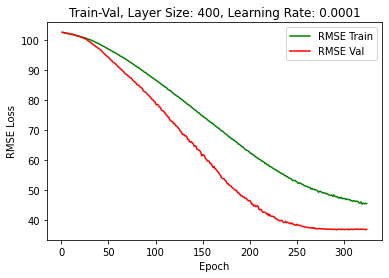

Part_Number_3_model_lr_0.0001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 103.196938200   Val(RMSE): 102.872732800   Train(MAE),%: 96.212848800   Val(MAE),%: 95.902880400 

Epochs 2   Counter 1   Train(RMSE): 103.127464000   Val(RMSE): 102.810865400   Train(MAE),%: 96.140967300   Val(MAE),%: 95.868377700 

Epochs 3   Counter 2   Train(RMSE): 103.055031800   Val(RMSE): 102.838803000   Train(MAE),%: 96.088770300   Val(MAE),%: 95.866141600 

Epochs 4   Counter 1   Train(RMSE): 103.000141300   Val(RMSE): 102.779096000   Train(MAE),%: 96.022134200   Val(MAE),%: 95.792578400 

Epochs 5   Counter 2   Train(RMSE): 102.930921100   Val(RMSE): 102.840581900   Train(MAE),%: 95.939108500   Val(MAE),%: 95.885365200 

Epochs 6   Counter 3   Train(RMSE): 102.84316920

Epochs 60   Counter 3   Train(RMSE): 96.824171000   Val(RMSE): 100.175534600   Train(MAE),%: 89.545791300   Val(MAE),%: 93.051960600 

Epochs 61   Counter 1   Train(RMSE): 96.619157500   Val(RMSE): 100.101623500   Train(MAE),%: 89.372920500   Val(MAE),%: 92.941079500 

Epochs 62   Counter 2   Train(RMSE): 96.439851200   Val(RMSE): 100.114482900   Train(MAE),%: 89.202027400   Val(MAE),%: 92.954324100 

Epochs 63   Counter 3   Train(RMSE): 96.212343300   Val(RMSE): 100.270582200   Train(MAE),%: 88.992104600   Val(MAE),%: 93.123241400 

Epochs 64   Counter 4   Train(RMSE): 96.139823300   Val(RMSE): 100.179627100   Train(MAE),%: 88.831092500   Val(MAE),%: 93.060962700 

Epochs 65   Counter 5   Train(RMSE): 95.926896500   Val(RMSE): 100.151728900   Train(MAE),%: 88.611338100   Val(MAE),%: 93.007446900 

Epochs 66   Counter 6   Train(RMSE): 95.749698100   Val(RMSE): 100.166716300   Train(MAE),%: 88.399317500   Val(MAE),%: 93.006034200 

Epochs 67   Counter 7   Train(RMSE): 95.598510700   Val

Epochs 121   Counter 1   Train(RMSE): 84.005316000   Val(RMSE): 86.612766300   Train(MAE),%: 75.562578000   Val(MAE),%: 78.529467300 

Epochs 122   Counter 1   Train(RMSE): 83.614093600   Val(RMSE): 86.192459700   Train(MAE),%: 75.228929900   Val(MAE),%: 78.008847600 

Epochs 123   Counter 1   Train(RMSE): 83.403770800   Val(RMSE): 86.067546800   Train(MAE),%: 75.016915700   Val(MAE),%: 77.928488400 

Epochs 124   Counter 1   Train(RMSE): 83.279017900   Val(RMSE): 85.338165300   Train(MAE),%: 74.719252500   Val(MAE),%: 77.165917100 

Epochs 125   Counter 1   Train(RMSE): 82.979204900   Val(RMSE): 85.150819800   Train(MAE),%: 74.324218800   Val(MAE),%: 76.997444200 

Epochs 126   Counter 1   Train(RMSE): 82.729965200   Val(RMSE): 84.433332400   Train(MAE),%: 74.082890400   Val(MAE),%: 76.203242000 

Epochs 127   Counter 1   Train(RMSE): 82.472630700   Val(RMSE): 84.359572700   Train(MAE),%: 73.863357900   Val(MAE),%: 76.071396500 

Epochs 128   Counter 1   Train(RMSE): 82.252110400   Va

Epochs 182   Counter 1   Train(RMSE): 67.979851800   Val(RMSE): 57.269595100   Train(MAE),%: 57.966672500   Val(MAE),%: 47.861410800 

Epochs 183   Counter 1   Train(RMSE): 67.843904200   Val(RMSE): 56.495372100   Train(MAE),%: 57.697735000   Val(MAE),%: 47.189636900 

Epochs 184   Counter 1   Train(RMSE): 67.334868100   Val(RMSE): 55.932460100   Train(MAE),%: 57.437115700   Val(MAE),%: 46.625671700 

Epochs 185   Counter 1   Train(RMSE): 67.235470000   Val(RMSE): 55.476935100   Train(MAE),%: 57.061510200   Val(MAE),%: 46.150534600 

Epochs 186   Counter 1   Train(RMSE): 67.093211300   Val(RMSE): 54.914465600   Train(MAE),%: 56.935550700   Val(MAE),%: 45.593744000 

Epochs 187   Counter 1   Train(RMSE): 66.747116400   Val(RMSE): 54.235086100   Train(MAE),%: 56.737417000   Val(MAE),%: 44.975683800 

Epochs 188   Counter 1   Train(RMSE): 66.490544200   Val(RMSE): 54.135505400   Train(MAE),%: 56.190037600   Val(MAE),%: 44.837133700 

Epochs 189   Counter 1   Train(RMSE): 66.201890700   Va

Epochs 243   Counter 1   Train(RMSE): 53.222564500   Val(RMSE): 38.687018700   Train(MAE),%: 43.300229300   Val(MAE),%: 31.032127200 

Epochs 244   Counter 2   Train(RMSE): 52.927767000   Val(RMSE): 38.692893700   Train(MAE),%: 43.007488600   Val(MAE),%: 31.038758900 

Epochs 245   Counter 1   Train(RMSE): 52.661519100   Val(RMSE): 38.373000500   Train(MAE),%: 42.655171300   Val(MAE),%: 30.786046800 

Epochs 246   Counter 1   Train(RMSE): 52.733765500   Val(RMSE): 38.342868500   Train(MAE),%: 42.733755400   Val(MAE),%: 30.754690600 

Epochs 247   Counter 1   Train(RMSE): 52.479488700   Val(RMSE): 38.231015200   Train(MAE),%: 42.428158100   Val(MAE),%: 30.661786100 

Epochs 248   Counter 2   Train(RMSE): 52.294057100   Val(RMSE): 38.257308600   Train(MAE),%: 42.344435700   Val(MAE),%: 30.651708100 

Epochs 249   Counter 1   Train(RMSE): 52.020604200   Val(RMSE): 38.108790700   Train(MAE),%: 42.037093800   Val(MAE),%: 30.531089100 

Epochs 250   Counter 2   Train(RMSE): 51.927515100   Va

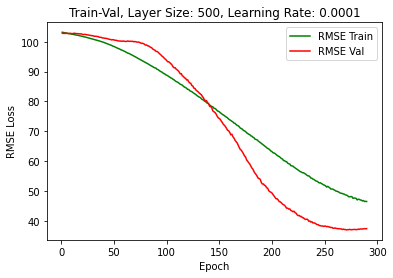

Part_Number_3_model_lr_0.0001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.615550500   Val(RMSE): 102.722634600   Train(MAE),%: 95.630487900   Val(MAE),%: 95.757103600 

Epochs 2   Counter 1   Train(RMSE): 102.545273200   Val(RMSE): 102.614080400   Train(MAE),%: 95.560395000   Val(MAE),%: 95.673900600 

Epochs 3   Counter 1   Train(RMSE): 102.496820200   Val(RMSE): 102.572270100   Train(MAE),%: 95.485595700   Val(MAE),%: 95.598086000 

Epochs 4   Counter 1   Train(RMSE): 102.413835300   Val(RMSE): 102.436046000   Train(MAE),%: 95.411523900   Val(MAE),%: 95.444688800 

Epochs 5   Counter 1   Train(RMSE): 102.356921700   Val(RMSE): 102.418437300   Train(MAE),%: 95.343936800   Val(MAE),%: 95.454353300 

Epochs 6   Counter 1   Train(RMSE): 102.26465710

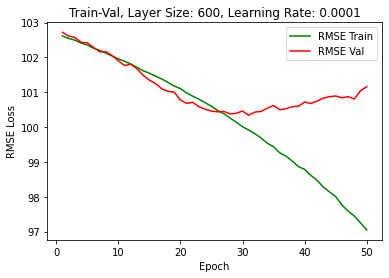

Part_Number_3_model_lr_0.0001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
12
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.734149800   Val(RMSE): 102.624256800   Train(MAE),%: 95.726165400   Val(MAE),%: 95.641834300 

Epochs 2   Counter 1   Train(RMSE): 102.446580000   Val(RMSE): 102.267495500   Train(MAE),%: 95.411409500   Val(MAE),%: 95.298727000 

Epochs 3   Counter 1   Train(RMSE): 102.089092100   Val(RMSE): 101.857221600   Train(MAE),%: 95.040860100   Val(MAE),%: 94.831614200 

Epochs 4   Counter 1   Train(RMSE): 101.685354800   Val(RMSE): 101.230802500   Train(MAE),%: 94.603393600   Val(MAE),%: 94.154645300 

Epochs 5   Counter 1   Train(RMSE): 101.255876000   Val(RMSE): 100.601490700   Train(MAE),%: 94.106225700   Val(MAE),%: 93.507448200 

Epochs 6   Counter 1   Train(RMSE): 100.702999600

Epochs 61   Counter 2   Train(RMSE): 43.673382600   Val(RMSE): 36.793920800   Train(MAE),%: 34.829761000   Val(MAE),%: 29.455065100 

Epochs 62   Counter 3   Train(RMSE): 43.612383300   Val(RMSE): 36.772398900   Train(MAE),%: 34.739897500   Val(MAE),%: 29.406773600 

Epochs 63   Counter 4   Train(RMSE): 43.347411800   Val(RMSE): 36.713442200   Train(MAE),%: 34.777041100   Val(MAE),%: 29.377326000 

Epochs 64   Counter 1   Train(RMSE): 43.730437200   Val(RMSE): 36.464971900   Train(MAE),%: 34.688289100   Val(MAE),%: 29.202179000 

Epochs 65   Counter 2   Train(RMSE): 43.312638200   Val(RMSE): 36.634380300   Train(MAE),%: 34.890168400   Val(MAE),%: 29.287233000 

Epochs 66   Counter 3   Train(RMSE): 43.428587700   Val(RMSE): 36.788852400   Train(MAE),%: 34.681829000   Val(MAE),%: 29.463232400 

Epochs 67   Counter 4   Train(RMSE): 43.630129100   Val(RMSE): 36.556058600   Train(MAE),%: 34.812505000   Val(MAE),%: 29.270794600 

Epochs 68   Counter 5   Train(RMSE): 43.333509500   Val(RMSE):

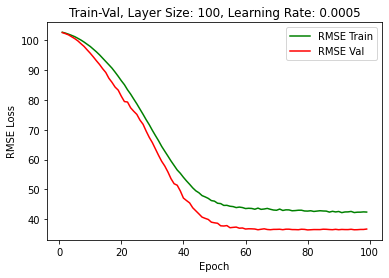

Part_Number_3_model_lr_0.0005_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.647821200   Val(RMSE): 102.547837600   Train(MAE),%: 95.625698900   Val(MAE),%: 95.563519200 

Epochs 2   Counter 1   Train(RMSE): 102.335105600   Val(RMSE): 102.182843500   Train(MAE),%: 95.277783300   Val(MAE),%: 95.207276700 

Epochs 3   Counter 1   Train(RMSE): 101.989699000   Val(RMSE): 101.882291200   Train(MAE),%: 94.913800400   Val(MAE),%: 94.852677700 

Epochs 4   Counter 1   Train(RMSE): 101.591025000   Val(RMSE): 101.409200000   Train(MAE),%: 94.505985400   Val(MAE),%: 94.340892800 

Epochs 5   Counter 1   Train(RMSE): 101.162763200   Val(RMSE): 100.864709900   Train(MAE),%: 94.028220800   Val(MAE),%: 93.784518600 

Epochs 6   Counter 1   Train(RMSE): 100.64405490

Epochs 61   Counter 2   Train(RMSE): 41.936880700   Val(RMSE): 36.941635400   Train(MAE),%: 33.561302200   Val(MAE),%: 29.577832500 

Epochs 62   Counter 3   Train(RMSE): 41.921291200   Val(RMSE): 36.901920600   Train(MAE),%: 33.577405300   Val(MAE),%: 29.524267800 

Epochs 63   Counter 4   Train(RMSE): 41.826177500   Val(RMSE): 36.917213400   Train(MAE),%: 33.442254800   Val(MAE),%: 29.541093000 

Epochs 64   Counter 1   Train(RMSE): 41.950160200   Val(RMSE): 36.736679100   Train(MAE),%: 33.533673800   Val(MAE),%: 29.411847400 

Epochs 65   Counter 2   Train(RMSE): 41.909801500   Val(RMSE): 36.808271100   Train(MAE),%: 33.641540700   Val(MAE),%: 29.423748300 

Epochs 66   Counter 3   Train(RMSE): 41.899606500   Val(RMSE): 36.904058100   Train(MAE),%: 33.381722300   Val(MAE),%: 29.553202300 

Epochs 67   Counter 4   Train(RMSE): 41.893551900   Val(RMSE): 36.788928000   Train(MAE),%: 33.568785600   Val(MAE),%: 29.460386800 

Epochs 68   Counter 1   Train(RMSE): 42.056538300   Val(RMSE):

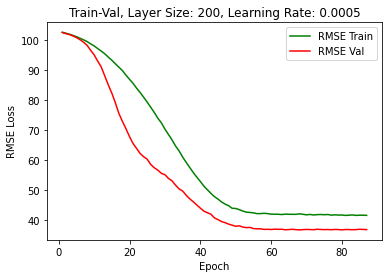

Part_Number_3_model_lr_0.0005_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.798930000   Val(RMSE): 102.699600900   Train(MAE),%: 95.774339100   Val(MAE),%: 95.722531000 

Epochs 2   Counter 1   Train(RMSE): 102.464355500   Val(RMSE): 102.293804800   Train(MAE),%: 95.432224100   Val(MAE),%: 95.321675000 

Epochs 3   Counter 1   Train(RMSE): 102.119859100   Val(RMSE): 101.917477300   Train(MAE),%: 95.054002800   Val(MAE),%: 94.887088800 

Epochs 4   Counter 1   Train(RMSE): 101.722322200   Val(RMSE): 101.314557400   Train(MAE),%: 94.650837100   Val(MAE),%: 94.234561900 

Epochs 5   Counter 1   Train(RMSE): 101.333871600   Val(RMSE): 100.750378900   Train(MAE),%: 94.200305800   Val(MAE),%: 93.660893800 

Epochs 6   Counter 1   Train(RMSE): 100.85394720

Epochs 60   Counter 19   Train(RMSE): 43.267722300   Val(RMSE): 40.499459600   Train(MAE),%: 34.927023800   Val(MAE),%: 32.632832800 

Epochs 61   Counter 20   Train(RMSE): 43.445112000   Val(RMSE): 40.752989800   Train(MAE),%: 34.657569700   Val(MAE),%: 32.839856800 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


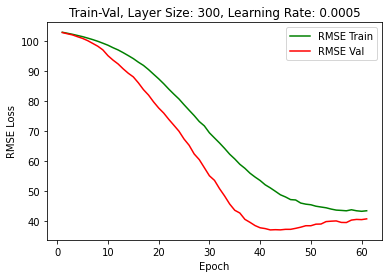

Part_Number_3_model_lr_0.0005_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 103.006880400   Val(RMSE): 102.589069400   Train(MAE),%: 96.018248800   Val(MAE),%: 95.606284500 

Epochs 2   Counter 1   Train(RMSE): 102.694410900   Val(RMSE): 102.366788200   Train(MAE),%: 95.665350500   Val(MAE),%: 95.401557900 

Epochs 3   Counter 1   Train(RMSE): 102.368574700   Val(RMSE): 102.219621000   Train(MAE),%: 95.320471100   Val(MAE),%: 95.213556300 

Epochs 4   Counter 1   Train(RMSE): 102.008811000   Val(RMSE): 101.942143100   Train(MAE),%: 94.951233600   Val(MAE),%: 94.907342900 

Epochs 5   Counter 1   Train(RMSE): 101.611693300   Val(RMSE): 101.746206300   Train(MAE),%: 94.543655700   Val(MAE),%: 94.724302300 

Epochs 6   Counter 1   Train(RMSE): 101.15334050

Epochs 61   Counter 13   Train(RMSE): 44.270320200   Val(RMSE): 38.328310000   Train(MAE),%: 35.207058900   Val(MAE),%: 30.731234600 

Epochs 62   Counter 14   Train(RMSE): 44.179695300   Val(RMSE): 38.073354100   Train(MAE),%: 35.209993400   Val(MAE),%: 30.507110600 

Epochs 63   Counter 15   Train(RMSE): 43.870151700   Val(RMSE): 38.180797300   Train(MAE),%: 35.117407400   Val(MAE),%: 30.597083900 

Epochs 64   Counter 16   Train(RMSE): 44.180116900   Val(RMSE): 37.773725800   Train(MAE),%: 35.257709700   Val(MAE),%: 30.280889700 

Epochs 65   Counter 17   Train(RMSE): 43.998358900   Val(RMSE): 37.612553600   Train(MAE),%: 35.226496300   Val(MAE),%: 30.093343100 

Epochs 66   Counter 18   Train(RMSE): 44.046047000   Val(RMSE): 38.384981500   Train(MAE),%: 35.192081500   Val(MAE),%: 30.787006200 

Epochs 67   Counter 19   Train(RMSE): 44.262725500   Val(RMSE): 37.764311500   Train(MAE),%: 35.321528400   Val(MAE),%: 30.254628700 

Epochs 68   Counter 20   Train(RMSE): 44.045894300   Va

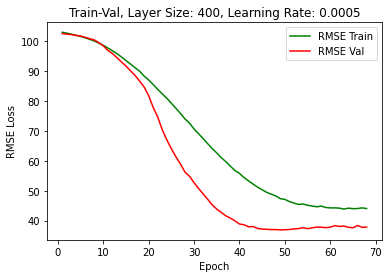

Part_Number_3_model_lr_0.0005_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.775651700   Val(RMSE): 102.250462200   Train(MAE),%: 95.752936700   Val(MAE),%: 95.206073800 

Epochs 2   Counter 1   Train(RMSE): 102.468108100   Val(RMSE): 101.447949100   Train(MAE),%: 95.420615500   Val(MAE),%: 94.353326200 

Epochs 3   Counter 1   Train(RMSE): 102.094547100   Val(RMSE): 100.063245800   Train(MAE),%: 95.034524700   Val(MAE),%: 92.812788600 

Epochs 4   Counter 1   Train(RMSE): 101.654381100   Val(RMSE): 98.874664900   Train(MAE),%: 94.569138900   Val(MAE),%: 91.523260100 

Epochs 5   Counter 1   Train(RMSE): 101.186707200   Val(RMSE): 97.910525600   Train(MAE),%: 94.063954200   Val(MAE),%: 90.539762500 

Epochs 6   Counter 1   Train(RMSE): 100.667051600 

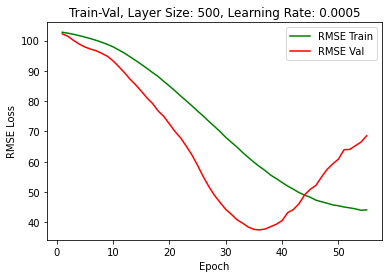

Part_Number_3_model_lr_0.0005_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.000500 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 103.029315800   Val(RMSE): 102.864646900   Train(MAE),%: 96.006323400   Val(MAE),%: 95.885737700 

Epochs 2   Counter 1   Train(RMSE): 102.714252300   Val(RMSE): 102.533587800   Train(MAE),%: 95.688803000   Val(MAE),%: 95.546887100 

Epochs 3   Counter 1   Train(RMSE): 102.395140900   Val(RMSE): 102.017573700   Train(MAE),%: 95.326996800   Val(MAE),%: 94.937212000 

Epochs 4   Counter 1   Train(RMSE): 102.009182100   Val(RMSE): 101.152978900   Train(MAE),%: 94.922231600   Val(MAE),%: 93.982815400 

Epochs 5   Counter 1   Train(RMSE): 101.613688900   Val(RMSE): 100.155148200   Train(MAE),%: 94.499009800   Val(MAE),%: 92.932570100 

Epochs 6   Counter 1   Train(RMSE): 101.15436290

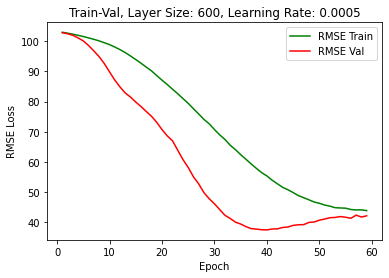

Part_Number_3_model_lr_0.0005_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.717144800   Val(RMSE): 102.427639000   Train(MAE),%: 95.689198400   Val(MAE),%: 95.446390800 

Epochs 2   Counter 1   Train(RMSE): 102.032807100   Val(RMSE): 101.848238600   Train(MAE),%: 94.951210000   Val(MAE),%: 94.861353600 

Epochs 3   Counter 1   Train(RMSE): 101.248894400   Val(RMSE): 101.036700600   Train(MAE),%: 94.120968400   Val(MAE),%: 93.962250400 

Epochs 4   Counter 1   Train(RMSE): 100.282504200   Val(RMSE): 99.693295200   Train(MAE),%: 93.092418500   Val(MAE),%: 92.514820100 

Epochs 5   Counter 1   Train(RMSE): 99.144806900   Val(RMSE): 98.015258200   Train(MAE),%: 91.841563300   Val(MAE),%: 90.744610500 

Epochs 6   Counter 1   Train(RMSE): 97.696839000   

Epochs 61   Counter 16   Train(RMSE): 41.461680700   Val(RMSE): 36.880791000   Train(MAE),%: 33.158862900   Val(MAE),%: 29.536181000 

Epochs 62   Counter 17   Train(RMSE): 41.389220900   Val(RMSE): 36.854913100   Train(MAE),%: 33.112038000   Val(MAE),%: 29.492732200 

Epochs 63   Counter 18   Train(RMSE): 41.356870400   Val(RMSE): 36.886303300   Train(MAE),%: 33.010278500   Val(MAE),%: 29.525904500 

Epochs 64   Counter 19   Train(RMSE): 41.418466200   Val(RMSE): 36.824834200   Train(MAE),%: 33.127480100   Val(MAE),%: 29.486079500 

Epochs 65   Counter 20   Train(RMSE): 41.485666400   Val(RMSE): 36.946514800   Train(MAE),%: 33.224828100   Val(MAE),%: 29.537170100 

//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////


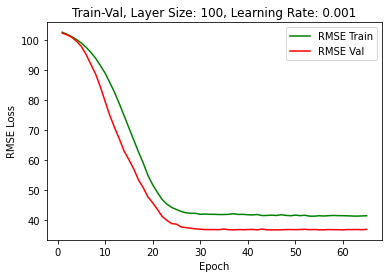

Part_Number_3_model_lr_0.001_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.540845500   Val(RMSE): 101.111937800   Train(MAE),%: 95.481634700   Val(MAE),%: 93.972798700 

Epochs 2   Counter 1   Train(RMSE): 101.810545900   Val(RMSE): 98.312816600   Train(MAE),%: 94.709564900   Val(MAE),%: 90.974950800 

Epochs 3   Counter 1   Train(RMSE): 100.969248200   Val(RMSE): 95.145390800   Train(MAE),%: 93.802983800   Val(MAE),%: 87.517150900 

Epochs 4   Counter 1   Train(RMSE): 99.878078000   Val(RMSE): 90.674793200   Train(MAE),%: 92.696996300   Val(MAE),%: 82.683462800 

Epochs 5   Counter 1   Train(RMSE): 98.625708500   Val(RMSE): 86.290075900   Train(MAE),%: 91.318604800   Val(MAE),%: 78.000315300 

Epochs 6   Counter 1   Train(RMSE): 97.068650000   Val(

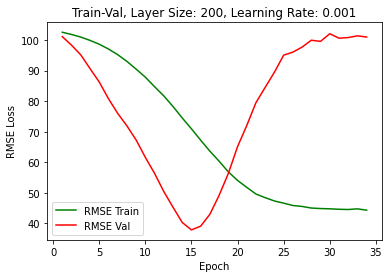

Part_Number_3_model_lr_0.001_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.645378800   Val(RMSE): 102.069248800   Train(MAE),%: 95.624777400   Val(MAE),%: 95.057005600 

Epochs 2   Counter 1   Train(RMSE): 101.966258500   Val(RMSE): 101.023723000   Train(MAE),%: 94.884900000   Val(MAE),%: 93.976907700 

Epochs 3   Counter 1   Train(RMSE): 101.197051300   Val(RMSE): 99.833494800   Train(MAE),%: 94.053933800   Val(MAE),%: 92.671663300 

Epochs 4   Counter 1   Train(RMSE): 100.226666300   Val(RMSE): 98.269429500   Train(MAE),%: 93.043929700   Val(MAE),%: 90.980990100 

Epochs 5   Counter 1   Train(RMSE): 99.128403000   Val(RMSE): 96.020493200   Train(MAE),%: 91.811839900   Val(MAE),%: 88.604784600 

Epochs 6   Counter 1   Train(RMSE): 97.793810300   Va

Epochs 61   Counter 16   Train(RMSE): 42.271166600   Val(RMSE): 36.868610700   Train(MAE),%: 33.812586600   Val(MAE),%: 29.513958600 

Epochs 62   Counter 17   Train(RMSE): 42.041889500   Val(RMSE): 36.857835100   Train(MAE),%: 33.822585700   Val(MAE),%: 29.482931800 

Epochs 63   Counter 18   Train(RMSE): 42.170023000   Val(RMSE): 36.893094700   Train(MAE),%: 33.664041100   Val(MAE),%: 29.515784400 

Epochs 64   Counter 1   Train(RMSE): 42.097960100   Val(RMSE): 36.739404400   Train(MAE),%: 33.644110600   Val(MAE),%: 29.410319500 

Epochs 65   Counter 2   Train(RMSE): 42.060046200   Val(RMSE): 36.992390000   Train(MAE),%: 33.702634600   Val(MAE),%: 29.559893400 

Epochs 66   Counter 3   Train(RMSE): 42.079842400   Val(RMSE): 36.877485900   Train(MAE),%: 33.639670700   Val(MAE),%: 29.523940200 

Epochs 67   Counter 4   Train(RMSE): 42.141014800   Val(RMSE): 36.762065900   Train(MAE),%: 33.645990600   Val(MAE),%: 29.427188600 

Epochs 68   Counter 5   Train(RMSE): 42.139025600   Val(RMS

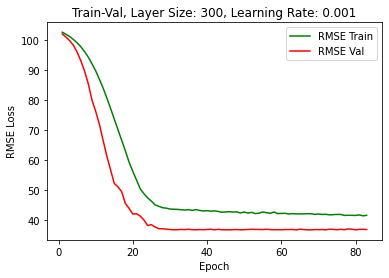

Part_Number_3_model_lr_0.001_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.896838300   Val(RMSE): 102.781098700   Train(MAE),%: 95.887027600   Val(MAE),%: 95.792841000 

Epochs 2   Counter 1   Train(RMSE): 102.275090100   Val(RMSE): 102.066160800   Train(MAE),%: 95.208566400   Val(MAE),%: 95.046021800 

Epochs 3   Counter 1   Train(RMSE): 101.485420900   Val(RMSE): 101.061820300   Train(MAE),%: 94.354056300   Val(MAE),%: 93.942127900 

Epochs 4   Counter 1   Train(RMSE): 100.479386000   Val(RMSE): 99.552672100   Train(MAE),%: 93.297176900   Val(MAE),%: 92.323167800 

Epochs 5   Counter 1   Train(RMSE): 99.263024700   Val(RMSE): 98.423971800   Train(MAE),%: 91.970434400   Val(MAE),%: 91.148427300 

Epochs 6   Counter 1   Train(RMSE): 97.743636800   V

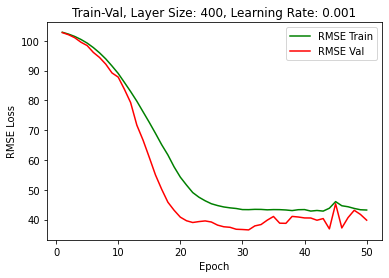

Part_Number_3_model_lr_0.001_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.525969100   Val(RMSE): 102.671296400   Train(MAE),%: 95.491882700   Val(MAE),%: 95.682940200 

Epochs 2   Counter 1   Train(RMSE): 101.818996600   Val(RMSE): 102.133893300   Train(MAE),%: 94.742129500   Val(MAE),%: 95.134712900 

Epochs 3   Counter 1   Train(RMSE): 100.999606900   Val(RMSE): 101.365651400   Train(MAE),%: 93.909695200   Val(MAE),%: 94.276927300 

Epochs 4   Counter 1   Train(RMSE): 99.913198700   Val(RMSE): 100.458519600   Train(MAE),%: 92.789280100   Val(MAE),%: 93.302389800 

Epochs 5   Counter 1   Train(RMSE): 98.504854300   Val(RMSE): 98.203601800   Train(MAE),%: 91.211746200   Val(MAE),%: 90.918156300 

Epochs 6   Counter 1   Train(RMSE): 96.675600800   V

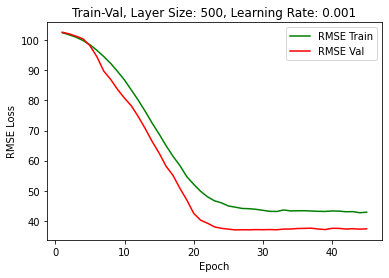

Part_Number_3_model_lr_0.001_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 102.436429200   Val(RMSE): 102.039918900   Train(MAE),%: 95.417581600   Val(MAE),%: 95.000101100 

Epochs 2   Counter 1   Train(RMSE): 101.667059900   Val(RMSE): 100.927806900   Train(MAE),%: 94.557877300   Val(MAE),%: 93.842070900 

Epochs 3   Counter 1   Train(RMSE): 100.709758300   Val(RMSE): 99.916009300   Train(MAE),%: 93.557013100   Val(MAE),%: 92.722776400 

Epochs 4   Counter 1   Train(RMSE): 99.563434100   Val(RMSE): 98.847044600   Train(MAE),%: 92.304505700   Val(MAE),%: 91.577861200 

Epochs 5   Counter 1   Train(RMSE): 98.116478300   Val(RMSE): 97.789584500   Train(MAE),%: 90.789744800   Val(MAE),%: 90.473285700 

Epochs 6   Counter 1   Train(RMSE): 96.393621700   Val

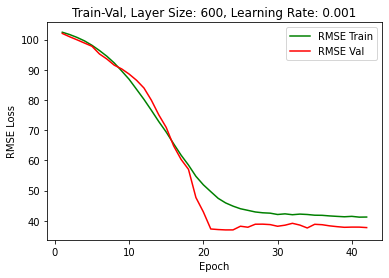

Part_Number_3_model_lr_0.001_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.018214
Trainable: 		 0.018214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     100.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.094593200   Val(RMSE): 90.530864100   Train(MAE),%: 90.428310900   Val(MAE),%: 82.709487300 

Epochs 2   Counter 1   Train(RMSE): 75.982570500   Val(RMSE): 46.322652200   Train(MAE),%: 66.216373300   Val(MAE),%: 37.618361200 

Epochs 3   Counter 1   Train(RMSE): 47.738848600   Val(RMSE): 37.115786200   Train(MAE),%: 37.638706400   Val(MAE),%: 29.741168300 

Epochs 4   Counter 1   Train(RMSE): 43.025609900   Val(RMSE): 36.905208000   Train(MAE),%: 34.893565600   Val(MAE),%: 29.549282600 

Epochs 5   Counter 1   Train(RMSE): 42.863477100   Val(RMSE): 36.824186000   Train(MAE),%: 34.244778700   Val(MAE),%: 29.460784100 

Epochs 6   Counter 1   Train(RMSE): 42.749858900   Val(RMSE

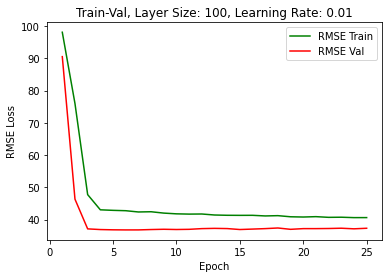

Part_Number_3_model_lr_0.01_layer_size_100.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.036614
Trainable: 		 0.036614
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     200.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.119761900   Val(RMSE): 93.728044500   Train(MAE),%: 90.511211600   Val(MAE),%: 86.117156300 

Epochs 2   Counter 1   Train(RMSE): 76.644827300   Val(RMSE): 68.361311000   Train(MAE),%: 66.615372400   Val(MAE),%: 59.205816000 

Epochs 3   Counter 1   Train(RMSE): 51.693408300   Val(RMSE): 39.820230800   Train(MAE),%: 41.449257400   Val(MAE),%: 31.932337000 

Epochs 4   Counter 1   Train(RMSE): 44.683315900   Val(RMSE): 38.474275900   Train(MAE),%: 35.671261800   Val(MAE),%: 30.810869900 

Epochs 5   Counter 1   Train(RMSE): 43.169559100   Val(RMSE): 36.997378000   Train(MAE),%: 34.459812700   Val(MAE),%: 29.588466300 

Epochs 6   Counter 1   Train(RMSE): 42.042157400   Val(RMSE)

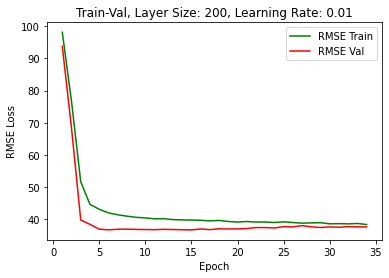

Part_Number_3_model_lr_0.01_layer_size_200.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.055014
Trainable: 		 0.055014
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     300.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.809927200   Val(RMSE): 93.806591000   Train(MAE),%: 91.290195600   Val(MAE),%: 86.246662100 

Epochs 2   Counter 1   Train(RMSE): 79.219575600   Val(RMSE): 56.164815600   Train(MAE),%: 69.517856800   Val(MAE),%: 46.871968600 

Epochs 3   Counter 1   Train(RMSE): 50.164422400   Val(RMSE): 37.134248700   Train(MAE),%: 40.172152600   Val(MAE),%: 29.732156300 

Epochs 4   Counter 1   Train(RMSE): 44.235954500   Val(RMSE): 36.905903800   Train(MAE),%: 35.547689200   Val(MAE),%: 29.554172400 

Epochs 5   Counter 2   Train(RMSE): 43.676029900   Val(RMSE): 37.138738600   Train(MAE),%: 35.102225400   Val(MAE),%: 29.711013300 

Epochs 6   Counter 3   Train(RMSE): 43.225067100   Val(RMSE)

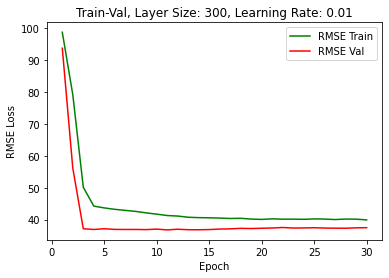

Part_Number_3_model_lr_0.01_layer_size_300.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.073414
Trainable: 		 0.073414
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     400.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.954629300   Val(RMSE): 86.850650800   Train(MAE),%: 91.435793000   Val(MAE),%: 78.702132500 

Epochs 2   Counter 1   Train(RMSE): 78.027321400   Val(RMSE): 53.973845200   Train(MAE),%: 68.407446700   Val(MAE),%: 44.772246700 

Epochs 3   Counter 1   Train(RMSE): 49.217989100   Val(RMSE): 37.174012800   Train(MAE),%: 39.494050100   Val(MAE),%: 29.748010800 

Epochs 4   Counter 1   Train(RMSE): 43.667925100   Val(RMSE): 36.997016300   Train(MAE),%: 34.896359800   Val(MAE),%: 29.615352000 

Epochs 5   Counter 1   Train(RMSE): 42.893748400   Val(RMSE): 36.899546300   Train(MAE),%: 34.247657400   Val(MAE),%: 29.509366400 

Epochs 6   Counter 1   Train(RMSE): 42.398923500   Val(RMSE)

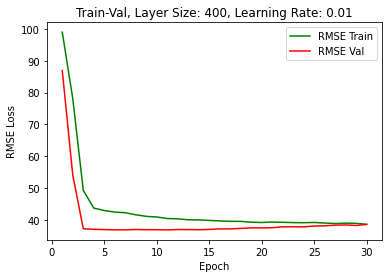

Part_Number_3_model_lr_0.01_layer_size_400.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.091814
Trainable: 		 0.091814
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     500.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 98.868349500   Val(RMSE): 91.791730200   Train(MAE),%: 91.389084900   Val(MAE),%: 83.998034800 

Epochs 2   Counter 1   Train(RMSE): 78.080985500   Val(RMSE): 64.222652800   Train(MAE),%: 68.172320500   Val(MAE),%: 55.003651900 

Epochs 3   Counter 1   Train(RMSE): 48.950844000   Val(RMSE): 40.568192200   Train(MAE),%: 39.208589100   Val(MAE),%: 32.544114300 

Epochs 4   Counter 1   Train(RMSE): 43.156609700   Val(RMSE): 40.360087100   Train(MAE),%: 34.487850200   Val(MAE),%: 32.420517100 

Epochs 5   Counter 1   Train(RMSE): 42.911287100   Val(RMSE): 39.465093900   Train(MAE),%: 34.177304500   Val(MAE),%: 31.649411800 

Epochs 6   Counter 2   Train(RMSE): 42.399803800   Val(RMSE)

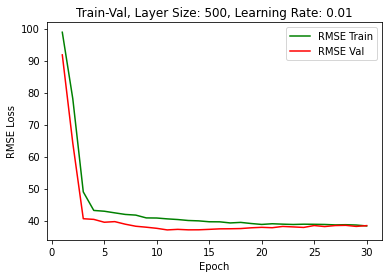

Part_Number_3_model_lr_0.01_layer_size_500.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197
Total: 		 0.110214
Trainable: 		 0.110214
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     600.00
 ////////////////////////
Epochs 1   Counter 1   Train(RMSE): 99.002527700   Val(RMSE): 90.166122400   Train(MAE),%: 91.521880400   Val(MAE),%: 82.278790200 

Epochs 2   Counter 1   Train(RMSE): 79.062729900   Val(RMSE): 42.390681600   Train(MAE),%: 69.511586100   Val(MAE),%: 34.056694700 

Epochs 3   Counter 1   Train(RMSE): 50.071764700   Val(RMSE): 37.983492500   Train(MAE),%: 39.928084500   Val(MAE),%: 30.375910000 

Epochs 4   Counter 2   Train(RMSE): 43.762644600   Val(RMSE): 38.291115800   Train(MAE),%: 35.314704900   Val(MAE),%: 30.649974000 

Epochs 5   Counter 3   Train(RMSE): 43.346639600   Val(RMSE): 39.977859500   Train(MAE),%: 34.510128200   Val(MAE),%: 32.050423300 

Epochs 6   Counter 4   Train(RMSE): 42.883211200   Val(RMSE)

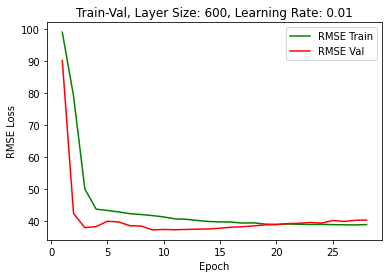

Part_Number_3_model_lr_0.01_layer_size_600.pt Was saved successfully 			[saved]
Ideal response's array shapes:
(197, 6)
(197,)
197


In [725]:
# script launcher
# here we initialize all arguments epoch size, K-fold, batch number, seeds, and so on

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', default = 1000, type = int,
                        help='Number of epochs for training')
    parser.add_argument('--stopping_criterion', default=20, type = int,
                        help='N iterations of non-improving validation score until early stopping')
    parser.add_argument('--batch_size', default = 256, type = int,
                        help='Batch size used for training')
    parser.add_argument('--device', type = str, default=("cpu" if not torch.cuda.is_available() else "cuda"),
                        help="Device: CPU or GPU on which training is conducted")
    parser.add_argument('--seed', default = 17, type=int,
                        help='Seed to reproduce the results')
    parser.add_argument('--n_splits', default = 3, type = int,
                        help = 'Number of pars for training in K-Fold cross-validations')
    parser.add_argument('--parts', type = list, default = np.arange(1,11),
                        help = 'Parts which we want consider. By default: all 10 parts of partition. See "n_splits"')

    args = parser.parse_args("")

    main(args)

# THE PROJECT ENDS HERE, IGNORE ANYTHING BELOW...

In [702]:
%ls

Data/                     Results/                 atakan_data_2000_500/
Data_100_500nm/           Results_Images/          element_agnostic-Copy1.ipynb
Data_40k/                 Results_Images_Element/  element_agnostic.ipynb*
Data_normal_with_6/       Results_atakan/          element_and_h.ipynb
Data_normal_with_6_last/  Results_element/         element_based.ipynb*
Data_uniform/             Untitled.ipynb*          tester/
Element_based_data/       aaa.csv*


In [645]:
model = torch.load('./Results/Part_Number_1/Part_Number_1_lr_0.0001_layer_size_100/Part_Number_1_model_lr_0.0001_layer_size_100.pt')

In [659]:
model = NeuralNetwork(100).to(device)
model.load_state_dict(torch.load('./Results/Part_Number_1/Part_Number_1_lr_0.0001_layer_size_100/Part_Number_1_model_lr_0.0001_layer_size_100.pt'))
print(device)

cuda:0


In [677]:
from torchsummary import summary

In [689]:
repr(model)

'NeuralNetwork(\n  (fc_layer_1): Linear(in_features=151, out_features=100, bias=True)\n  (conv_layer_2): Conv1d(1, 1, kernel_size=(3,), stride=(1,))\n  (conv_layer_3): Conv1d(1, 1, kernel_size=(3,), stride=(1,))\n  (maxpool_layer_4): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)\n  (fc_layer_5): Linear(in_features=92, out_features=30, bias=True)\n  (fc_layer_6): Linear(in_features=30, out_features=6, bias=True)\n  (relu): LeakyReLU(negative_slope=0.01)\n  (dropout): Dropout(p=0.5, inplace=False)\n  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (batchnorm2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (batchnorm3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (batchnorm4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n)'

In [690]:
print(model)

NeuralNetwork(
  (fc_layer_1): Linear(in_features=151, out_features=100, bias=True)
  (conv_layer_2): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv_layer_3): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (maxpool_layer_4): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc_layer_5): Linear(in_features=92, out_features=30, bias=True)
  (fc_layer_6): Linear(in_features=30, out_features=6, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [699]:
vals_arr, threshold_arr = increase1(model)

(1, 151)
torch.Size([1, 151])


ValueError: expected 2D or 3D input (got 1D input)

In [698]:
# function to gradually feed the already-trained model with ideal flat photonic response
# starting from 1 to 200 threshold, we feed a 1x151 vectors starting from [1, 1, 1, ..., 1] to [200, 200, 200, ..., 200]
# The trained NN model outputs the corresponding optimal design in response to the ideal flat response 


def increase1(bestmodel):
    
    bestmodel.eval()
    if includes_source_distance:
        expected = torch.ones(1,6)
    else:
        expected = torch.ones(1,5)

    threshold = 10
    j = 0
    vals_arr = []
    threshold_arr = []
    
    while threshold < 50:
        threshold = (1+j)
        j=j+0.25

        true_x_np = threshold * np.ones((1,151))
        print(true_x_np.shape)
        true_x = torch.from_numpy(true_x_np).float()
        print(true_x.shape)
        #true_x = true_x.unsqueeze(0)
        expected = bestmodel(true_x.to(device))
        
        #vals_arr.append(true_x_np)
        #threshold_arr.append(threshold)
        vals_arr.append(expected.cpu().data.numpy())
        threshold_arr.append(threshold)
    
    #expected = bestmodel(true_x.to(device)).view(1,-1)
    #output_val = []
    #vals_arr = np.array(vals_arr)
    #threshold_arr = np.array(threshold_arr)
    #vals_arr_torch = torch.from_numpy(vals_arr).float()
    #expected = bestmodel(vals_arr_torch.to(device)).view(1,-1)
    #output_val.append(expected.cpu().data.numpy())
    print(np.array(vals_arr))
    print(np.array(threshold_arr))
    
    #expected = bestmodel(true_x.to(device)).view(1,-1)
    vals_arr = np.array(vals_arr)
    #vals_arr = vals_arr.reshape(vals_arr.shape[0],-1)
    threshold_arr = np.array(threshold_arr)
    
    #print("Ideal response's array shapes:")
    #print(vals_arr.shape)
    #print(threshold_arr.shape)
    
    return output_val, threshold_arr 

In [ ]:
!mkdir Data_40k

In [ ]:
%ls

In [ ]:
%cd Data_40k/

In [ ]:
pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1ORiVwT3DjPOXzVe-qOwdYz03ygmWjj58

In [703]:
!rm -rf ./Results/

In [704]:
%ls

Data/                     Results_Images/          element_agnostic-Copy1.ipynb
Data_100_500nm/           Results_Images_Element/  element_agnostic.ipynb*
Data_40k/                 Results_atakan/          element_and_h.ipynb
Data_normal_with_6/       Results_element/         element_based.ipynb*
Data_normal_with_6_last/  Untitled.ipynb*          tester/
Data_uniform/             aaa.csv*
Element_based_data/       atakan_data_2000_500/


In [ ]:
!mkdir Data_100_500nm

In [ ]:
%cd Data_100_500nm/

In [ ]:
!unzip ger_core_100-500nm.zip

In [ ]:
!rm -rf ./Results/

In [ ]:
%ls

In [ ]:
%cd Element_based_data/fixed/

In [ ]:
%ls

In [ ]:
%cd atakan_data_2000_500/

In [ ]:
!mkdir atakan_data_2000_500

In [ ]:
!unzip atakan_test_1.zip

In [ ]:
!gdown https://drive.google.com/uc?id=13jQkoVsfIyLv2auQkQysx81Y8uS4U68M

In [ ]:
!pip install gdown